# PreProcessing


In [1]:
import os
import random
import shutil
import glob
import cv2
from glob import glob
import numpy as np
import pandas as pd
import gc
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, concatenate, Concatenate, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler

from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from datetime import datetime
import time
from keras.callbacks import CSVLogger
from deeplab import deeplabModel
from doubleunet import double_unet
from deeplabv1 import deeplab
from unet import unet

2023-11-30 20:41:32.670508: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 20:41:32.790657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 20:41:32.790686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 20:41:32.791265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 20:41:32.847467: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-11-30 20:41:38.710560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 20:41:38.720598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 20:41:38.720694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def load_data(img_height, img_width, images_to_be_loaded):
    IMAGES_PATH = "Kvasir-SEG/images/"
    MASKS_PATH = "Kvasir-SEG/masks/"

    train_ids = glob(IMAGES_PATH + "*.jpg")
    
    train_ids = sorted(train_ids)

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if np.any(mask_[i, j] >= 127):
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [4]:
img_size = 352
X, Y = load_data(img_size, img_size, -1)

Resizing training images and masks: 1000


1000it [05:17,  3.15it/s]


In [5]:
test_size = 0.2
validation_size = 0.5

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=validation_size, random_state=0)

In [6]:
import albumentations as A
from albumentations.augmentations import functional as F

aug_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    A.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
    A.GaussianBlur(blur_limit=(25, 25),sigma_limit=(0.001, 2.0),always_apply=False, p=0.5),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(X_train)):
        ug = aug_train(image=X_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
def dice_coeff(y_true, y_pred):

    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)

    return dice_scores

def dice_loss(y_true, y_pred):

    loss = 1 - dice_coeff(y_true, y_pred)

    return loss

def total_loss(y_true, y_pred):
    return 0.5*binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def IoU(y_true, y_pred, eps=1e-6):

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection

    return K.mean( (intersection + eps) / (union + eps), axis=0)

def zero_IoU(y_true, y_pred):

    return IoU(1-y_true, 1-y_pred)

def bce_dice_loss(y_true, y_pred):

    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1, alpha=0.7):

    y_true_pos = tf.reshape(y_true,[-1])
    y_pred_pos = tf.reshape(y_pred,[-1])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):

    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):

    tv = tversky(y_true, y_pred)

    return K.pow((1 - tv), gamma)

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = K.cast(ground_truth, tf.float32)
    predictions = K.cast(predictions, tf.float32)
    ground_truth = K.flatten(ground_truth)
    predictions = K.flatten(predictions)
    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice

In [8]:
seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="kvasir"
model_type = "deeplabv3p"

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type  +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type  + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type + 'newaug'

In [9]:
from keras.optimizers import AdamW

deeplabv3p_model = deeplabModel(modelType="ResNet101",shape=(352,352,3))
optimizer = AdamW(
    learning_rate = 0.00001, weight_decay = 0.004)
loss = 'binary_crossentropy'
deeplabv3p_model.compile(optimizer=optimizer, loss=loss,
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

2023-11-25 15:42:51.119851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 15:42:51.119977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 15:42:51.120023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
step = 0
learning_rate = 1e-5
min_loss_for_saving = 0.2

start_time = time.time()

for epoch in range(0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    tf.keras.backend.clear_session()

    image_augmented, mask_augmented = augment_images()

    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    deeplabv3p_model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(X_val, y_val), verbose=1, callbacks=[csv_logger])

    prediction_valid = deeplabv3p_model.predict(X_val, verbose=0, batch_size=4)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = deeplabv3p_model.predict(X_test, verbose=0, batch_size=4)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        deeplabv3p_model.save(model_path)

    del image_augmented
    del mask_augmented
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()

    
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Training, epoch 0
Learning Rate: 1e-05


2023-11-25 15:43:10.268704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-25 15:43:12.097738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 15:43:13.655246: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef9f02948b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 15:43:13.655265: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-25 15:43:13.657965: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 15:43:13.709588: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

200/200 [==============================] - 53s 109ms/step - loss: 0.6380 - accuracy: 0.6544 - f1_score: 0.4808 - dice_coeff: 0.3238 - dice_loss: 0.6762 - total_loss: 0.9952 - IoU: 0.1835 - zero_IoU: 0.5161 - precision: 0.2728 - recall: 0.8752 - val_loss: 2.2070 - val_accuracy: 0.5232 - val_f1_score: 0.1994 - val_dice_coeff: 0.2158 - val_dice_loss: 0.7842 - val_total_loss: 1.8877 - val_IoU: 0.1184 - val_zero_IoU: 0.3843 - val_precision: 0.1382 - val_recall: 0.4150
Loss Validation: 0.77595085
Loss Test: 0.7692709
Training, epoch 1
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.3311 - accuracy: 0.9280 - f1_score: 0.7215 - dice_coeff: 0.4326 - dice_loss: 0.5674 - total_loss: 0.7329 - IoU: 0.2551 - zero_IoU: 0.7256 - precision: 0.8074 - recall: 0.6425 - val_loss: 0.5027 - val_accuracy: 0.8351 - val_f1_score: 0.0564 - val_dice_coeff: 0.2054 - val_dice_loss: 0.7946 - val_total_loss: 1.0460 - val_IoU: 0.1080 - val_zero_IoU: 0.6412 - val_precision: 0.20

2023-11-25 15:44:29.287747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.2685 - accuracy: 0.9357 - f1_score: 0.7509 - dice_coeff: 0.4760 - dice_loss: 0.5240 - total_loss: 0.6582 - IoU: 0.2914 - zero_IoU: 0.7676 - precision: 0.8470 - recall: 0.6723 - val_loss: 0.3966 - val_accuracy: 0.8754 - val_f1_score: 0.3493 - val_dice_coeff: 0.2919 - val_dice_loss: 0.7081 - val_total_loss: 0.9064 - val_IoU: 0.1619 - val_zero_IoU: 0.6776 - val_precision: 0.7855 - val_recall: 0.2355
Loss Validation: 0.69349766
Loss Test: 0.68902326
Training, epoch 3
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.2388 - accuracy: 0.9409 - f1_score: 0.7839 - dice_coeff: 0.5213 - dice_loss: 0.4787 - total_loss: 0.5981 - IoU: 0.3256 - zero_IoU: 0.7957 - precision: 0.8421 - recall: 0.7221 - val_loss: 0.3126 - val_accuracy: 0.9359 - val_f1_score: 0.7758 - val_dice_coeff: 0.4491 - val_dice_loss: 0.5509 - val_total_loss: 0.7072 - val_IoU: 0.2773 - val_zero_IoU: 0.7124 - val_precision: 0.7

2023-11-25 15:45:30.827251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.2092 - accuracy: 0.9471 - f1_score: 0.7979 - dice_coeff: 0.5525 - dice_loss: 0.4475 - total_loss: 0.5521 - IoU: 0.3522 - zero_IoU: 0.8210 - precision: 0.8506 - recall: 0.7525 - val_loss: 0.2240 - val_accuracy: 0.9440 - val_f1_score: 0.8207 - val_dice_coeff: 0.5948 - val_dice_loss: 0.4052 - val_total_loss: 0.5172 - val_IoU: 0.4359 - val_zero_IoU: 0.8192 - val_precision: 0.8041 - val_recall: 0.8295
Loss Validation: 0.38814253
Loss Test: 0.4078952
Training, epoch 5
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.1877 - accuracy: 0.9477 - f1_score: 0.8045 - dice_coeff: 0.5789 - dice_loss: 0.4211 - total_loss: 0.5150 - IoU: 0.3793 - zero_IoU: 0.8383 - precision: 0.8583 - recall: 0.7518 - val_loss: 0.1790 - val_accuracy: 0.9459 - val_f1_score: 0.8271 - val_dice_coeff: 0.6660 - val_dice_loss: 0.3340 - val_total_loss: 0.4235 - val_IoU: 0.5096 - val_zero_IoU: 0.8654 - val_precision: 0.81

2023-11-25 15:46:32.302027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.1765 - accuracy: 0.9508 - f1_score: 0.8149 - dice_coeff: 0.6063 - dice_loss: 0.3937 - total_loss: 0.4819 - IoU: 0.4059 - zero_IoU: 0.8519 - precision: 0.8603 - recall: 0.7817 - val_loss: 0.1496 - val_accuracy: 0.9551 - val_f1_score: 0.8514 - val_dice_coeff: 0.6781 - val_dice_loss: 0.3219 - val_total_loss: 0.3968 - val_IoU: 0.5093 - val_zero_IoU: 0.8717 - val_precision: 0.8556 - val_recall: 0.8441
Loss Validation: 0.30431306
Loss Test: 0.31887525
Training, epoch 7
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.1613 - accuracy: 0.9528 - f1_score: 0.8209 - dice_coeff: 0.6230 - dice_loss: 0.3770 - total_loss: 0.4576 - IoU: 0.4262 - zero_IoU: 0.8643 - precision: 0.8659 - recall: 0.7813 - val_loss: 0.1427 - val_accuracy: 0.9547 - val_f1_score: 0.8527 - val_dice_coeff: 0.6960 - val_dice_loss: 0.3040 - val_total_loss: 0.3753 - val_IoU: 0.5267 - val_zero_IoU: 0.8780 - val_precision: 0.8

2023-11-25 15:47:34.079724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.1548 - accuracy: 0.9530 - f1_score: 0.8197 - dice_coeff: 0.6389 - dice_loss: 0.3611 - total_loss: 0.4385 - IoU: 0.4466 - zero_IoU: 0.8729 - precision: 0.8623 - recall: 0.7891 - val_loss: 0.1321 - val_accuracy: 0.9570 - val_f1_score: 0.8553 - val_dice_coeff: 0.7037 - val_dice_loss: 0.2963 - val_total_loss: 0.3623 - val_IoU: 0.5278 - val_zero_IoU: 0.8862 - val_precision: 0.8675 - val_recall: 0.8431
Loss Validation: 0.28206962
Loss Test: 0.30877072
Training, epoch 9
Learning Rate: 1e-05
200/200 [==============================] - 24s 109ms/step - loss: 0.1383 - accuracy: 0.9577 - f1_score: 0.8369 - dice_coeff: 0.6715 - dice_loss: 0.3285 - total_loss: 0.3976 - IoU: 0.4738 - zero_IoU: 0.8840 - precision: 0.8725 - recall: 0.8208 - val_loss: 0.1349 - val_accuracy: 0.9544 - val_f1_score: 0.8528 - val_dice_coeff: 0.7295 - val_dice_loss: 0.2705 - val_total_loss: 0.3380 - val_IoU: 0.5656 - val_zero_IoU: 0.8917 - val_precision: 0.8

2023-11-25 15:48:36.082242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.1336 - accuracy: 0.9583 - f1_score: 0.8398 - dice_coeff: 0.6799 - dice_loss: 0.3201 - total_loss: 0.3869 - IoU: 0.4858 - zero_IoU: 0.8909 - precision: 0.8764 - recall: 0.8120 - val_loss: 0.1245 - val_accuracy: 0.9564 - val_f1_score: 0.8613 - val_dice_coeff: 0.7348 - val_dice_loss: 0.2652 - val_total_loss: 0.3274 - val_IoU: 0.5665 - val_zero_IoU: 0.8971 - val_precision: 0.8517 - val_recall: 0.8598
Loss Validation: 0.2542835
Loss Test: 0.26319677
Training, epoch 11
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.1364 - accuracy: 0.9577 - f1_score: 0.8447 - dice_coeff: 0.6886 - dice_loss: 0.3114 - total_loss: 0.3797 - IoU: 0.4943 - zero_IoU: 0.8925 - precision: 0.8777 - recall: 0.8140 - val_loss: 0.1212 - val_accuracy: 0.9558 - val_f1_score: 0.8594 - val_dice_coeff: 0.7438 - val_dice_loss: 0.2562 - val_total_loss: 0.3168 - val_IoU: 0.5903 - val_zero_IoU: 0.8992 - val_precision: 0.8

2023-11-25 15:49:38.017703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.1258 - accuracy: 0.9605 - f1_score: 0.8524 - dice_coeff: 0.7089 - dice_loss: 0.2911 - total_loss: 0.3540 - IoU: 0.5192 - zero_IoU: 0.8998 - precision: 0.8861 - recall: 0.8295 - val_loss: 0.1301 - val_accuracy: 0.9558 - val_f1_score: 0.8602 - val_dice_coeff: 0.7354 - val_dice_loss: 0.2646 - val_total_loss: 0.3297 - val_IoU: 0.5681 - val_zero_IoU: 0.8917 - val_precision: 0.8290 - val_recall: 0.8895
Loss Validation: 0.2551989
Loss Test: 0.23955387
Training, epoch 13
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.1185 - accuracy: 0.9616 - f1_score: 0.8581 - dice_coeff: 0.7195 - dice_loss: 0.2805 - total_loss: 0.3398 - IoU: 0.5282 - zero_IoU: 0.9056 - precision: 0.8888 - recall: 0.8304 - val_loss: 0.1128 - val_accuracy: 0.9583 - val_f1_score: 0.8638 - val_dice_coeff: 0.7686 - val_dice_loss: 0.2314 - val_total_loss: 0.2878 - val_IoU: 0.6187 - val_zero_IoU: 0.9086 - val_precision: 0.8

2023-11-25 15:50:39.825128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.1159 - accuracy: 0.9616 - f1_score: 0.8561 - dice_coeff: 0.7247 - dice_loss: 0.2753 - total_loss: 0.3332 - IoU: 0.5392 - zero_IoU: 0.9074 - precision: 0.8860 - recall: 0.8375 - val_loss: 0.1217 - val_accuracy: 0.9550 - val_f1_score: 0.8617 - val_dice_coeff: 0.7627 - val_dice_loss: 0.2373 - val_total_loss: 0.2982 - val_IoU: 0.6116 - val_zero_IoU: 0.9024 - val_precision: 0.8129 - val_recall: 0.9104
Loss Validation: 0.22988701
Loss Test: 0.22425061
Training, epoch 15
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.1076 - accuracy: 0.9638 - f1_score: 0.8627 - dice_coeff: 0.7368 - dice_loss: 0.2632 - total_loss: 0.3170 - IoU: 0.5469 - zero_IoU: 0.9134 - precision: 0.8883 - recall: 0.8451 - val_loss: 0.1057 - val_accuracy: 0.9611 - val_f1_score: 0.8741 - val_dice_coeff: 0.7862 - val_dice_loss: 0.2138 - val_total_loss: 0.2666 - val_IoU: 0.6444 - val_zero_IoU: 0.9156 - val_precision: 0.

2023-11-25 15:51:41.745629: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 25s 108ms/step - loss: 0.1053 - accuracy: 0.9648 - f1_score: 0.8624 - dice_coeff: 0.7421 - dice_loss: 0.2579 - total_loss: 0.3105 - IoU: 0.5645 - zero_IoU: 0.9175 - precision: 0.8907 - recall: 0.8521 - val_loss: 0.1257 - val_accuracy: 0.9520 - val_f1_score: 0.8489 - val_dice_coeff: 0.7653 - val_dice_loss: 0.2347 - val_total_loss: 0.2975 - val_IoU: 0.6237 - val_zero_IoU: 0.9042 - val_precision: 0.8025 - val_recall: 0.9032
Loss Validation: 0.22678453
Loss Test: 0.21130228
Training, epoch 17
Learning Rate: 1e-05
200/200 [==============================] - 25s 109ms/step - loss: 0.1084 - accuracy: 0.9632 - f1_score: 0.8612 - dice_coeff: 0.7489 - dice_loss: 0.2511 - total_loss: 0.3053 - IoU: 0.5658 - zero_IoU: 0.9164 - precision: 0.8898 - recall: 0.8444 - val_loss: 0.1040 - val_accuracy: 0.9597 - val_f1_score: 0.8684 - val_dice_coeff: 0.7902 - val_dice_loss: 0.2098 - val_total_loss: 0.2618 - val_IoU: 0.6530 - val_zero_IoU: 0.9187 - val_precision: 0.

2023-11-25 15:52:43.963548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.1120 - accuracy: 0.9620 - f1_score: 0.8595 - dice_coeff: 0.7449 - dice_loss: 0.2551 - total_loss: 0.3111 - IoU: 0.5723 - zero_IoU: 0.9151 - precision: 0.8871 - recall: 0.8426 - val_loss: 0.1075 - val_accuracy: 0.9579 - val_f1_score: 0.8648 - val_dice_coeff: 0.7830 - val_dice_loss: 0.2170 - val_total_loss: 0.2707 - val_IoU: 0.6443 - val_zero_IoU: 0.9145 - val_precision: 0.8442 - val_recall: 0.8829
Loss Validation: 0.21198368
Loss Test: 0.2089886
Training, epoch 19
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.1017 - accuracy: 0.9646 - f1_score: 0.8645 - dice_coeff: 0.7528 - dice_loss: 0.2472 - total_loss: 0.2981 - IoU: 0.5860 - zero_IoU: 0.9208 - precision: 0.8907 - recall: 0.8508 - val_loss: 0.1100 - val_accuracy: 0.9572 - val_f1_score: 0.8635 - val_dice_coeff: 0.7901 - val_dice_loss: 0.2099 - val_total_loss: 0.2649 - val_IoU: 0.6592 - val_zero_IoU: 0.9164 - val_precision: 0.8

2023-11-25 15:53:45.954839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.1015 - accuracy: 0.9647 - f1_score: 0.8663 - dice_coeff: 0.7630 - dice_loss: 0.2370 - total_loss: 0.2878 - IoU: 0.5943 - zero_IoU: 0.9212 - precision: 0.8954 - recall: 0.8508 - val_loss: 0.1089 - val_accuracy: 0.9565 - val_f1_score: 0.8604 - val_dice_coeff: 0.8001 - val_dice_loss: 0.1999 - val_total_loss: 0.2544 - val_IoU: 0.6831 - val_zero_IoU: 0.9201 - val_precision: 0.8316 - val_recall: 0.8909
Loss Validation: 0.19647825
Loss Test: 0.18110406
Saved model with val_loss:  0.19647825
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 21
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0967 - accuracy: 0.9663 - f1_score: 0.8746 - dice_coeff: 0.7733 - dice_loss: 0.2267 - total_loss: 0.2751 - IoU: 0.5981 - zero_IoU: 0.9243 - precision: 0.8988 - recall: 0.8590 - val_loss: 0.1131 - val_accuracy: 0.9557 - val_f1_score: 0.8597 - val_dice_coeff: 0.7876 - val_dice_loss: 0.2124 - val_total_loss: 0.2689 - val_IoU: 0.6580 - val_zero_IoU: 0.9138 - val_precision: 0.8265 - val_recall: 0.8925
Loss Validation: 0.2088176
Loss Test: 0.19124335
Training, epoch 22
Learning Rate: 1e-05


2023-11-25 15:55:05.862383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0925 - accuracy: 0.9670 - f1_score: 0.8756 - dice_coeff: 0.7790 - dice_loss: 0.2210 - total_loss: 0.2673 - IoU: 0.6079 - zero_IoU: 0.9286 - precision: 0.8996 - recall: 0.8557 - val_loss: 0.1143 - val_accuracy: 0.9539 - val_f1_score: 0.8554 - val_dice_coeff: 0.7984 - val_dice_loss: 0.2016 - val_total_loss: 0.2588 - val_IoU: 0.6851 - val_zero_IoU: 0.9178 - val_precision: 0.8132 - val_recall: 0.9003
Loss Validation: 0.19969964
Loss Test: 0.17615098
Training, epoch 23
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0949 - accuracy: 0.9652 - f1_score: 0.8738 - dice_coeff: 0.7823 - dice_loss: 0.2177 - total_loss: 0.2652 - IoU: 0.6191 - zero_IoU: 0.9258 - precision: 0.8930 - recall: 0.8599 - val_loss: 0.1066 - val_accuracy: 0.9576 - val_f1_score: 0.8672 - val_dice_coeff: 0.8080 - val_dice_loss: 0.1920 - val_total_loss: 0.2453 - val_IoU: 0.6887 - val_zero_IoU: 0.9229 - val_precision: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 24
Learning Rate: 1e-05


2023-11-25 15:56:23.952122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0904 - accuracy: 0.9678 - f1_score: 0.8774 - dice_coeff: 0.7836 - dice_loss: 0.2164 - total_loss: 0.2616 - IoU: 0.6200 - zero_IoU: 0.9301 - precision: 0.8989 - recall: 0.8672 - val_loss: 0.0893 - val_accuracy: 0.9658 - val_f1_score: 0.8880 - val_dice_coeff: 0.8281 - val_dice_loss: 0.1719 - val_total_loss: 0.2165 - val_IoU: 0.7125 - val_zero_IoU: 0.9346 - val_precision: 0.9080 - val_recall: 0.8594
Loss Validation: 0.1717158
Loss Test: 0.16828924
Saved model with val_loss:  0.1717158
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 25
Learning Rate: 1e-05
200/200 [==============================] - 24s 106ms/step - loss: 0.0911 - accuracy: 0.9681 - f1_score: 0.8831 - dice_coeff: 0.7946 - dice_loss: 0.2054 - total_loss: 0.2509 - IoU: 0.6309 - zero_IoU: 0.9312 - precision: 0.9045 - recall: 0.8652 - val_loss: 0.0915 - val_accuracy: 0.9627 - val_f1_score: 0.8752 - val_dice_coeff: 0.8228 - val_dice_loss: 0.1772 - val_total_loss: 0.2230 - val_IoU: 0.7075 - val_zero_IoU: 0.9311 - val_precision: 0.8751 - val_recall: 0.8768
Loss Validation: 0.17400205
Loss Test: 0.16151339
Training, epoch 26
Learning Rate: 1e-05


2023-11-25 15:57:41.926893: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0866 - accuracy: 0.9684 - f1_score: 0.8793 - dice_coeff: 0.7927 - dice_loss: 0.2073 - total_loss: 0.2506 - IoU: 0.6291 - zero_IoU: 0.9353 - precision: 0.8978 - recall: 0.8670 - val_loss: 0.0857 - val_accuracy: 0.9664 - val_f1_score: 0.8840 - val_dice_coeff: 0.8313 - val_dice_loss: 0.1687 - val_total_loss: 0.2115 - val_IoU: 0.7206 - val_zero_IoU: 0.9339 - val_precision: 0.8914 - val_recall: 0.8842
Loss Validation: 0.16532063
Loss Test: 0.15702915
Saved model with val_loss:  0.16532063
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 27
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0877 - accuracy: 0.9691 - f1_score: 0.8832 - dice_coeff: 0.7986 - dice_loss: 0.2014 - total_loss: 0.2453 - IoU: 0.6404 - zero_IoU: 0.9332 - precision: 0.9072 - recall: 0.8725 - val_loss: 0.0860 - val_accuracy: 0.9654 - val_f1_score: 0.8783 - val_dice_coeff: 0.8179 - val_dice_loss: 0.1821 - val_total_loss: 0.2251 - val_IoU: 0.6984 - val_zero_IoU: 0.9348 - val_precision: 0.9258 - val_recall: 0.8371
Loss Validation: 0.1781283
Loss Test: 0.18510342
Training, epoch 28
Learning Rate: 1e-05


2023-11-25 15:59:00.279446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0858 - accuracy: 0.9691 - f1_score: 0.8810 - dice_coeff: 0.7981 - dice_loss: 0.2019 - total_loss: 0.2448 - IoU: 0.6399 - zero_IoU: 0.9341 - precision: 0.9092 - recall: 0.8681 - val_loss: 0.0950 - val_accuracy: 0.9624 - val_f1_score: 0.8752 - val_dice_coeff: 0.8206 - val_dice_loss: 0.1794 - val_total_loss: 0.2269 - val_IoU: 0.7191 - val_zero_IoU: 0.9286 - val_precision: 0.8510 - val_recall: 0.9091
Loss Validation: 0.1748004
Loss Test: 0.16304523
Training, epoch 29
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0851 - accuracy: 0.9687 - f1_score: 0.8855 - dice_coeff: 0.8023 - dice_loss: 0.1977 - total_loss: 0.2403 - IoU: 0.6484 - zero_IoU: 0.9345 - precision: 0.9023 - recall: 0.8710 - val_loss: 0.0866 - val_accuracy: 0.9664 - val_f1_score: 0.8848 - val_dice_coeff: 0.8285 - val_dice_loss: 0.1715 - val_total_loss: 0.2148 - val_IoU: 0.7221 - val_zero_IoU: 0.9347 - val_precision: 0.8

2023-11-25 16:00:01.831905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.0833 - accuracy: 0.9709 - f1_score: 0.8860 - dice_coeff: 0.7996 - dice_loss: 0.2004 - total_loss: 0.2421 - IoU: 0.6441 - zero_IoU: 0.9385 - precision: 0.9088 - recall: 0.8740 - val_loss: 0.0843 - val_accuracy: 0.9681 - val_f1_score: 0.8903 - val_dice_coeff: 0.8385 - val_dice_loss: 0.1615 - val_total_loss: 0.2037 - val_IoU: 0.7287 - val_zero_IoU: 0.9386 - val_precision: 0.9014 - val_recall: 0.8845
Loss Validation: 0.1571989
Loss Test: 0.1571055
Saved model with val_loss:  0.1571989
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 31
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0801 - accuracy: 0.9713 - f1_score: 0.8913 - dice_coeff: 0.8168 - dice_loss: 0.1832 - total_loss: 0.2233 - IoU: 0.6603 - zero_IoU: 0.9402 - precision: 0.9148 - recall: 0.8787 - val_loss: 0.0863 - val_accuracy: 0.9667 - val_f1_score: 0.8891 - val_dice_coeff: 0.8402 - val_dice_loss: 0.1598 - val_total_loss: 0.2030 - val_IoU: 0.7322 - val_zero_IoU: 0.9377 - val_precision: 0.8906 - val_recall: 0.8875
Loss Validation: 0.15784603
Loss Test: 0.15871692
Training, epoch 32
Learning Rate: 1e-05


2023-11-25 16:01:19.390999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0794 - accuracy: 0.9704 - f1_score: 0.8882 - dice_coeff: 0.8159 - dice_loss: 0.1841 - total_loss: 0.2238 - IoU: 0.6646 - zero_IoU: 0.9398 - precision: 0.9073 - recall: 0.8786 - val_loss: 0.0844 - val_accuracy: 0.9668 - val_f1_score: 0.8884 - val_dice_coeff: 0.8424 - val_dice_loss: 0.1576 - val_total_loss: 0.1999 - val_IoU: 0.7362 - val_zero_IoU: 0.9395 - val_precision: 0.8984 - val_recall: 0.8785
Loss Validation: 0.15540767
Loss Test: 0.15455467
Saved model with val_loss:  0.15540767
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 33
Learning Rate: 1e-05
200/200 [==============================] - 24s 105ms/step - loss: 0.0772 - accuracy: 0.9721 - f1_score: 0.8934 - dice_coeff: 0.8163 - dice_loss: 0.1837 - total_loss: 0.2224 - IoU: 0.6630 - zero_IoU: 0.9422 - precision: 0.9091 - recall: 0.8810 - val_loss: 0.0936 - val_accuracy: 0.9637 - val_f1_score: 0.8799 - val_dice_coeff: 0.8366 - val_dice_loss: 0.1634 - val_total_loss: 0.2102 - val_IoU: 0.7368 - val_zero_IoU: 0.9367 - val_precision: 0.8807 - val_recall: 0.8772
Loss Validation: 0.16293228
Loss Test: 0.14504772
Training, epoch 34
Learning Rate: 1e-05


2023-11-25 16:02:36.925301: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.0766 - accuracy: 0.9721 - f1_score: 0.8903 - dice_coeff: 0.8166 - dice_loss: 0.1834 - total_loss: 0.2217 - IoU: 0.6670 - zero_IoU: 0.9422 - precision: 0.9126 - recall: 0.8845 - val_loss: 0.1008 - val_accuracy: 0.9598 - val_f1_score: 0.8722 - val_dice_coeff: 0.8252 - val_dice_loss: 0.1748 - val_total_loss: 0.2252 - val_IoU: 0.7228 - val_zero_IoU: 0.9295 - val_precision: 0.8279 - val_recall: 0.9252
Loss Validation: 0.17119765
Loss Test: 0.15812063
Training, epoch 35
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0766 - accuracy: 0.9724 - f1_score: 0.8968 - dice_coeff: 0.8250 - dice_loss: 0.1750 - total_loss: 0.2133 - IoU: 0.6767 - zero_IoU: 0.9432 - precision: 0.9151 - recall: 0.8850 - val_loss: 0.0999 - val_accuracy: 0.9607 - val_f1_score: 0.8717 - val_dice_coeff: 0.8241 - val_dice_loss: 0.1759 - val_total_loss: 0.2258 - val_IoU: 0.7251 - val_zero_IoU: 0.9295 - val_precision: 0.

2023-11-25 16:03:38.489008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0824 - accuracy: 0.9687 - f1_score: 0.8856 - dice_coeff: 0.8143 - dice_loss: 0.1857 - total_loss: 0.2269 - IoU: 0.6698 - zero_IoU: 0.9366 - precision: 0.8992 - recall: 0.8780 - val_loss: 0.0942 - val_accuracy: 0.9638 - val_f1_score: 0.8796 - val_dice_coeff: 0.8278 - val_dice_loss: 0.1722 - val_total_loss: 0.2192 - val_IoU: 0.7250 - val_zero_IoU: 0.9318 - val_precision: 0.8456 - val_recall: 0.9286
Loss Validation: 0.16639727
Loss Test: 0.15306371
Training, epoch 37
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0713 - accuracy: 0.9736 - f1_score: 0.9014 - dice_coeff: 0.8352 - dice_loss: 0.1648 - total_loss: 0.2005 - IoU: 0.6922 - zero_IoU: 0.9451 - precision: 0.9186 - recall: 0.8915 - val_loss: 0.0946 - val_accuracy: 0.9618 - val_f1_score: 0.8782 - val_dice_coeff: 0.8350 - val_dice_loss: 0.1650 - val_total_loss: 0.2123 - val_IoU: 0.7348 - val_zero_IoU: 0.9345 - val_precision: 0.

2023-11-25 16:04:39.803086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0730 - accuracy: 0.9732 - f1_score: 0.9010 - dice_coeff: 0.8376 - dice_loss: 0.1624 - total_loss: 0.1989 - IoU: 0.6913 - zero_IoU: 0.9446 - precision: 0.9154 - recall: 0.8955 - val_loss: 0.0918 - val_accuracy: 0.9670 - val_f1_score: 0.8899 - val_dice_coeff: 0.8419 - val_dice_loss: 0.1581 - val_total_loss: 0.2040 - val_IoU: 0.7479 - val_zero_IoU: 0.9391 - val_precision: 0.8840 - val_recall: 0.8983
Loss Validation: 0.15576017
Loss Test: 0.14456165
Training, epoch 39
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0788 - accuracy: 0.9711 - f1_score: 0.8931 - dice_coeff: 0.8270 - dice_loss: 0.1730 - total_loss: 0.2124 - IoU: 0.6800 - zero_IoU: 0.9426 - precision: 0.9116 - recall: 0.8797 - val_loss: 0.0840 - val_accuracy: 0.9664 - val_f1_score: 0.8879 - val_dice_coeff: 0.8470 - val_dice_loss: 0.1530 - val_total_loss: 0.1950 - val_IoU: 0.7535 - val_zero_IoU: 0.9413 - val_precision: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 40
Learning Rate: 1e-05


2023-11-25 16:05:58.613637: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0708 - accuracy: 0.9730 - f1_score: 0.9002 - dice_coeff: 0.8335 - dice_loss: 0.1665 - total_loss: 0.2019 - IoU: 0.6894 - zero_IoU: 0.9440 - precision: 0.9148 - recall: 0.8940 - val_loss: 0.0897 - val_accuracy: 0.9646 - val_f1_score: 0.8858 - val_dice_coeff: 0.8411 - val_dice_loss: 0.1589 - val_total_loss: 0.2038 - val_IoU: 0.7454 - val_zero_IoU: 0.9350 - val_precision: 0.8387 - val_recall: 0.9463
Loss Validation: 0.15357065
Loss Test: 0.14113772
Training, epoch 41
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0698 - accuracy: 0.9743 - f1_score: 0.9009 - dice_coeff: 0.8395 - dice_loss: 0.1605 - total_loss: 0.1954 - IoU: 0.6942 - zero_IoU: 0.9475 - precision: 0.9214 - recall: 0.8967 - val_loss: 0.0844 - val_accuracy: 0.9677 - val_f1_score: 0.8915 - val_dice_coeff: 0.8455 - val_dice_loss: 0.1545 - val_total_loss: 0.1967 - val_IoU: 0.7476 - val_zero_IoU: 0.9384 - val_precision: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 42
Learning Rate: 1e-05


2023-11-25 16:07:16.515001: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0659 - accuracy: 0.9756 - f1_score: 0.9085 - dice_coeff: 0.8500 - dice_loss: 0.1500 - total_loss: 0.1829 - IoU: 0.7083 - zero_IoU: 0.9501 - precision: 0.9239 - recall: 0.9020 - val_loss: 0.0824 - val_accuracy: 0.9694 - val_f1_score: 0.9004 - val_dice_coeff: 0.8487 - val_dice_loss: 0.1513 - val_total_loss: 0.1926 - val_IoU: 0.7427 - val_zero_IoU: 0.9384 - val_precision: 0.8602 - val_recall: 0.9511
Loss Validation: 0.14640039
Loss Test: 0.14386362
Saved model with val_loss:  0.14640039
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 43
Learning Rate: 1e-05
200/200 [==============================] - 24s 106ms/step - loss: 0.0696 - accuracy: 0.9746 - f1_score: 0.9061 - dice_coeff: 0.8435 - dice_loss: 0.1565 - total_loss: 0.1913 - IoU: 0.7080 - zero_IoU: 0.9478 - precision: 0.9187 - recall: 0.9004 - val_loss: 0.0732 - val_accuracy: 0.9691 - val_f1_score: 0.8936 - val_dice_coeff: 0.8579 - val_dice_loss: 0.1421 - val_total_loss: 0.1787 - val_IoU: 0.7639 - val_zero_IoU: 0.9457 - val_precision: 0.8894 - val_recall: 0.9071
Loss Validation: 0.13730967
Loss Test: 0.14174932
Saved model with val_loss:  0.13730967
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 44
Learning Rate: 1e-05


2023-11-25 16:08:51.407915: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.0636 - accuracy: 0.9763 - f1_score: 0.9073 - dice_coeff: 0.8489 - dice_loss: 0.1511 - total_loss: 0.1829 - IoU: 0.7077 - zero_IoU: 0.9512 - precision: 0.9230 - recall: 0.9022 - val_loss: 0.0793 - val_accuracy: 0.9682 - val_f1_score: 0.8924 - val_dice_coeff: 0.8574 - val_dice_loss: 0.1426 - val_total_loss: 0.1823 - val_IoU: 0.7593 - val_zero_IoU: 0.9438 - val_precision: 0.8719 - val_recall: 0.9243
Loss Validation: 0.13808769
Loss Test: 0.13774943
Training, epoch 45
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0675 - accuracy: 0.9754 - f1_score: 0.9058 - dice_coeff: 0.8485 - dice_loss: 0.1515 - total_loss: 0.1853 - IoU: 0.7116 - zero_IoU: 0.9509 - precision: 0.9214 - recall: 0.8998 - val_loss: 0.1007 - val_accuracy: 0.9628 - val_f1_score: 0.8828 - val_dice_coeff: 0.8381 - val_dice_loss: 0.1619 - val_total_loss: 0.2122 - val_IoU: 0.7439 - val_zero_IoU: 0.9318 - val_precision: 0.

2023-11-25 16:09:52.743420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0669 - accuracy: 0.9749 - f1_score: 0.9050 - dice_coeff: 0.8469 - dice_loss: 0.1531 - total_loss: 0.1865 - IoU: 0.7100 - zero_IoU: 0.9495 - precision: 0.9204 - recall: 0.8977 - val_loss: 0.1183 - val_accuracy: 0.9497 - val_f1_score: 0.8510 - val_dice_coeff: 0.8142 - val_dice_loss: 0.1858 - val_total_loss: 0.2449 - val_IoU: 0.7284 - val_zero_IoU: 0.9217 - val_precision: 0.7669 - val_recall: 0.9556
Loss Validation: 0.18226206
Loss Test: 0.16489822
Training, epoch 47
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0706 - accuracy: 0.9736 - f1_score: 0.9025 - dice_coeff: 0.8426 - dice_loss: 0.1574 - total_loss: 0.1927 - IoU: 0.7063 - zero_IoU: 0.9468 - precision: 0.9158 - recall: 0.8973 - val_loss: 0.1101 - val_accuracy: 0.9577 - val_f1_score: 0.8668 - val_dice_coeff: 0.8284 - val_dice_loss: 0.1716 - val_total_loss: 0.2267 - val_IoU: 0.7447 - val_zero_IoU: 0.9302 - val_precision: 0.

2023-11-25 16:10:54.131156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0706 - accuracy: 0.9739 - f1_score: 0.9018 - dice_coeff: 0.8450 - dice_loss: 0.1550 - total_loss: 0.1903 - IoU: 0.7025 - zero_IoU: 0.9484 - precision: 0.9166 - recall: 0.8956 - val_loss: 0.0881 - val_accuracy: 0.9659 - val_f1_score: 0.8895 - val_dice_coeff: 0.8484 - val_dice_loss: 0.1516 - val_total_loss: 0.1956 - val_IoU: 0.7514 - val_zero_IoU: 0.9384 - val_precision: 0.8547 - val_recall: 0.9312
Loss Validation: 0.14814246
Loss Test: 0.13980699
Training, epoch 49
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0788 - accuracy: 0.9712 - f1_score: 0.8944 - dice_coeff: 0.8337 - dice_loss: 0.1663 - total_loss: 0.2057 - IoU: 0.6923 - zero_IoU: 0.9433 - precision: 0.9079 - recall: 0.8903 - val_loss: 0.0728 - val_accuracy: 0.9710 - val_f1_score: 0.9050 - val_dice_coeff: 0.8643 - val_dice_loss: 0.1357 - val_total_loss: 0.1721 - val_IoU: 0.7711 - val_zero_IoU: 0.9460 - val_precision: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 50
Learning Rate: 1e-05


2023-11-25 16:12:12.079424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.0676 - accuracy: 0.9746 - f1_score: 0.9056 - dice_coeff: 0.8505 - dice_loss: 0.1495 - total_loss: 0.1833 - IoU: 0.7162 - zero_IoU: 0.9483 - precision: 0.9206 - recall: 0.9014 - val_loss: 0.0777 - val_accuracy: 0.9697 - val_f1_score: 0.9007 - val_dice_coeff: 0.8690 - val_dice_loss: 0.1310 - val_total_loss: 0.1699 - val_IoU: 0.7843 - val_zero_IoU: 0.9480 - val_precision: 0.8998 - val_recall: 0.8987
Loss Validation: 0.13132167
Loss Test: 0.1256069
Saved model with val_loss:  0.13132167
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 51
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0619 - accuracy: 0.9769 - f1_score: 0.9084 - dice_coeff: 0.8516 - dice_loss: 0.1484 - total_loss: 0.1794 - IoU: 0.7179 - zero_IoU: 0.9526 - precision: 0.9254 - recall: 0.9057 - val_loss: 0.0794 - val_accuracy: 0.9683 - val_f1_score: 0.8949 - val_dice_coeff: 0.8585 - val_dice_loss: 0.1415 - val_total_loss: 0.1811 - val_IoU: 0.7683 - val_zero_IoU: 0.9449 - val_precision: 0.8914 - val_recall: 0.8986
Loss Validation: 0.1399455
Loss Test: 0.13876754
Training, epoch 52
Learning Rate: 1e-05


2023-11-25 16:13:29.742350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.0631 - accuracy: 0.9761 - f1_score: 0.9079 - dice_coeff: 0.8544 - dice_loss: 0.1456 - total_loss: 0.1772 - IoU: 0.7223 - zero_IoU: 0.9521 - precision: 0.9249 - recall: 0.9036 - val_loss: 0.0775 - val_accuracy: 0.9696 - val_f1_score: 0.9017 - val_dice_coeff: 0.8655 - val_dice_loss: 0.1345 - val_total_loss: 0.1733 - val_IoU: 0.7752 - val_zero_IoU: 0.9472 - val_precision: 0.9020 - val_recall: 0.8951
Loss Validation: 0.13476425
Loss Test: 0.13077158
Training, epoch 53
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0672 - accuracy: 0.9741 - f1_score: 0.9049 - dice_coeff: 0.8519 - dice_loss: 0.1481 - total_loss: 0.1817 - IoU: 0.7201 - zero_IoU: 0.9517 - precision: 0.9151 - recall: 0.8947 - val_loss: 0.0803 - val_accuracy: 0.9684 - val_f1_score: 0.8945 - val_dice_coeff: 0.8627 - val_dice_loss: 0.1373 - val_total_loss: 0.1774 - val_IoU: 0.7719 - val_zero_IoU: 0.9469 - val_precision: 0.

2023-11-25 16:14:30.888089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0588 - accuracy: 0.9780 - f1_score: 0.9153 - dice_coeff: 0.8636 - dice_loss: 0.1364 - total_loss: 0.1658 - IoU: 0.7273 - zero_IoU: 0.9554 - precision: 0.9303 - recall: 0.9096 - val_loss: 0.0800 - val_accuracy: 0.9681 - val_f1_score: 0.8925 - val_dice_coeff: 0.8619 - val_dice_loss: 0.1381 - val_total_loss: 0.1781 - val_IoU: 0.7756 - val_zero_IoU: 0.9468 - val_precision: 0.8835 - val_recall: 0.9073
Loss Validation: 0.13463038
Loss Test: 0.12425619
Training, epoch 55
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0625 - accuracy: 0.9768 - f1_score: 0.9102 - dice_coeff: 0.8584 - dice_loss: 0.1416 - total_loss: 0.1729 - IoU: 0.7258 - zero_IoU: 0.9544 - precision: 0.9261 - recall: 0.9075 - val_loss: 0.0754 - val_accuracy: 0.9696 - val_f1_score: 0.8984 - val_dice_coeff: 0.8655 - val_dice_loss: 0.1345 - val_total_loss: 0.1722 - val_IoU: 0.7768 - val_zero_IoU: 0.9466 - val_precision: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 56
Learning Rate: 1e-05


2023-11-25 16:15:48.757545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.0630 - accuracy: 0.9763 - f1_score: 0.9155 - dice_coeff: 0.8661 - dice_loss: 0.1339 - total_loss: 0.1654 - IoU: 0.7359 - zero_IoU: 0.9531 - precision: 0.9240 - recall: 0.9099 - val_loss: 0.0768 - val_accuracy: 0.9683 - val_f1_score: 0.8904 - val_dice_coeff: 0.8634 - val_dice_loss: 0.1366 - val_total_loss: 0.1750 - val_IoU: 0.7781 - val_zero_IoU: 0.9481 - val_precision: 0.8966 - val_recall: 0.8920
Loss Validation: 0.13281083
Loss Test: 0.13412786
Training, epoch 57
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0618 - accuracy: 0.9765 - f1_score: 0.9140 - dice_coeff: 0.8615 - dice_loss: 0.1385 - total_loss: 0.1694 - IoU: 0.7265 - zero_IoU: 0.9521 - precision: 0.9260 - recall: 0.9081 - val_loss: 0.0697 - val_accuracy: 0.9712 - val_f1_score: 0.9003 - val_dice_coeff: 0.8681 - val_dice_loss: 0.1319 - val_total_loss: 0.1667 - val_IoU: 0.7778 - val_zero_IoU: 0.9508 - val_precision: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 58
Learning Rate: 1e-05


2023-11-25 16:17:06.435685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0618 - accuracy: 0.9763 - f1_score: 0.9074 - dice_coeff: 0.8579 - dice_loss: 0.1421 - total_loss: 0.1730 - IoU: 0.7250 - zero_IoU: 0.9539 - precision: 0.9264 - recall: 0.9040 - val_loss: 0.0780 - val_accuracy: 0.9671 - val_f1_score: 0.8913 - val_dice_coeff: 0.8594 - val_dice_loss: 0.1406 - val_total_loss: 0.1797 - val_IoU: 0.7728 - val_zero_IoU: 0.9457 - val_precision: 0.8750 - val_recall: 0.9110
Loss Validation: 0.13728237
Loss Test: 0.13431561
Training, epoch 59
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0608 - accuracy: 0.9763 - f1_score: 0.9086 - dice_coeff: 0.8577 - dice_loss: 0.1423 - total_loss: 0.1727 - IoU: 0.7251 - zero_IoU: 0.9531 - precision: 0.9233 - recall: 0.9055 - val_loss: 0.0740 - val_accuracy: 0.9695 - val_f1_score: 0.8957 - val_dice_coeff: 0.8595 - val_dice_loss: 0.1405 - val_total_loss: 0.1774 - val_IoU: 0.7681 - val_zero_IoU: 0.9458 - val_precision: 0.

2023-11-25 16:18:07.789709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0592 - accuracy: 0.9775 - f1_score: 0.9154 - dice_coeff: 0.8668 - dice_loss: 0.1332 - total_loss: 0.1628 - IoU: 0.7368 - zero_IoU: 0.9547 - precision: 0.9265 - recall: 0.9151 - val_loss: 0.0743 - val_accuracy: 0.9709 - val_f1_score: 0.8987 - val_dice_coeff: 0.8684 - val_dice_loss: 0.1316 - val_total_loss: 0.1687 - val_IoU: 0.7845 - val_zero_IoU: 0.9501 - val_precision: 0.9090 - val_recall: 0.8963
Loss Validation: 0.12769026
Loss Test: 0.13016403
Saved model with val_loss:  0.12769026
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 61
Learning Rate: 1e-05
200/200 [==============================] - 24s 106ms/step - loss: 0.0585 - accuracy: 0.9779 - f1_score: 0.9137 - dice_coeff: 0.8644 - dice_loss: 0.1356 - total_loss: 0.1648 - IoU: 0.7366 - zero_IoU: 0.9559 - precision: 0.9293 - recall: 0.9084 - val_loss: 0.0681 - val_accuracy: 0.9720 - val_f1_score: 0.9058 - val_dice_coeff: 0.8732 - val_dice_loss: 0.1268 - val_total_loss: 0.1608 - val_IoU: 0.7915 - val_zero_IoU: 0.9507 - val_precision: 0.9079 - val_recall: 0.9058
Loss Validation: 0.12513727
Loss Test: 0.1331746
Saved model with val_loss:  0.12513727
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 62
Learning Rate: 1e-05


2023-11-25 16:19:41.787097: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 105ms/step - loss: 0.0554 - accuracy: 0.9788 - f1_score: 0.9184 - dice_coeff: 0.8712 - dice_loss: 0.1288 - total_loss: 0.1565 - IoU: 0.7423 - zero_IoU: 0.9577 - precision: 0.9309 - recall: 0.9145 - val_loss: 0.0768 - val_accuracy: 0.9690 - val_f1_score: 0.8979 - val_dice_coeff: 0.8612 - val_dice_loss: 0.1388 - val_total_loss: 0.1772 - val_IoU: 0.7739 - val_zero_IoU: 0.9446 - val_precision: 0.8600 - val_recall: 0.9484
Loss Validation: 0.13380712
Loss Test: 0.12923855
Training, epoch 63
Learning Rate: 1e-05
200/200 [==============================] - 24s 106ms/step - loss: 0.0554 - accuracy: 0.9788 - f1_score: 0.9160 - dice_coeff: 0.8693 - dice_loss: 0.1307 - total_loss: 0.1585 - IoU: 0.7406 - zero_IoU: 0.9563 - precision: 0.9296 - recall: 0.9174 - val_loss: 0.0729 - val_accuracy: 0.9704 - val_f1_score: 0.9011 - val_dice_coeff: 0.8679 - val_dice_loss: 0.1321 - val_total_loss: 0.1686 - val_IoU: 0.7854 - val_zero_IoU: 0.9474 - val_precision: 0.

2023-11-25 16:20:42.814978: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0569 - accuracy: 0.9780 - f1_score: 0.9181 - dice_coeff: 0.8732 - dice_loss: 0.1268 - total_loss: 0.1553 - IoU: 0.7512 - zero_IoU: 0.9566 - precision: 0.9291 - recall: 0.9154 - val_loss: 0.0667 - val_accuracy: 0.9725 - val_f1_score: 0.9106 - val_dice_coeff: 0.8800 - val_dice_loss: 0.1200 - val_total_loss: 0.1533 - val_IoU: 0.7998 - val_zero_IoU: 0.9524 - val_precision: 0.8965 - val_recall: 0.9237
Loss Validation: 0.118652284
Loss Test: 0.11937511
Saved model with val_loss:  0.118652284
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 65
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0585 - accuracy: 0.9780 - f1_score: 0.9161 - dice_coeff: 0.8679 - dice_loss: 0.1321 - total_loss: 0.1613 - IoU: 0.7356 - zero_IoU: 0.9564 - precision: 0.9306 - recall: 0.9099 - val_loss: 0.0801 - val_accuracy: 0.9666 - val_f1_score: 0.8949 - val_dice_coeff: 0.8587 - val_dice_loss: 0.1413 - val_total_loss: 0.1813 - val_IoU: 0.7694 - val_zero_IoU: 0.9412 - val_precision: 0.8581 - val_recall: 0.9317
Loss Validation: 0.1417557
Loss Test: 0.12682706
Training, epoch 66
Learning Rate: 1e-05


2023-11-25 16:22:00.571816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0537 - accuracy: 0.9792 - f1_score: 0.9193 - dice_coeff: 0.8758 - dice_loss: 0.1242 - total_loss: 0.1511 - IoU: 0.7539 - zero_IoU: 0.9593 - precision: 0.9315 - recall: 0.9180 - val_loss: 0.0735 - val_accuracy: 0.9708 - val_f1_score: 0.9049 - val_dice_coeff: 0.8752 - val_dice_loss: 0.1248 - val_total_loss: 0.1615 - val_IoU: 0.7933 - val_zero_IoU: 0.9516 - val_precision: 0.9074 - val_recall: 0.8976
Loss Validation: 0.12524277
Loss Test: 0.11829096
Training, epoch 67
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0543 - accuracy: 0.9793 - f1_score: 0.9205 - dice_coeff: 0.8764 - dice_loss: 0.1236 - total_loss: 0.1507 - IoU: 0.7511 - zero_IoU: 0.9584 - precision: 0.9324 - recall: 0.9196 - val_loss: 0.0777 - val_accuracy: 0.9711 - val_f1_score: 0.9032 - val_dice_coeff: 0.8763 - val_dice_loss: 0.1237 - val_total_loss: 0.1626 - val_IoU: 0.7938 - val_zero_IoU: 0.9532 - val_precision: 0.

2023-11-25 16:23:02.072710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0562 - accuracy: 0.9782 - f1_score: 0.9165 - dice_coeff: 0.8731 - dice_loss: 0.1269 - total_loss: 0.1550 - IoU: 0.7546 - zero_IoU: 0.9571 - precision: 0.9286 - recall: 0.9179 - val_loss: 0.0748 - val_accuracy: 0.9705 - val_f1_score: 0.9029 - val_dice_coeff: 0.8706 - val_dice_loss: 0.1294 - val_total_loss: 0.1668 - val_IoU: 0.7872 - val_zero_IoU: 0.9485 - val_precision: 0.8873 - val_recall: 0.9204
Loss Validation: 0.12761217
Loss Test: 0.12357378
Training, epoch 69
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0550 - accuracy: 0.9789 - f1_score: 0.9187 - dice_coeff: 0.8746 - dice_loss: 0.1254 - total_loss: 0.1529 - IoU: 0.7521 - zero_IoU: 0.9586 - precision: 0.9292 - recall: 0.9158 - val_loss: 0.0917 - val_accuracy: 0.9658 - val_f1_score: 0.8921 - val_dice_coeff: 0.8649 - val_dice_loss: 0.1351 - val_total_loss: 0.1810 - val_IoU: 0.7858 - val_zero_IoU: 0.9447 - val_precision: 0.

2023-11-25 16:24:03.530732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 25s 109ms/step - loss: 0.0574 - accuracy: 0.9782 - f1_score: 0.9176 - dice_coeff: 0.8732 - dice_loss: 0.1268 - total_loss: 0.1555 - IoU: 0.7498 - zero_IoU: 0.9575 - precision: 0.9304 - recall: 0.9120 - val_loss: 0.0766 - val_accuracy: 0.9682 - val_f1_score: 0.8928 - val_dice_coeff: 0.8663 - val_dice_loss: 0.1337 - val_total_loss: 0.1719 - val_IoU: 0.7809 - val_zero_IoU: 0.9494 - val_precision: 0.8770 - val_recall: 0.9171
Loss Validation: 0.1286819
Loss Test: 0.11281377
Training, epoch 71
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0511 - accuracy: 0.9801 - f1_score: 0.9220 - dice_coeff: 0.8783 - dice_loss: 0.1217 - total_loss: 0.1472 - IoU: 0.7571 - zero_IoU: 0.9603 - precision: 0.9357 - recall: 0.9192 - val_loss: 0.0800 - val_accuracy: 0.9682 - val_f1_score: 0.8944 - val_dice_coeff: 0.8663 - val_dice_loss: 0.1337 - val_total_loss: 0.1737 - val_IoU: 0.7831 - val_zero_IoU: 0.9480 - val_precision: 0.8

2023-11-25 16:25:05.594700: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0524 - accuracy: 0.9803 - f1_score: 0.9260 - dice_coeff: 0.8835 - dice_loss: 0.1165 - total_loss: 0.1427 - IoU: 0.7604 - zero_IoU: 0.9608 - precision: 0.9373 - recall: 0.9215 - val_loss: 0.0733 - val_accuracy: 0.9711 - val_f1_score: 0.9040 - val_dice_coeff: 0.8739 - val_dice_loss: 0.1261 - val_total_loss: 0.1627 - val_IoU: 0.7888 - val_zero_IoU: 0.9506 - val_precision: 0.8888 - val_recall: 0.9234
Loss Validation: 0.12340933
Loss Test: 0.1070323
Training, epoch 73
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0530 - accuracy: 0.9795 - f1_score: 0.9219 - dice_coeff: 0.8813 - dice_loss: 0.1187 - total_loss: 0.1452 - IoU: 0.7614 - zero_IoU: 0.9610 - precision: 0.9334 - recall: 0.9190 - val_loss: 0.0819 - val_accuracy: 0.9650 - val_f1_score: 0.8851 - val_dice_coeff: 0.8610 - val_dice_loss: 0.1390 - val_total_loss: 0.1800 - val_IoU: 0.7818 - val_zero_IoU: 0.9455 - val_precision: 0.8

2023-11-25 16:26:06.991706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0515 - accuracy: 0.9801 - f1_score: 0.9236 - dice_coeff: 0.8851 - dice_loss: 0.1149 - total_loss: 0.1407 - IoU: 0.7667 - zero_IoU: 0.9607 - precision: 0.9360 - recall: 0.9253 - val_loss: 0.0724 - val_accuracy: 0.9721 - val_f1_score: 0.9070 - val_dice_coeff: 0.8796 - val_dice_loss: 0.1204 - val_total_loss: 0.1566 - val_IoU: 0.7965 - val_zero_IoU: 0.9541 - val_precision: 0.9219 - val_recall: 0.8895
Loss Validation: 0.12042779
Loss Test: 0.12212521
Training, epoch 75
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0556 - accuracy: 0.9791 - f1_score: 0.9203 - dice_coeff: 0.8775 - dice_loss: 0.1225 - total_loss: 0.1502 - IoU: 0.7606 - zero_IoU: 0.9594 - precision: 0.9326 - recall: 0.9157 - val_loss: 0.0687 - val_accuracy: 0.9715 - val_f1_score: 0.9046 - val_dice_coeff: 0.8768 - val_dice_loss: 0.1232 - val_total_loss: 0.1576 - val_IoU: 0.7943 - val_zero_IoU: 0.9516 - val_precision: 0.

2023-11-25 16:27:08.740644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0491 - accuracy: 0.9813 - f1_score: 0.9290 - dice_coeff: 0.8882 - dice_loss: 0.1118 - total_loss: 0.1363 - IoU: 0.7659 - zero_IoU: 0.9628 - precision: 0.9396 - recall: 0.9244 - val_loss: 0.0813 - val_accuracy: 0.9685 - val_f1_score: 0.8978 - val_dice_coeff: 0.8677 - val_dice_loss: 0.1323 - val_total_loss: 0.1730 - val_IoU: 0.7866 - val_zero_IoU: 0.9469 - val_precision: 0.8699 - val_recall: 0.9292
Loss Validation: 0.13018572
Loss Test: 0.112986624
Training, epoch 77
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0531 - accuracy: 0.9798 - f1_score: 0.9264 - dice_coeff: 0.8862 - dice_loss: 0.1138 - total_loss: 0.1404 - IoU: 0.7669 - zero_IoU: 0.9588 - precision: 0.9367 - recall: 0.9264 - val_loss: 0.1050 - val_accuracy: 0.9580 - val_f1_score: 0.8717 - val_dice_coeff: 0.8460 - val_dice_loss: 0.1540 - val_total_loss: 0.2065 - val_IoU: 0.7577 - val_zero_IoU: 0.9367 - val_precision: 0

2023-11-25 16:28:10.141080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0573 - accuracy: 0.9778 - f1_score: 0.9148 - dice_coeff: 0.8724 - dice_loss: 0.1276 - total_loss: 0.1562 - IoU: 0.7516 - zero_IoU: 0.9583 - precision: 0.9271 - recall: 0.9117 - val_loss: 0.0728 - val_accuracy: 0.9704 - val_f1_score: 0.9017 - val_dice_coeff: 0.8696 - val_dice_loss: 0.1304 - val_total_loss: 0.1668 - val_IoU: 0.7878 - val_zero_IoU: 0.9493 - val_precision: 0.8975 - val_recall: 0.9067
Loss Validation: 0.1295675
Loss Test: 0.12201202
Training, epoch 79
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0491 - accuracy: 0.9807 - f1_score: 0.9274 - dice_coeff: 0.8864 - dice_loss: 0.1136 - total_loss: 0.1382 - IoU: 0.7677 - zero_IoU: 0.9616 - precision: 0.9369 - recall: 0.9270 - val_loss: 0.0749 - val_accuracy: 0.9705 - val_f1_score: 0.9025 - val_dice_coeff: 0.8774 - val_dice_loss: 0.1226 - val_total_loss: 0.1601 - val_IoU: 0.7959 - val_zero_IoU: 0.9525 - val_precision: 0.8

2023-11-25 16:29:11.614992: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0530 - accuracy: 0.9802 - f1_score: 0.9230 - dice_coeff: 0.8812 - dice_loss: 0.1188 - total_loss: 0.1453 - IoU: 0.7557 - zero_IoU: 0.9611 - precision: 0.9345 - recall: 0.9208 - val_loss: 0.0730 - val_accuracy: 0.9719 - val_f1_score: 0.9055 - val_dice_coeff: 0.8796 - val_dice_loss: 0.1204 - val_total_loss: 0.1569 - val_IoU: 0.7976 - val_zero_IoU: 0.9533 - val_precision: 0.9116 - val_recall: 0.9007
Loss Validation: 0.11947864
Loss Test: 0.1196934
Training, epoch 81
Learning Rate: 1e-05
200/200 [==============================] - 24s 106ms/step - loss: 0.0512 - accuracy: 0.9802 - f1_score: 0.9259 - dice_coeff: 0.8857 - dice_loss: 0.1143 - total_loss: 0.1399 - IoU: 0.7651 - zero_IoU: 0.9610 - precision: 0.9378 - recall: 0.9207 - val_loss: 0.0745 - val_accuracy: 0.9715 - val_f1_score: 0.9064 - val_dice_coeff: 0.8815 - val_dice_loss: 0.1185 - val_total_loss: 0.1558 - val_IoU: 0.7984 - val_zero_IoU: 0.9533 - val_precision: 0.8

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 82
Learning Rate: 1e-05


2023-11-25 16:30:29.434082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0508 - accuracy: 0.9807 - f1_score: 0.9286 - dice_coeff: 0.8884 - dice_loss: 0.1116 - total_loss: 0.1370 - IoU: 0.7708 - zero_IoU: 0.9612 - precision: 0.9387 - recall: 0.9260 - val_loss: 0.0795 - val_accuracy: 0.9707 - val_f1_score: 0.9055 - val_dice_coeff: 0.8777 - val_dice_loss: 0.1223 - val_total_loss: 0.1620 - val_IoU: 0.8011 - val_zero_IoU: 0.9510 - val_precision: 0.8851 - val_recall: 0.9249
Loss Validation: 0.12268716
Loss Test: 0.1121037
Training, epoch 83
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0469 - accuracy: 0.9818 - f1_score: 0.9272 - dice_coeff: 0.8872 - dice_loss: 0.1128 - total_loss: 0.1363 - IoU: 0.7738 - zero_IoU: 0.9627 - precision: 0.9393 - recall: 0.9295 - val_loss: 0.0791 - val_accuracy: 0.9720 - val_f1_score: 0.9077 - val_dice_coeff: 0.8798 - val_dice_loss: 0.1202 - val_total_loss: 0.1597 - val_IoU: 0.8042 - val_zero_IoU: 0.9528 - val_precision: 0.8

2023-11-25 16:31:30.996431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 25s 110ms/step - loss: 0.0459 - accuracy: 0.9823 - f1_score: 0.9308 - dice_coeff: 0.8947 - dice_loss: 0.1053 - total_loss: 0.1283 - IoU: 0.7778 - zero_IoU: 0.9654 - precision: 0.9411 - recall: 0.9311 - val_loss: 0.0839 - val_accuracy: 0.9709 - val_f1_score: 0.9028 - val_dice_coeff: 0.8813 - val_dice_loss: 0.1187 - val_total_loss: 0.1606 - val_IoU: 0.8077 - val_zero_IoU: 0.9538 - val_precision: 0.9062 - val_recall: 0.8997
Loss Validation: 0.11821097
Loss Test: 0.10808325
Training, epoch 85
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0562 - accuracy: 0.9789 - f1_score: 0.9232 - dice_coeff: 0.8833 - dice_loss: 0.1167 - total_loss: 0.1447 - IoU: 0.7712 - zero_IoU: 0.9580 - precision: 0.9342 - recall: 0.9185 - val_loss: 0.0724 - val_accuracy: 0.9722 - val_f1_score: 0.9093 - val_dice_coeff: 0.8808 - val_dice_loss: 0.1192 - val_total_loss: 0.1554 - val_IoU: 0.8045 - val_zero_IoU: 0.9524 - val_precision: 0.

2023-11-25 16:32:33.539071: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0505 - accuracy: 0.9807 - f1_score: 0.9285 - dice_coeff: 0.8892 - dice_loss: 0.1108 - total_loss: 0.1360 - IoU: 0.7741 - zero_IoU: 0.9610 - precision: 0.9367 - recall: 0.9277 - val_loss: 0.0805 - val_accuracy: 0.9687 - val_f1_score: 0.8964 - val_dice_coeff: 0.8698 - val_dice_loss: 0.1302 - val_total_loss: 0.1705 - val_IoU: 0.7939 - val_zero_IoU: 0.9501 - val_precision: 0.8969 - val_recall: 0.8949
Loss Validation: 0.12930882
Loss Test: 0.12224531
Training, epoch 87
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0519 - accuracy: 0.9797 - f1_score: 0.9210 - dice_coeff: 0.8834 - dice_loss: 0.1166 - total_loss: 0.1426 - IoU: 0.7675 - zero_IoU: 0.9617 - precision: 0.9326 - recall: 0.9221 - val_loss: 0.0865 - val_accuracy: 0.9668 - val_f1_score: 0.8929 - val_dice_coeff: 0.8656 - val_dice_loss: 0.1344 - val_total_loss: 0.1777 - val_IoU: 0.7892 - val_zero_IoU: 0.9466 - val_precision: 0.

2023-11-25 16:33:34.789525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0507 - accuracy: 0.9803 - f1_score: 0.9257 - dice_coeff: 0.8834 - dice_loss: 0.1166 - total_loss: 0.1419 - IoU: 0.7653 - zero_IoU: 0.9609 - precision: 0.9378 - recall: 0.9213 - val_loss: 0.0904 - val_accuracy: 0.9670 - val_f1_score: 0.8909 - val_dice_coeff: 0.8652 - val_dice_loss: 0.1348 - val_total_loss: 0.1800 - val_IoU: 0.7921 - val_zero_IoU: 0.9471 - val_precision: 0.8707 - val_recall: 0.9166
Loss Validation: 0.13247722
Loss Test: 0.11845642
Training, epoch 89
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0472 - accuracy: 0.9816 - f1_score: 0.9270 - dice_coeff: 0.8889 - dice_loss: 0.1111 - total_loss: 0.1347 - IoU: 0.7734 - zero_IoU: 0.9641 - precision: 0.9393 - recall: 0.9241 - val_loss: 0.0775 - val_accuracy: 0.9709 - val_f1_score: 0.9019 - val_dice_coeff: 0.8710 - val_dice_loss: 0.1290 - val_total_loss: 0.1677 - val_IoU: 0.7947 - val_zero_IoU: 0.9509 - val_precision: 0.

2023-11-25 16:34:36.808884: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0465 - accuracy: 0.9814 - f1_score: 0.9310 - dice_coeff: 0.8940 - dice_loss: 0.1060 - total_loss: 0.1292 - IoU: 0.7786 - zero_IoU: 0.9628 - precision: 0.9398 - recall: 0.9324 - val_loss: 0.0765 - val_accuracy: 0.9731 - val_f1_score: 0.9096 - val_dice_coeff: 0.8885 - val_dice_loss: 0.1115 - val_total_loss: 0.1498 - val_IoU: 0.8163 - val_zero_IoU: 0.9565 - val_precision: 0.9097 - val_recall: 0.9116
Loss Validation: 0.11032045
Loss Test: 0.103771865
Saved model with val_loss:  0.11032045
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 91
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0463 - accuracy: 0.9823 - f1_score: 0.9316 - dice_coeff: 0.8959 - dice_loss: 0.1041 - total_loss: 0.1273 - IoU: 0.7794 - zero_IoU: 0.9652 - precision: 0.9416 - recall: 0.9323 - val_loss: 0.0746 - val_accuracy: 0.9722 - val_f1_score: 0.9082 - val_dice_coeff: 0.8823 - val_dice_loss: 0.1177 - val_total_loss: 0.1550 - val_IoU: 0.8049 - val_zero_IoU: 0.9537 - val_precision: 0.8993 - val_recall: 0.9175
Loss Validation: 0.11598319
Loss Test: 0.10982412
Training, epoch 92
Learning Rate: 1e-05


2023-11-25 16:35:55.229995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0447 - accuracy: 0.9825 - f1_score: 0.9320 - dice_coeff: 0.8959 - dice_loss: 0.1041 - total_loss: 0.1265 - IoU: 0.7796 - zero_IoU: 0.9656 - precision: 0.9413 - recall: 0.9324 - val_loss: 0.0795 - val_accuracy: 0.9710 - val_f1_score: 0.9014 - val_dice_coeff: 0.8822 - val_dice_loss: 0.1178 - val_total_loss: 0.1575 - val_IoU: 0.8111 - val_zero_IoU: 0.9555 - val_precision: 0.9004 - val_recall: 0.9075
Loss Validation: 0.1146304
Loss Test: 0.10527152
Training, epoch 93
Learning Rate: 1e-05
200/200 [==============================] - 24s 106ms/step - loss: 0.0476 - accuracy: 0.9812 - f1_score: 0.9286 - dice_coeff: 0.8925 - dice_loss: 0.1075 - total_loss: 0.1313 - IoU: 0.7794 - zero_IoU: 0.9642 - precision: 0.9382 - recall: 0.9263 - val_loss: 0.0742 - val_accuracy: 0.9732 - val_f1_score: 0.9097 - val_dice_coeff: 0.8861 - val_dice_loss: 0.1139 - val_total_loss: 0.1511 - val_IoU: 0.8116 - val_zero_IoU: 0.9558 - val_precision: 0.9

2023-11-25 16:36:56.554022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 25s 109ms/step - loss: 0.0470 - accuracy: 0.9817 - f1_score: 0.9318 - dice_coeff: 0.8972 - dice_loss: 0.1028 - total_loss: 0.1263 - IoU: 0.7840 - zero_IoU: 0.9637 - precision: 0.9397 - recall: 0.9300 - val_loss: 0.0829 - val_accuracy: 0.9693 - val_f1_score: 0.8992 - val_dice_coeff: 0.8760 - val_dice_loss: 0.1240 - val_total_loss: 0.1655 - val_IoU: 0.7989 - val_zero_IoU: 0.9507 - val_precision: 0.8823 - val_recall: 0.9184
Loss Validation: 0.123036444
Loss Test: 0.11316502
Training, epoch 95
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0477 - accuracy: 0.9813 - f1_score: 0.9295 - dice_coeff: 0.8931 - dice_loss: 0.1069 - total_loss: 0.1307 - IoU: 0.7771 - zero_IoU: 0.9634 - precision: 0.9398 - recall: 0.9260 - val_loss: 0.0817 - val_accuracy: 0.9693 - val_f1_score: 0.9002 - val_dice_coeff: 0.8715 - val_dice_loss: 0.1285 - val_total_loss: 0.1694 - val_IoU: 0.7900 - val_zero_IoU: 0.9486 - val_precision: 0

2023-11-25 16:37:58.674313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0436 - accuracy: 0.9835 - f1_score: 0.9370 - dice_coeff: 0.9036 - dice_loss: 0.0964 - total_loss: 0.1182 - IoU: 0.7952 - zero_IoU: 0.9669 - precision: 0.9464 - recall: 0.9357 - val_loss: 0.0774 - val_accuracy: 0.9729 - val_f1_score: 0.9080 - val_dice_coeff: 0.8835 - val_dice_loss: 0.1165 - val_total_loss: 0.1553 - val_IoU: 0.8042 - val_zero_IoU: 0.9559 - val_precision: 0.9133 - val_recall: 0.9060
Loss Validation: 0.11383873
Loss Test: 0.102000356
Training, epoch 97
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0495 - accuracy: 0.9806 - f1_score: 0.9281 - dice_coeff: 0.8901 - dice_loss: 0.1099 - total_loss: 0.1347 - IoU: 0.7763 - zero_IoU: 0.9615 - precision: 0.9343 - recall: 0.9284 - val_loss: 0.0646 - val_accuracy: 0.9756 - val_f1_score: 0.9185 - val_dice_coeff: 0.8940 - val_dice_loss: 0.1060 - val_total_loss: 0.1383 - val_IoU: 0.8166 - val_zero_IoU: 0.9585 - val_precision: 0

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 98
Learning Rate: 1e-05


2023-11-25 16:39:17.670191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0497 - accuracy: 0.9808 - f1_score: 0.9288 - dice_coeff: 0.8913 - dice_loss: 0.1087 - total_loss: 0.1335 - IoU: 0.7796 - zero_IoU: 0.9612 - precision: 0.9398 - recall: 0.9253 - val_loss: 0.0816 - val_accuracy: 0.9699 - val_f1_score: 0.8998 - val_dice_coeff: 0.8799 - val_dice_loss: 0.1201 - val_total_loss: 0.1609 - val_IoU: 0.8085 - val_zero_IoU: 0.9541 - val_precision: 0.9137 - val_recall: 0.8834
Loss Validation: 0.12096369
Loss Test: 0.12503874
Training, epoch 99
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0475 - accuracy: 0.9818 - f1_score: 0.9290 - dice_coeff: 0.8916 - dice_loss: 0.1084 - total_loss: 0.1321 - IoU: 0.7816 - zero_IoU: 0.9634 - precision: 0.9397 - recall: 0.9296 - val_loss: 0.0769 - val_accuracy: 0.9722 - val_f1_score: 0.9068 - val_dice_coeff: 0.8817 - val_dice_loss: 0.1183 - val_total_loss: 0.1567 - val_IoU: 0.8053 - val_zero_IoU: 0.9540 - val_precision: 0.

2023-11-25 16:40:19.228651: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 106ms/step - loss: 0.0452 - accuracy: 0.9826 - f1_score: 0.9354 - dice_coeff: 0.8992 - dice_loss: 0.1008 - total_loss: 0.1234 - IoU: 0.7886 - zero_IoU: 0.9646 - precision: 0.9439 - recall: 0.9341 - val_loss: 0.0772 - val_accuracy: 0.9706 - val_f1_score: 0.9038 - val_dice_coeff: 0.8831 - val_dice_loss: 0.1169 - val_total_loss: 0.1555 - val_IoU: 0.8072 - val_zero_IoU: 0.9538 - val_precision: 0.9074 - val_recall: 0.8957
Loss Validation: 0.11788869
Loss Test: 0.11311704
Training, epoch 101
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0470 - accuracy: 0.9816 - f1_score: 0.9315 - dice_coeff: 0.8960 - dice_loss: 0.1040 - total_loss: 0.1275 - IoU: 0.7877 - zero_IoU: 0.9637 - precision: 0.9393 - recall: 0.9287 - val_loss: 0.0921 - val_accuracy: 0.9646 - val_f1_score: 0.8883 - val_dice_coeff: 0.8616 - val_dice_loss: 0.1384 - val_total_loss: 0.1845 - val_IoU: 0.7875 - val_zero_IoU: 0.9443 - val_precision: 0

2023-11-25 16:41:20.775126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 25s 109ms/step - loss: 0.0441 - accuracy: 0.9827 - f1_score: 0.9344 - dice_coeff: 0.8987 - dice_loss: 0.1013 - total_loss: 0.1233 - IoU: 0.7849 - zero_IoU: 0.9651 - precision: 0.9439 - recall: 0.9326 - val_loss: 0.0774 - val_accuracy: 0.9715 - val_f1_score: 0.9055 - val_dice_coeff: 0.8853 - val_dice_loss: 0.1147 - val_total_loss: 0.1534 - val_IoU: 0.8114 - val_zero_IoU: 0.9553 - val_precision: 0.9146 - val_recall: 0.8939
Loss Validation: 0.11499125
Loss Test: 0.10862398
Training, epoch 103
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0441 - accuracy: 0.9831 - f1_score: 0.9368 - dice_coeff: 0.9025 - dice_loss: 0.0975 - total_loss: 0.1195 - IoU: 0.7922 - zero_IoU: 0.9657 - precision: 0.9444 - recall: 0.9361 - val_loss: 0.0737 - val_accuracy: 0.9740 - val_f1_score: 0.9160 - val_dice_coeff: 0.8972 - val_dice_loss: 0.1028 - val_total_loss: 0.1397 - val_IoU: 0.8232 - val_zero_IoU: 0.9591 - val_precision: 0

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 104
Learning Rate: 1e-05


2023-11-25 16:42:39.555693: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 25s 109ms/step - loss: 0.0422 - accuracy: 0.9834 - f1_score: 0.9361 - dice_coeff: 0.9026 - dice_loss: 0.0974 - total_loss: 0.1185 - IoU: 0.7876 - zero_IoU: 0.9663 - precision: 0.9463 - recall: 0.9354 - val_loss: 0.0714 - val_accuracy: 0.9752 - val_f1_score: 0.9183 - val_dice_coeff: 0.8926 - val_dice_loss: 0.1074 - val_total_loss: 0.1431 - val_IoU: 0.8122 - val_zero_IoU: 0.9575 - val_precision: 0.9124 - val_recall: 0.9241
Loss Validation: 0.10646796
Loss Test: 0.112200975
Training, epoch 105
Learning Rate: 1e-05
200/200 [==============================] - 25s 110ms/step - loss: 0.0443 - accuracy: 0.9826 - f1_score: 0.9346 - dice_coeff: 0.9021 - dice_loss: 0.0979 - total_loss: 0.1201 - IoU: 0.7928 - zero_IoU: 0.9653 - precision: 0.9399 - recall: 0.9353 - val_loss: 0.0801 - val_accuracy: 0.9736 - val_f1_score: 0.9140 - val_dice_coeff: 0.8958 - val_dice_loss: 0.1042 - val_total_loss: 0.1442 - val_IoU: 0.8262 - val_zero_IoU: 0.9587 - val_precision: 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv3pnewaug/assets


Training, epoch 106
Learning Rate: 1e-05


2023-11-25 16:43:59.346430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0439 - accuracy: 0.9827 - f1_score: 0.9339 - dice_coeff: 0.9002 - dice_loss: 0.0998 - total_loss: 0.1217 - IoU: 0.7888 - zero_IoU: 0.9652 - precision: 0.9429 - recall: 0.9354 - val_loss: 0.0765 - val_accuracy: 0.9736 - val_f1_score: 0.9142 - val_dice_coeff: 0.8915 - val_dice_loss: 0.1085 - val_total_loss: 0.1468 - val_IoU: 0.8194 - val_zero_IoU: 0.9568 - val_precision: 0.9008 - val_recall: 0.9264
Loss Validation: 0.1078015
Loss Test: 0.098744035
Training, epoch 107
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0430 - accuracy: 0.9829 - f1_score: 0.9369 - dice_coeff: 0.9045 - dice_loss: 0.0955 - total_loss: 0.1170 - IoU: 0.7962 - zero_IoU: 0.9661 - precision: 0.9442 - recall: 0.9364 - val_loss: 0.0767 - val_accuracy: 0.9723 - val_f1_score: 0.9131 - val_dice_coeff: 0.8886 - val_dice_loss: 0.1114 - val_total_loss: 0.1498 - val_IoU: 0.8152 - val_zero_IoU: 0.9533 - val_precision: 0

2023-11-25 16:45:01.270897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0459 - accuracy: 0.9823 - f1_score: 0.9304 - dice_coeff: 0.8954 - dice_loss: 0.1046 - total_loss: 0.1275 - IoU: 0.7867 - zero_IoU: 0.9648 - precision: 0.9419 - recall: 0.9321 - val_loss: 0.0815 - val_accuracy: 0.9702 - val_f1_score: 0.9047 - val_dice_coeff: 0.8808 - val_dice_loss: 0.1192 - val_total_loss: 0.1600 - val_IoU: 0.8020 - val_zero_IoU: 0.9521 - val_precision: 0.8825 - val_recall: 0.9251
Loss Validation: 0.11774105
Loss Test: 0.1077072
Training, epoch 109
Learning Rate: 1e-05
200/200 [==============================] - 24s 106ms/step - loss: 0.0480 - accuracy: 0.9812 - f1_score: 0.9303 - dice_coeff: 0.8961 - dice_loss: 0.1039 - total_loss: 0.1279 - IoU: 0.7865 - zero_IoU: 0.9626 - precision: 0.9396 - recall: 0.9294 - val_loss: 0.0908 - val_accuracy: 0.9679 - val_f1_score: 0.8973 - val_dice_coeff: 0.8743 - val_dice_loss: 0.1257 - val_total_loss: 0.1711 - val_IoU: 0.8022 - val_zero_IoU: 0.9499 - val_precision: 0.

2023-11-25 16:46:02.596522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0431 - accuracy: 0.9838 - f1_score: 0.9404 - dice_coeff: 0.9062 - dice_loss: 0.0938 - total_loss: 0.1153 - IoU: 0.7932 - zero_IoU: 0.9662 - precision: 0.9489 - recall: 0.9363 - val_loss: 0.0822 - val_accuracy: 0.9717 - val_f1_score: 0.9079 - val_dice_coeff: 0.8891 - val_dice_loss: 0.1109 - val_total_loss: 0.1520 - val_IoU: 0.8177 - val_zero_IoU: 0.9560 - val_precision: 0.9076 - val_recall: 0.9037
Loss Validation: 0.111831546
Loss Test: 0.10531181
Training, epoch 111
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0402 - accuracy: 0.9843 - f1_score: 0.9393 - dice_coeff: 0.9066 - dice_loss: 0.0934 - total_loss: 0.1135 - IoU: 0.7999 - zero_IoU: 0.9679 - precision: 0.9478 - recall: 0.9406 - val_loss: 0.0970 - val_accuracy: 0.9691 - val_f1_score: 0.9023 - val_dice_coeff: 0.8787 - val_dice_loss: 0.1213 - val_total_loss: 0.1698 - val_IoU: 0.8045 - val_zero_IoU: 0.9520 - val_precision: 

2023-11-25 16:47:04.231790: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0466 - accuracy: 0.9815 - f1_score: 0.9306 - dice_coeff: 0.8965 - dice_loss: 0.1035 - total_loss: 0.1268 - IoU: 0.7903 - zero_IoU: 0.9650 - precision: 0.9415 - recall: 0.9277 - val_loss: 0.1030 - val_accuracy: 0.9650 - val_f1_score: 0.8922 - val_dice_coeff: 0.8711 - val_dice_loss: 0.1289 - val_total_loss: 0.1804 - val_IoU: 0.7988 - val_zero_IoU: 0.9462 - val_precision: 0.8489 - val_recall: 0.9333
Loss Validation: 0.13034236
Loss Test: 0.107741535
Training, epoch 113
Learning Rate: 1e-05
200/200 [==============================] - 24s 109ms/step - loss: 0.0444 - accuracy: 0.9826 - f1_score: 0.9340 - dice_coeff: 0.9003 - dice_loss: 0.0997 - total_loss: 0.1219 - IoU: 0.7923 - zero_IoU: 0.9666 - precision: 0.9404 - recall: 0.9327 - val_loss: 0.0916 - val_accuracy: 0.9699 - val_f1_score: 0.9054 - val_dice_coeff: 0.8838 - val_dice_loss: 0.1162 - val_total_loss: 0.1620 - val_IoU: 0.8106 - val_zero_IoU: 0.9528 - val_precision: 

2023-11-25 16:48:05.914671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0406 - accuracy: 0.9841 - f1_score: 0.9371 - dice_coeff: 0.9036 - dice_loss: 0.0964 - total_loss: 0.1167 - IoU: 0.7972 - zero_IoU: 0.9685 - precision: 0.9456 - recall: 0.9376 - val_loss: 0.0865 - val_accuracy: 0.9718 - val_f1_score: 0.9071 - val_dice_coeff: 0.8815 - val_dice_loss: 0.1185 - val_total_loss: 0.1618 - val_IoU: 0.8079 - val_zero_IoU: 0.9538 - val_precision: 0.9044 - val_recall: 0.9086
Loss Validation: 0.11770624
Loss Test: 0.10676265
Training, epoch 115
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0406 - accuracy: 0.9841 - f1_score: 0.9401 - dice_coeff: 0.9089 - dice_loss: 0.0911 - total_loss: 0.1115 - IoU: 0.8031 - zero_IoU: 0.9685 - precision: 0.9488 - recall: 0.9402 - val_loss: 0.0931 - val_accuracy: 0.9700 - val_f1_score: 0.9028 - val_dice_coeff: 0.8798 - val_dice_loss: 0.1202 - val_total_loss: 0.1668 - val_IoU: 0.8053 - val_zero_IoU: 0.9533 - val_precision: 0

2023-11-25 16:49:07.760411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0398 - accuracy: 0.9845 - f1_score: 0.9399 - dice_coeff: 0.9086 - dice_loss: 0.0914 - total_loss: 0.1113 - IoU: 0.8011 - zero_IoU: 0.9698 - precision: 0.9491 - recall: 0.9396 - val_loss: 0.0909 - val_accuracy: 0.9701 - val_f1_score: 0.9034 - val_dice_coeff: 0.8813 - val_dice_loss: 0.1187 - val_total_loss: 0.1642 - val_IoU: 0.8042 - val_zero_IoU: 0.9534 - val_precision: 0.8881 - val_recall: 0.9167
Loss Validation: 0.117863595
Loss Test: 0.10064638
Training, epoch 117
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0450 - accuracy: 0.9824 - f1_score: 0.9320 - dice_coeff: 0.8994 - dice_loss: 0.1006 - total_loss: 0.1231 - IoU: 0.7909 - zero_IoU: 0.9667 - precision: 0.9433 - recall: 0.9298 - val_loss: 0.1004 - val_accuracy: 0.9671 - val_f1_score: 0.8975 - val_dice_coeff: 0.8768 - val_dice_loss: 0.1232 - val_total_loss: 0.1734 - val_IoU: 0.8029 - val_zero_IoU: 0.9502 - val_precision: 

2023-11-25 16:50:09.559935: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0451 - accuracy: 0.9824 - f1_score: 0.9348 - dice_coeff: 0.9002 - dice_loss: 0.0998 - total_loss: 0.1224 - IoU: 0.7890 - zero_IoU: 0.9644 - precision: 0.9391 - recall: 0.9365 - val_loss: 0.1022 - val_accuracy: 0.9671 - val_f1_score: 0.8984 - val_dice_coeff: 0.8792 - val_dice_loss: 0.1208 - val_total_loss: 0.1719 - val_IoU: 0.8094 - val_zero_IoU: 0.9505 - val_precision: 0.8761 - val_recall: 0.9100
Loss Validation: 0.124868155
Loss Test: 0.09929234
Training, epoch 119
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0477 - accuracy: 0.9815 - f1_score: 0.9320 - dice_coeff: 0.8975 - dice_loss: 0.1025 - total_loss: 0.1264 - IoU: 0.7974 - zero_IoU: 0.9636 - precision: 0.9389 - recall: 0.9285 - val_loss: 0.1012 - val_accuracy: 0.9637 - val_f1_score: 0.8882 - val_dice_coeff: 0.8699 - val_dice_loss: 0.1301 - val_total_loss: 0.1807 - val_IoU: 0.8001 - val_zero_IoU: 0.9470 - val_precision: 

2023-11-25 16:51:10.988229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0413 - accuracy: 0.9841 - f1_score: 0.9388 - dice_coeff: 0.9055 - dice_loss: 0.0945 - total_loss: 0.1151 - IoU: 0.8025 - zero_IoU: 0.9675 - precision: 0.9464 - recall: 0.9398 - val_loss: 0.0992 - val_accuracy: 0.9672 - val_f1_score: 0.8967 - val_dice_coeff: 0.8762 - val_dice_loss: 0.1238 - val_total_loss: 0.1733 - val_IoU: 0.7995 - val_zero_IoU: 0.9504 - val_precision: 0.8830 - val_recall: 0.9016
Loss Validation: 0.1261943
Loss Test: 0.10531646
Training, epoch 121
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0432 - accuracy: 0.9836 - f1_score: 0.9386 - dice_coeff: 0.9073 - dice_loss: 0.0927 - total_loss: 0.1143 - IoU: 0.7964 - zero_IoU: 0.9683 - precision: 0.9469 - recall: 0.9351 - val_loss: 0.0943 - val_accuracy: 0.9689 - val_f1_score: 0.9018 - val_dice_coeff: 0.8794 - val_dice_loss: 0.1206 - val_total_loss: 0.1677 - val_IoU: 0.8086 - val_zero_IoU: 0.9513 - val_precision: 0.

2023-11-25 16:52:12.992027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 107ms/step - loss: 0.0420 - accuracy: 0.9837 - f1_score: 0.9367 - dice_coeff: 0.9048 - dice_loss: 0.0952 - total_loss: 0.1162 - IoU: 0.8010 - zero_IoU: 0.9690 - precision: 0.9452 - recall: 0.9363 - val_loss: 0.1086 - val_accuracy: 0.9656 - val_f1_score: 0.8912 - val_dice_coeff: 0.8717 - val_dice_loss: 0.1283 - val_total_loss: 0.1826 - val_IoU: 0.8031 - val_zero_IoU: 0.9488 - val_precision: 0.8647 - val_recall: 0.9145
Loss Validation: 0.12899053
Loss Test: 0.09751779
Training, epoch 123
Learning Rate: 1e-05
200/200 [==============================] - 24s 107ms/step - loss: 0.0409 - accuracy: 0.9840 - f1_score: 0.9405 - dice_coeff: 0.9086 - dice_loss: 0.0914 - total_loss: 0.1119 - IoU: 0.8068 - zero_IoU: 0.9671 - precision: 0.9471 - recall: 0.9393 - val_loss: 0.1117 - val_accuracy: 0.9620 - val_f1_score: 0.8802 - val_dice_coeff: 0.8629 - val_dice_loss: 0.1371 - val_total_loss: 0.1930 - val_IoU: 0.7960 - val_zero_IoU: 0.9451 - val_precision: 0

2023-11-25 16:53:14.852967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0434 - accuracy: 0.9833 - f1_score: 0.9395 - dice_coeff: 0.9051 - dice_loss: 0.0949 - total_loss: 0.1165 - IoU: 0.7980 - zero_IoU: 0.9664 - precision: 0.9475 - recall: 0.9375 - val_loss: 0.1124 - val_accuracy: 0.9642 - val_f1_score: 0.8874 - val_dice_coeff: 0.8692 - val_dice_loss: 0.1308 - val_total_loss: 0.1870 - val_IoU: 0.8014 - val_zero_IoU: 0.9472 - val_precision: 0.8686 - val_recall: 0.8978
Loss Validation: 0.13301241
Loss Test: 0.10604906
Training, epoch 125
Learning Rate: 1e-05
200/200 [==============================] - 24s 109ms/step - loss: 0.0385 - accuracy: 0.9847 - f1_score: 0.9395 - dice_coeff: 0.9081 - dice_loss: 0.0919 - total_loss: 0.1111 - IoU: 0.8035 - zero_IoU: 0.9699 - precision: 0.9490 - recall: 0.9402 - val_loss: 0.1037 - val_accuracy: 0.9660 - val_f1_score: 0.8907 - val_dice_coeff: 0.8732 - val_dice_loss: 0.1268 - val_total_loss: 0.1787 - val_IoU: 0.8035 - val_zero_IoU: 0.9504 - val_precision: 0

2023-11-25 16:54:17.289290: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 25s 109ms/step - loss: 0.0419 - accuracy: 0.9834 - f1_score: 0.9353 - dice_coeff: 0.9071 - dice_loss: 0.0929 - total_loss: 0.1138 - IoU: 0.8057 - zero_IoU: 0.9683 - precision: 0.9453 - recall: 0.9394 - val_loss: 0.0993 - val_accuracy: 0.9699 - val_f1_score: 0.9020 - val_dice_coeff: 0.8836 - val_dice_loss: 0.1164 - val_total_loss: 0.1661 - val_IoU: 0.8166 - val_zero_IoU: 0.9550 - val_precision: 0.9318 - val_recall: 0.8628
Loss Validation: 0.12175745
Loss Test: 0.120993316
Training, epoch 127
Learning Rate: 1e-05
200/200 [==============================] - 24s 108ms/step - loss: 0.0439 - accuracy: 0.9829 - f1_score: 0.9363 - dice_coeff: 0.9036 - dice_loss: 0.0964 - total_loss: 0.1184 - IoU: 0.8019 - zero_IoU: 0.9662 - precision: 0.9434 - recall: 0.9380 - val_loss: 0.0968 - val_accuracy: 0.9685 - val_f1_score: 0.8957 - val_dice_coeff: 0.8754 - val_dice_loss: 0.1246 - val_total_loss: 0.1730 - val_IoU: 0.8070 - val_zero_IoU: 0.9524 - val_precision: 

2023-11-25 16:55:19.580427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 24s 108ms/step - loss: 0.0411 - accuracy: 0.9840 - f1_score: 0.9395 - dice_coeff: 0.9085 - dice_loss: 0.0915 - total_loss: 0.1121 - IoU: 0.8081 - zero_IoU: 0.9681 - precision: 0.9452 - recall: 0.9409 - val_loss: 0.1000 - val_accuracy: 0.9674 - val_f1_score: 0.8907 - val_dice_coeff: 0.8737 - val_dice_loss: 0.1263 - val_total_loss: 0.1763 - val_IoU: 0.8090 - val_zero_IoU: 0.9526 - val_precision: 0.8956 - val_recall: 0.8862
Loss Validation: 0.124895275
Loss Test: 0.109799445
Training, epoch 129
Learning Rate: 1e-05
108/200 [===============>..............] - ETA: 9s - loss: 0.0408 - accuracy: 0.9841 - f1_score: 0.9381 - dice_coeff: 0.9045 - dice_loss: 0.0955 - total_loss: 0.1159 - IoU: 0.8044 - zero_IoU: 0.9675 - precision: 0.9489 - recall: 0.9372

KeyboardInterrupt: 

In [11]:
del deeplabv3p_model

In [8]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [8]:
seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="kvasir"
model_type = "doubleunet"

model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type + 'newaug'

In [9]:
from keras.optimizers import AdamW

doubleunet_model = double_unet()
optimizer = AdamW(
    learning_rate = 0.00001, weight_decay = 0.004)
loss = 'binary_crossentropy'
doubleunet_model.compile(optimizer=optimizer, loss=loss,
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

2023-11-25 17:26:08.846237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 17:26:08.846352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 17:26:08.846401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
step = 0
learning_rate = 1e-5
min_loss_for_saving = 0.2

start_time = time.time()

for epoch in range(0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    tf.keras.backend.clear_session()

    image_augmented, mask_augmented = augment_images()

    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    doubleunet_model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=2, validation_data=(X_val, y_val), verbose=1, callbacks=[csv_logger])

    prediction_valid = doubleunet_model.predict(X_val, verbose=0, batch_size=2)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = doubleunet_model.predict(X_test, verbose=0, batch_size=2)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        doubleunet_model.save(model_path)

    del image_augmented
    del mask_augmented
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()

    
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Training, epoch 0
Learning Rate: 1e-05


2023-11-25 17:26:20.774973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 17:26:24.114129: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efd37dbafc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 17:26:24.114173: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-25 17:26:24.116744: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 17:26:24.166287: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-25 17:26:36.922669: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The c

400/400 [==============================] - 113s 223ms/step - loss: 0.5016 - accuracy: 0.7917 - f1_score: 0.4354 - dice_coeff: 0.2714 - dice_loss: 0.7286 - total_loss: 0.9795 - IoU: 0.1535 - zero_IoU: 0.5889 - precision: 0.3629 - recall: 0.6092 - val_loss: 0.5090 - val_accuracy: 0.8564 - val_f1_score: 0.3433 - val_dice_coeff: 0.2486 - val_dice_loss: 0.7514 - val_total_loss: 1.0059 - val_IoU: 0.1426 - val_zero_IoU: 0.5772 - val_precision: 0.5399 - val_recall: 0.3031
Loss Validation: 0.7298227
Loss Test: 0.7280267
Training, epoch 1
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.4269 - accuracy: 0.8691 - f1_score: 0.5345 - dice_coeff: 0.3087 - dice_loss: 0.6913 - total_loss: 0.9047 - IoU: 0.1796 - zero_IoU: 0.6430 - precision: 0.5353 - recall: 0.5526 - val_loss: 0.4809 - val_accuracy: 0.8458 - val_f1_score: 0.5907 - val_dice_coeff: 0.3722 - val_dice_loss: 0.6278 - val_total_loss: 0.8683 - val_IoU: 0.2335 - val_zero_IoU: 0.6103 - val_precision: 0.49

Loss Validation: 0.4487959
Loss Test: 0.43656862
Training, epoch 15
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.2153 - accuracy: 0.9518 - f1_score: 0.8076 - dice_coeff: 0.5123 - dice_loss: 0.4877 - total_loss: 0.5954 - IoU: 0.3375 - zero_IoU: 0.8087 - precision: 0.8490 - recall: 0.7904 - val_loss: 0.1830 - val_accuracy: 0.9619 - val_f1_score: 0.8810 - val_dice_coeff: 0.5894 - val_dice_loss: 0.4106 - val_total_loss: 0.5021 - val_IoU: 0.4143 - val_zero_IoU: 0.8266 - val_precision: 0.8788 - val_recall: 0.8663
Loss Validation: 0.37247854
Loss Test: 0.38653284
Training, epoch 16
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.2055 - accuracy: 0.9537 - f1_score: 0.8241 - dice_coeff: 0.5300 - dice_loss: 0.4700 - total_loss: 0.5727 - IoU: 0.3526 - zero_IoU: 0.8162 - precision: 0.8604 - recall: 0.8027 - val_loss: 0.1928 - val_accuracy: 0.9564 - val_f1_score: 0.8636 - val_dice_coeff: 0.5637 - val_dice_loss: 0.4

Loss Validation: 0.32049173
Loss Test: 0.30700523
Training, epoch 30
Learning Rate: 1e-05
400/400 [==============================] - 88s 218ms/step - loss: 0.1367 - accuracy: 0.9618 - f1_score: 0.8596 - dice_coeff: 0.6493 - dice_loss: 0.3507 - total_loss: 0.4191 - IoU: 0.4724 - zero_IoU: 0.8828 - precision: 0.8846 - recall: 0.8384 - val_loss: 0.1502 - val_accuracy: 0.9568 - val_f1_score: 0.8698 - val_dice_coeff: 0.6643 - val_dice_loss: 0.3357 - val_total_loss: 0.4107 - val_IoU: 0.4997 - val_zero_IoU: 0.8710 - val_precision: 0.8517 - val_recall: 0.8626
Loss Validation: 0.30492437
Loss Test: 0.29549724
Training, epoch 31
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.1350 - accuracy: 0.9625 - f1_score: 0.8550 - dice_coeff: 0.6535 - dice_loss: 0.3465 - total_loss: 0.4140 - IoU: 0.4786 - zero_IoU: 0.8856 - precision: 0.8913 - recall: 0.8408 - val_loss: 0.1270 - val_accuracy: 0.9636 - val_f1_score: 0.8890 - val_dice_coeff: 0.7010 - val_dice_loss: 0.

Loss Validation: 0.25535548
Loss Test: 0.26799464
Training, epoch 45
Learning Rate: 1e-05
400/400 [==============================] - 89s 219ms/step - loss: 0.1104 - accuracy: 0.9655 - f1_score: 0.8725 - dice_coeff: 0.7270 - dice_loss: 0.2730 - total_loss: 0.3282 - IoU: 0.5645 - zero_IoU: 0.9146 - precision: 0.8987 - recall: 0.8525 - val_loss: 0.1132 - val_accuracy: 0.9638 - val_f1_score: 0.8895 - val_dice_coeff: 0.7310 - val_dice_loss: 0.2690 - val_total_loss: 0.3256 - val_IoU: 0.5810 - val_zero_IoU: 0.9038 - val_precision: 0.9325 - val_recall: 0.8185
Loss Validation: 0.2602347
Loss Test: 0.26814127
Training, epoch 46
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.1065 - accuracy: 0.9663 - f1_score: 0.8736 - dice_coeff: 0.7296 - dice_loss: 0.2704 - total_loss: 0.3236 - IoU: 0.5709 - zero_IoU: 0.9144 - precision: 0.9029 - recall: 0.8572 - val_loss: 0.1121 - val_accuracy: 0.9665 - val_f1_score: 0.9014 - val_dice_coeff: 0.7235 - val_dice_loss: 0.2

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 58
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.0986 - accuracy: 0.9665 - f1_score: 0.8763 - dice_coeff: 0.7647 - dice_loss: 0.2353 - total_loss: 0.2846 - IoU: 0.6219 - zero_IoU: 0.9241 - precision: 0.9006 - recall: 0.8642 - val_loss: 0.0913 - val_accuracy: 0.9691 - val_f1_score: 0.9042 - val_dice_coeff: 0.8134 - val_dice_loss: 0.1866 - val_total_loss: 0.2322 - val_IoU: 0.6877 - val_zero_IoU: 0.9316 - val_precision: 0.9331 - val_recall: 0.8559
Loss Validation: 0.18672723
Loss Test: 0.19632173
Saved model with val_loss:  0.18672723
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 59
Learning Rate: 1e-05
400/400 [==============================] - 89s 219ms/step - loss: 0.1005 - accuracy: 0.9660 - f1_score: 0.8740 - dice_coeff: 0.7628 - dice_loss: 0.2372 - total_loss: 0.2874 - IoU: 0.6125 - zero_IoU: 0.9249 - precision: 0.8999 - recall: 0.8536 - val_loss: 0.0941 - val_accuracy: 0.9668 - val_f1_score: 0.8944 - val_dice_coeff: 0.7936 - val_dice_loss: 0.2064 - val_total_loss: 0.2534 - val_IoU: 0.6608 - val_zero_IoU: 0.9236 - val_precision: 0.9274 - val_recall: 0.8452
Loss Validation: 0.2049979
Loss Test: 0.20170575
Training, epoch 60
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0951 - accuracy: 0.9675 - f1_score: 0.8747 - dice_coeff: 0.7675 - dice_loss: 0.2325 - total_loss: 0.2801 - IoU: 0.6233 - zero_IoU: 0.9262 - precision: 0.9019 - recall: 0.8653 - val_loss: 0.0909 - val_accuracy: 0.9688 - val_f1_score: 0.9019 - val_dice_coeff: 0.7861 - val_dice_loss: 0.2139 - val_total_loss: 0.2594 - val_IoU: 0.6502 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 63
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0918 - accuracy: 0.9678 - f1_score: 0.8799 - dice_coeff: 0.7822 - dice_loss: 0.2178 - total_loss: 0.2637 - IoU: 0.6375 - zero_IoU: 0.9298 - precision: 0.9048 - recall: 0.8655 - val_loss: 0.1154 - val_accuracy: 0.9605 - val_f1_score: 0.8796 - val_dice_coeff: 0.7467 - val_dice_loss: 0.2533 - val_total_loss: 0.3110 - val_IoU: 0.6134 - val_zero_IoU: 0.8991 - val_precision: 0.8319 - val_recall: 0.9236
Loss Validation: 0.23717439
Loss Test: 0.22112608
Training, epoch 64
Learning Rate: 1e-05
400/400 [==============================] - 89s 219ms/step - loss: 0.0851 - accuracy: 0.9712 - f1_score: 0.8891 - dice_coeff: 0.7853 - dice_loss: 0.2147 - total_loss: 0.2573 - IoU: 0.6409 - zero_IoU: 0.9336 - precision: 0.9087 - recall: 0.8826 - val_loss: 0.0919 - val_accuracy: 0.9667 - val_f1_score: 0.8986 - val_dice_coeff: 0.8177 - val_dice_loss: 0.1823 - val_total_loss: 0.2282 - val_IoU: 0.6995 - 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 65
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.0850 - accuracy: 0.9710 - f1_score: 0.8896 - dice_coeff: 0.7851 - dice_loss: 0.2149 - total_loss: 0.2574 - IoU: 0.6399 - zero_IoU: 0.9339 - precision: 0.9140 - recall: 0.8747 - val_loss: 0.0993 - val_accuracy: 0.9643 - val_f1_score: 0.8916 - val_dice_coeff: 0.7819 - val_dice_loss: 0.2181 - val_total_loss: 0.2678 - val_IoU: 0.6483 - val_zero_IoU: 0.9172 - val_precision: 0.8762 - val_recall: 0.8880
Loss Validation: 0.214109
Loss Test: 0.20758659
Training, epoch 66
Learning Rate: 1e-05
400/400 [==============================] - 89s 219ms/step - loss: 0.0861 - accuracy: 0.9703 - f1_score: 0.8881 - dice_coeff: 0.7905 - dice_loss: 0.2095 - total_loss: 0.2525 - IoU: 0.6467 - zero_IoU: 0.9337 - precision: 0.9161 - recall: 0.8675 - val_loss: 0.1469 - val_accuracy: 0.9427 - val_f1_score: 0.8475 - val_dice_coeff: 0.7540 - val_dice_loss: 0.2460 - val_total_loss: 0.3194 - val_IoU: 0.6316 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 70
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.0868 - accuracy: 0.9698 - f1_score: 0.8855 - dice_coeff: 0.7915 - dice_loss: 0.2085 - total_loss: 0.2519 - IoU: 0.6531 - zero_IoU: 0.9337 - precision: 0.9107 - recall: 0.8716 - val_loss: 0.0852 - val_accuracy: 0.9693 - val_f1_score: 0.9087 - val_dice_coeff: 0.8186 - val_dice_loss: 0.1814 - val_total_loss: 0.2240 - val_IoU: 0.6939 - val_zero_IoU: 0.9300 - val_precision: 0.8844 - val_recall: 0.9152
Loss Validation: 0.17650342
Loss Test: 0.15955508
Training, epoch 71
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0854 - accuracy: 0.9698 - f1_score: 0.8784 - dice_coeff: 0.7840 - dice_loss: 0.2160 - total_loss: 0.2587 - IoU: 0.6491 - zero_IoU: 0.9343 - precision: 0.9082 - recall: 0.8710 - val_loss: 0.1241 - val_accuracy: 0.9513 - val_f1_score: 0.8636 - val_dice_coeff: 0.7358 - val_dice_loss: 0.2642 - val_total_loss: 0.3263 - val_IoU: 0.6036 - 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 81
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0821 - accuracy: 0.9714 - f1_score: 0.8898 - dice_coeff: 0.8038 - dice_loss: 0.1962 - total_loss: 0.2372 - IoU: 0.6738 - zero_IoU: 0.9381 - precision: 0.9097 - recall: 0.8813 - val_loss: 0.1051 - val_accuracy: 0.9614 - val_f1_score: 0.8860 - val_dice_coeff: 0.7684 - val_dice_loss: 0.2316 - val_total_loss: 0.2842 - val_IoU: 0.6507 - val_zero_IoU: 0.9110 - val_precision: 0.8424 - val_recall: 0.9144
Loss Validation: 0.22166854
Loss Test: 0.23236984
Training, epoch 82
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0798 - accuracy: 0.9718 - f1_score: 0.8904 - dice_coeff: 0.8024 - dice_loss: 0.1976 - total_loss: 0.2375 - IoU: 0.6692 - zero_IoU: 0.9395 - precision: 0.9132 - recall: 0.8790 - val_loss: 0.0887 - val_accuracy: 0.9668 - val_f1_score: 0.8910 - val_dice_coeff: 0.8343 - val_dice_loss: 0.1657 - val_total_loss: 0.2101 - val_IoU: 0.7128 - 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 88
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0725 - accuracy: 0.9739 - f1_score: 0.8970 - dice_coeff: 0.8208 - dice_loss: 0.1792 - total_loss: 0.2154 - IoU: 0.6900 - zero_IoU: 0.9433 - precision: 0.9192 - recall: 0.8911 - val_loss: 0.1340 - val_accuracy: 0.9470 - val_f1_score: 0.8626 - val_dice_coeff: 0.7783 - val_dice_loss: 0.2217 - val_total_loss: 0.2887 - val_IoU: 0.6669 - val_zero_IoU: 0.9029 - val_precision: 0.7541 - val_recall: 0.9610
Loss Validation: 0.2214256
Loss Test: 0.20646381
Training, epoch 89
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.0727 - accuracy: 0.9743 - f1_score: 0.8988 - dice_coeff: 0.8210 - dice_loss: 0.1790 - total_loss: 0.2154 - IoU: 0.6956 - zero_IoU: 0.9434 - precision: 0.9193 - recall: 0.8966 - val_loss: 0.0880 - val_accuracy: 0.9636 - val_f1_score: 0.9014 - val_dice_coeff: 0.8233 - val_dice_loss: 0.1767 - val_total_loss: 0.2207 - val_IoU: 0.7043 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 91
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0769 - accuracy: 0.9721 - f1_score: 0.8939 - dice_coeff: 0.8149 - dice_loss: 0.1851 - total_loss: 0.2236 - IoU: 0.6891 - zero_IoU: 0.9405 - precision: 0.9158 - recall: 0.8819 - val_loss: 0.0903 - val_accuracy: 0.9649 - val_f1_score: 0.8930 - val_dice_coeff: 0.8025 - val_dice_loss: 0.1975 - val_total_loss: 0.2427 - val_IoU: 0.6801 - val_zero_IoU: 0.9250 - val_precision: 0.8836 - val_recall: 0.8829
Loss Validation: 0.19800466
Loss Test: 0.17228234
Training, epoch 92
Learning Rate: 1e-05
400/400 [==============================] - 89s 219ms/step - loss: 0.0920 - accuracy: 0.9662 - f1_score: 0.8756 - dice_coeff: 0.7945 - dice_loss: 0.2055 - total_loss: 0.2515 - IoU: 0.6626 - zero_IoU: 0.9323 - precision: 0.9006 - recall: 0.8562 - val_loss: 0.0826 - val_accuracy: 0.9697 - val_f1_score: 0.9098 - val_dice_coeff: 0.8254 - val_dice_loss: 0.1746 - val_total_loss: 0.2159 - val_IoU: 0.7109 - 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 96
Learning Rate: 1e-05
400/400 [==============================] - 88s 216ms/step - loss: 0.0700 - accuracy: 0.9740 - f1_score: 0.8980 - dice_coeff: 0.8273 - dice_loss: 0.1727 - total_loss: 0.2077 - IoU: 0.7077 - zero_IoU: 0.9462 - precision: 0.9166 - recall: 0.8928 - val_loss: 0.0845 - val_accuracy: 0.9676 - val_f1_score: 0.9036 - val_dice_coeff: 0.8310 - val_dice_loss: 0.1690 - val_total_loss: 0.2112 - val_IoU: 0.7236 - val_zero_IoU: 0.9321 - val_precision: 0.8685 - val_recall: 0.9244
Loss Validation: 0.16801697
Loss Test: 0.14240438
Training, epoch 97
Learning Rate: 1e-05
400/400 [==============================] - 89s 219ms/step - loss: 0.0831 - accuracy: 0.9703 - f1_score: 0.8873 - dice_coeff: 0.8066 - dice_loss: 0.1934 - total_loss: 0.2349 - IoU: 0.6852 - zero_IoU: 0.9390 - precision: 0.9111 - recall: 0.8734 - val_loss: 0.0823 - val_accuracy: 0.9662 - val_f1_score: 0.9027 - val_dice_coeff: 0.8428 - val_dice_loss: 0.1572 - val_total_loss: 0.1983 - val_IoU: 0.7372 - 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 101
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.0800 - accuracy: 0.9706 - f1_score: 0.8896 - dice_coeff: 0.8139 - dice_loss: 0.1861 - total_loss: 0.2261 - IoU: 0.6940 - zero_IoU: 0.9381 - precision: 0.9164 - recall: 0.8790 - val_loss: 0.1042 - val_accuracy: 0.9591 - val_f1_score: 0.8835 - val_dice_coeff: 0.7813 - val_dice_loss: 0.2187 - val_total_loss: 0.2708 - val_IoU: 0.6599 - val_zero_IoU: 0.9112 - val_precision: 0.8257 - val_recall: 0.9224
Loss Validation: 0.21786654
Loss Test: 0.2212767
Training, epoch 102
Learning Rate: 1e-05
400/400 [==============================] - 88s 216ms/step - loss: 0.0709 - accuracy: 0.9741 - f1_score: 0.8999 - dice_coeff: 0.8264 - dice_loss: 0.1736 - total_loss: 0.2091 - IoU: 0.7015 - zero_IoU: 0.9449 - precision: 0.9186 - recall: 0.8953 - val_loss: 0.0820 - val_accuracy: 0.9678 - val_f1_score: 0.9046 - val_dice_coeff: 0.8354 - val_dice_loss: 0.1646 - val_total_loss: 0.2056 - val_IoU: 0.7254 -

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 113
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0705 - accuracy: 0.9739 - f1_score: 0.9018 - dice_coeff: 0.8338 - dice_loss: 0.1662 - total_loss: 0.2014 - IoU: 0.7095 - zero_IoU: 0.9461 - precision: 0.9266 - recall: 0.8823 - val_loss: 0.0784 - val_accuracy: 0.9697 - val_f1_score: 0.9144 - val_dice_coeff: 0.8301 - val_dice_loss: 0.1699 - val_total_loss: 0.2091 - val_IoU: 0.7181 - val_zero_IoU: 0.9327 - val_precision: 0.9054 - val_recall: 0.8916
Loss Validation: 0.17415649
Loss Test: 0.16032815
Training, epoch 114
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0713 - accuracy: 0.9733 - f1_score: 0.8956 - dice_coeff: 0.8271 - dice_loss: 0.1729 - total_loss: 0.2085 - IoU: 0.7136 - zero_IoU: 0.9439 - precision: 0.9155 - recall: 0.8894 - val_loss: 0.0795 - val_accuracy: 0.9682 - val_f1_score: 0.9053 - val_dice_coeff: 0.8380 - val_dice_loss: 0.1620 - val_total_loss: 0.2018 - val_IoU: 0.7350 

Loss Validation: 0.14693677
Loss Test: 0.15383852
Training, epoch 128
Learning Rate: 1e-05
400/400 [==============================] - 88s 216ms/step - loss: 0.0722 - accuracy: 0.9729 - f1_score: 0.8954 - dice_coeff: 0.8358 - dice_loss: 0.1642 - total_loss: 0.2003 - IoU: 0.7260 - zero_IoU: 0.9465 - precision: 0.9140 - recall: 0.8899 - val_loss: 0.0971 - val_accuracy: 0.9642 - val_f1_score: 0.8922 - val_dice_coeff: 0.7985 - val_dice_loss: 0.2015 - val_total_loss: 0.2501 - val_IoU: 0.6792 - val_zero_IoU: 0.9191 - val_precision: 0.8767 - val_recall: 0.8862
Loss Validation: 0.20703918
Loss Test: 0.19473797
Training, epoch 129
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.0713 - accuracy: 0.9742 - f1_score: 0.8993 - dice_coeff: 0.8333 - dice_loss: 0.1667 - total_loss: 0.2023 - IoU: 0.7199 - zero_IoU: 0.9451 - precision: 0.9301 - recall: 0.8869 - val_loss: 0.0693 - val_accuracy: 0.9740 - val_f1_score: 0.9161 - val_dice_coeff: 0.8582 - val_dice_loss: 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_doubleunetnewaug/assets


Training, epoch 135
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0611 - accuracy: 0.9783 - f1_score: 0.9180 - dice_coeff: 0.8587 - dice_loss: 0.1413 - total_loss: 0.1719 - IoU: 0.7483 - zero_IoU: 0.9527 - precision: 0.9362 - recall: 0.9081 - val_loss: 0.0664 - val_accuracy: 0.9774 - val_f1_score: 0.9315 - val_dice_coeff: 0.8706 - val_dice_loss: 0.1294 - val_total_loss: 0.1627 - val_IoU: 0.7701 - val_zero_IoU: 0.9486 - val_precision: 0.9315 - val_recall: 0.9168
Loss Validation: 0.1316874
Loss Test: 0.13783729
Training, epoch 136
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0588 - accuracy: 0.9781 - f1_score: 0.9105 - dice_coeff: 0.8525 - dice_loss: 0.1475 - total_loss: 0.1769 - IoU: 0.7412 - zero_IoU: 0.9542 - precision: 0.9339 - recall: 0.9056 - val_loss: 0.0794 - val_accuracy: 0.9682 - val_f1_score: 0.9053 - val_dice_coeff: 0.8504 - val_dice_loss: 0.1496 - val_total_loss: 0.1893 - val_IoU: 0.7473 -

Loss Validation: 0.16582578
Loss Test: 0.16214412
Training, epoch 150
Learning Rate: 1e-05
400/400 [==============================] - 89s 218ms/step - loss: 0.0599 - accuracy: 0.9778 - f1_score: 0.9164 - dice_coeff: 0.8616 - dice_loss: 0.1384 - total_loss: 0.1684 - IoU: 0.7560 - zero_IoU: 0.9545 - precision: 0.9284 - recall: 0.9133 - val_loss: 0.0782 - val_accuracy: 0.9719 - val_f1_score: 0.9129 - val_dice_coeff: 0.8473 - val_dice_loss: 0.1527 - val_total_loss: 0.1918 - val_IoU: 0.7353 - val_zero_IoU: 0.9427 - val_precision: 0.9314 - val_recall: 0.8780
Loss Validation: 0.15259057
Loss Test: 0.15007627
Training, epoch 151
Learning Rate: 1e-05
400/400 [==============================] - 88s 217ms/step - loss: 0.0680 - accuracy: 0.9734 - f1_score: 0.9014 - dice_coeff: 0.8438 - dice_loss: 0.1562 - total_loss: 0.1902 - IoU: 0.7403 - zero_IoU: 0.9481 - precision: 0.9136 - recall: 0.8969 - val_loss: 0.0803 - val_accuracy: 0.9697 - val_f1_score: 0.9147 - val_dice_coeff: 0.8368 - val_dice_loss: 

KeyboardInterrupt: 

In [13]:
del doubleunet_model

In [8]:
print("Loading the model")

deeplabv3p_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplabv3pnewaug", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
deeplabv3p_preds_tr = deeplabv3p_model.predict(X_train, batch_size=4)
deeplabv3p_preds_val = deeplabv3p_model.predict(X_val, batch_size=4)
deeplabv3p_preds_t = deeplabv3p_model.predict(X_test, batch_size=4)
del deeplabv3p_model

Loading the model


2023-11-30 20:47:05.580101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 20:47:05.580223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 20:47:05.580274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

25/25 [==============================] - 1s 25ms/step


In [9]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(deeplabv3p_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Deeplab V3 Plus 1: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Deeplab V3 Plus 1: 
Accuracy: 0.9747604597107438
Precision: 0.9375983398113577
Recall: 0.900296859496033
F1-Score: 0.9185690687031169
IoU: 0.8494015124956178


In [9]:
print("Loading the model")

doubleunet_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_doubleunetnewaug", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
doubleunet_preds_tr = doubleunet_model.predict(X_train, batch_size=4)
doubleunet_preds_val = doubleunet_model.predict(X_val, batch_size=4)
doubleunet_preds_t = doubleunet_model.predict(X_test, batch_size=4)
del doubleunet_model

Loading the model
25/25 [==============================] - 3s 127ms/step


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(doubleunet_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Double U-Net 1: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Double U-Net 1: 
Accuracy: 0.9764558044938016
Precision: 0.9228480687165452
Recall: 0.9287445334160892
F1-Score: 0.9257869123120326
IoU: 0.8618279956955349


In [12]:
# average_preds_tr = (resunet_preds_tr + unet_preds_tr + deeplabv3p_preds_tr + deeplabv3p_preds_tr) / 3.0
average_preds_test = (doubleunet_preds_t + deeplabv3p_preds_t) / 2.0 
average_preds_t = np.round(average_preds_test).flatten()

y_test_flat = y_test.flatten()

avg_ensemble_accuracy = accuracy_score(y_test_flat, average_preds_t)
avg_ensemble_f1 = f1_score(y_test_flat, average_preds_t)
avg_ensemble_precision = precision_score(y_test_flat, average_preds_t)
avg_ensemble_recall = recall_score(y_test_flat, average_preds_t)
avg_ensemble_iou = jaccard_score(y_test_flat, average_preds_t)

# Display ensemble metrics
print("Averaged Layer 1 Accuracy:", avg_ensemble_accuracy)
print("Averaged Layer 1 F1 Score:", avg_ensemble_f1)
print("Averaged Layer 1 Precision:", avg_ensemble_precision)
print("Averaged Layer 1 Recall:", avg_ensemble_recall)
print("Averaged Layer 1 IoU:", avg_ensemble_iou)

Averaged Ensemble Accuracy: 0.9774439081869835
Averaged Ensemble F1 Score: 0.9276106106212408
Averaged Ensemble Precision: 0.9416543042505852
Averaged Ensemble Recall: 0.9139796526703063
Averaged Ensemble IoU: 0.8649942080820201


In [25]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [24]:
average_preds_tr = (doubleunet_preds_tr + deeplabv3p_preds_tr) / 2.0 
train_with_predictions = np.concatenate([X_train, average_preds_tr], axis=-1)

average_preds_val = (doubleunet_preds_val + deeplabv3p_preds_val) / 2.0 
val_with_predictions = np.concatenate([X_val, average_preds_val], axis=-1)

average_preds_t = (doubleunet_preds_t + deeplabv3p_preds_t) / 2.0 
test_with_predictions = np.concatenate([X_test, average_preds_t], axis=-1)

In [16]:
batch_size = 4

seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="kvasir"
model_type = "deeplabv2newaug"

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type  +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type  + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type + '_' + str(ct)

In [18]:
from keras.optimizers import AdamW

deeplab2_model = deeplab(input_shape=(352,352,4))
optimizer = AdamW(
    learning_rate=0.00001,
    weight_decay=0.004)
loss = 'binary_crossentropy'
deeplab2_model.compile(optimizer=optimizer, loss=loss, 
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [19]:
step = 1
learning_rate = 1e-5
min_loss_for_saving = 0.2

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    deeplabv3p_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplabv3pnewaug", custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
    doubleunet_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_doubleunetnewaug", custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
        
    image_augmented, mask_augmented = augment_images()
    
    doubleunet_preds_tr = doubleunet_model.predict(image_augmented,batch_size=4)
    deeplabv3p_preds_tr = deeplabv3p_model.predict(image_augmented,batch_size=4)

    average_preds_tr = (doubleunet_preds_tr + deeplabv3p_preds_tr ) / 2.0 

    input_with_predictions = np.concatenate([image_augmented, average_preds_tr], axis=-1)
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    deeplab2_model.fit(x=input_with_predictions, y=mask_augmented, epochs=1, batch_size=4, verbose=1, callbacks=[csv_logger])
    
    prediction_valid = deeplab2_model.predict(val_with_predictions, verbose=0, batch_size=4)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = deeplab2_model.predict(test_with_predictions, verbose=0, batch_size=4)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        deeplab2_model.save(model_path)
        
    del image_augmented
    del mask_augmented
    del deeplabv3p_model
    del doubleunet_model
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    gc.collect()

Training, epoch 0
Learning Rate: 1e-05
200/200 [==============================] - 6s 26ms/step


2023-11-26 08:01:23.846268: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58ccd79340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 08:01:23.846285: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-26 08:01:23.849894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 08:01:23.903742: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-26 08:01:25.763095: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory wer

200/200 [==============================] - 14s 33ms/step - loss: 0.5698 - accuracy: 0.8517 - f1_score: 0.0071 - dice_coeff: 0.1732 - dice_loss: 0.8268 - total_loss: 1.1117 - IoU: 0.0888 - zero_IoU: 0.5883 - precision: 0.1518 - recall: 0.0094
Loss Validation: 0.8108588
Loss Test: 0.8089644
Training, epoch 1
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.3586 - accuracy: 0.8584 - f1_score: 0.0000e+00 - dice_coeff: 0.2009 - dice_loss: 0.7991 - total_loss: 0.9783 - IoU: 0.0975 - zero_IoU: 0.7741 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss Validation: 0.64998955
Loss Test: 0.6425283
Training, epoch 2
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.1445 - accuracy: 0.9279 - f1_score: 0.6041 - dice_coeff: 0.6182 - dice_loss: 0.3818 - total_loss: 0.4540 - IoU: 0.4388 - zero_IoU: 0.8947 - precision: 0.8576 - recall: 0.5844
Loss Validation: 0.2109918
Loss Test: 0.19553828
Training, epoch 3
Learning Rate: 1e-05
2

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 4
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0707 - accuracy: 0.9729 - f1_score: 0.8983 - dice_coeff: 0.8481 - dice_loss: 0.1519 - total_loss: 0.1873 - IoU: 0.6796 - zero_IoU: 0.9480 - precision: 0.8942 - recall: 0.9163
Loss Validation: 0.16176707
Loss Test: 0.14210671
Saved model with val_loss:  0.16176707
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 5
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0698 - accuracy: 0.9730 - f1_score: 0.8995 - dice_coeff: 0.8506 - dice_loss: 0.1494 - total_loss: 0.1843 - IoU: 0.6829 - zero_IoU: 0.9490 - precision: 0.8976 - recall: 0.9165
Loss Validation: 0.15366584
Loss Test: 0.13591665
Saved model with val_loss:  0.15366584
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 6
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0674 - accuracy: 0.9742 - f1_score: 0.8986 - dice_coeff: 0.8514 - dice_loss: 0.1486 - total_loss: 0.1823 - IoU: 0.6883 - zero_IoU: 0.9521 - precision: 0.9030 - recall: 0.9125
Loss Validation: 0.16160315
Loss Test: 0.142919
Training, epoch 7
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0653 - accuracy: 0.9748 - f1_score: 0.9045 - dice_coeff: 0.8581 - dice_loss: 0.1419 - total_loss: 0.1745 - IoU: 0.6961 - zero_IoU: 0.9506 - precision: 0.9083 - recall: 0.9171
Loss Validation: 0.13729554
Loss Test: 0.12129027
Saved model with val_loss:  0.13729554
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 8
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0627 - accuracy: 0.9766 - f1_score: 0.9093 - dice_coeff: 0.8649 - dice_loss: 0.1351 - total_loss: 0.1664 - IoU: 0.7120 - zero_IoU: 0.9539 - precision: 0.9174 - recall: 0.9191
Loss Validation: 0.14164662
Loss Test: 0.1257689
Training, epoch 9
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0612 - accuracy: 0.9767 - f1_score: 0.9088 - dice_coeff: 0.8641 - dice_loss: 0.1359 - total_loss: 0.1665 - IoU: 0.7104 - zero_IoU: 0.9548 - precision: 0.9161 - recall: 0.9182
Loss Validation: 0.13653553
Loss Test: 0.11988306
Saved model with val_loss:  0.13653553
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 10
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0587 - accuracy: 0.9778 - f1_score: 0.9108 - dice_coeff: 0.8672 - dice_loss: 0.1328 - total_loss: 0.1621 - IoU: 0.7225 - zero_IoU: 0.9579 - precision: 0.9179 - recall: 0.9191
Loss Validation: 0.13949335
Loss Test: 0.12605613
Training, epoch 11
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0566 - accuracy: 0.9789 - f1_score: 0.9188 - dice_coeff: 0.8758 - dice_loss: 0.1242 - total_loss: 0.1525 - IoU: 0.7323 - zero_IoU: 0.9595 - precision: 0.9270 - recall: 0.9214
Loss Validation: 0.13335133
Loss Test: 0.11716038
Saved model with val_loss:  0.13335133
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 12
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0573 - accuracy: 0.9786 - f1_score: 0.9176 - dice_coeff: 0.8756 - dice_loss: 0.1244 - total_loss: 0.1531 - IoU: 0.7369 - zero_IoU: 0.9569 - precision: 0.9258 - recall: 0.9274
Loss Validation: 0.12623805
Loss Test: 0.1125896
Saved model with val_loss:  0.12623805
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 13
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0547 - accuracy: 0.9800 - f1_score: 0.9221 - dice_coeff: 0.8798 - dice_loss: 0.1202 - total_loss: 0.1475 - IoU: 0.7427 - zero_IoU: 0.9605 - precision: 0.9310 - recall: 0.9229
Loss Validation: 0.13566339
Loss Test: 0.12318492
Training, epoch 14
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0550 - accuracy: 0.9794 - f1_score: 0.9223 - dice_coeff: 0.8804 - dice_loss: 0.1196 - total_loss: 0.1471 - IoU: 0.7499 - zero_IoU: 0.9592 - precision: 0.9273 - recall: 0.9265
Loss Validation: 0.1284368
Loss Test: 0.11532664
Training, epoch 15
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0511 - accuracy: 0.9814 - f1_score: 0.9272 - dice_coeff: 0.8885 - dice_loss: 0.1115 - total_loss: 0.1370 - IoU: 0.7610 - zero_IoU: 0.9632 - precision: 0.9357 - recall: 0.9310
Loss Validation: 0.12510431
Loss Test: 0.11083007
Saved mo

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 16
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0538 - accuracy: 0.9804 - f1_score: 0.9282 - dice_coeff: 0.8878 - dice_loss: 0.1122 - total_loss: 0.1391 - IoU: 0.7607 - zero_IoU: 0.9605 - precision: 0.9325 - recall: 0.9309
Loss Validation: 0.12055594
Loss Test: 0.10538477
Saved model with val_loss:  0.12055594
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 17
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0526 - accuracy: 0.9809 - f1_score: 0.9274 - dice_coeff: 0.8876 - dice_loss: 0.1124 - total_loss: 0.1387 - IoU: 0.7651 - zero_IoU: 0.9618 - precision: 0.9338 - recall: 0.9324
Loss Validation: 0.13243663
Loss Test: 0.121754706
Training, epoch 18
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0511 - accuracy: 0.9811 - f1_score: 0.9261 - dice_coeff: 0.8866 - dice_loss: 0.1134 - total_loss: 0.1389 - IoU: 0.7645 - zero_IoU: 0.9616 - precision: 0.9344 - recall: 0.9314
Loss Validation: 0.11899358
Loss Test: 0.10548633
Saved model with val_loss:  0.11899358
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 19
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0496 - accuracy: 0.9816 - f1_score: 0.9282 - dice_coeff: 0.8893 - dice_loss: 0.1107 - total_loss: 0.1355 - IoU: 0.7658 - zero_IoU: 0.9635 - precision: 0.9359 - recall: 0.9301
Loss Validation: 0.12002689
Loss Test: 0.10611117
Training, epoch 20
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0468 - accuracy: 0.9825 - f1_score: 0.9316 - dice_coeff: 0.8966 - dice_loss: 0.1034 - total_loss: 0.1268 - IoU: 0.7796 - zero_IoU: 0.9657 - precision: 0.9399 - recall: 0.9326
Loss Validation: 0.11667168
Loss Test: 0.1056419
Saved model with val_loss:  0.11667168
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 21
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0479 - accuracy: 0.9828 - f1_score: 0.9346 - dice_coeff: 0.8972 - dice_loss: 0.1028 - total_loss: 0.1268 - IoU: 0.7755 - zero_IoU: 0.9642 - precision: 0.9406 - recall: 0.9370
Loss Validation: 0.11782533
Loss Test: 0.105905116
Training, epoch 22
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0541 - accuracy: 0.9805 - f1_score: 0.9283 - dice_coeff: 0.8893 - dice_loss: 0.1107 - total_loss: 0.1378 - IoU: 0.7685 - zero_IoU: 0.9612 - precision: 0.9348 - recall: 0.9283
Loss Validation: 0.11581427
Loss Test: 0.10286379
Saved model with val_loss:  0.11581427
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 23
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0478 - accuracy: 0.9824 - f1_score: 0.9342 - dice_coeff: 0.8959 - dice_loss: 0.1041 - total_loss: 0.1280 - IoU: 0.7817 - zero_IoU: 0.9646 - precision: 0.9402 - recall: 0.9343
Loss Validation: 0.12202066
Loss Test: 0.11164826
Training, epoch 24
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0454 - accuracy: 0.9832 - f1_score: 0.9330 - dice_coeff: 0.8965 - dice_loss: 0.1035 - total_loss: 0.1262 - IoU: 0.7860 - zero_IoU: 0.9662 - precision: 0.9432 - recall: 0.9347
Loss Validation: 0.11465931
Loss Test: 0.10310888
Saved model with val_loss:  0.11465931
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 25
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0480 - accuracy: 0.9821 - f1_score: 0.9303 - dice_coeff: 0.8949 - dice_loss: 0.1051 - total_loss: 0.1291 - IoU: 0.7757 - zero_IoU: 0.9651 - precision: 0.9410 - recall: 0.9300
Loss Validation: 0.11926806
Loss Test: 0.104655266
Training, epoch 26
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0496 - accuracy: 0.9818 - f1_score: 0.9308 - dice_coeff: 0.8935 - dice_loss: 0.1065 - total_loss: 0.1313 - IoU: 0.7758 - zero_IoU: 0.9641 - precision: 0.9388 - recall: 0.9316
Loss Validation: 0.12856191
Loss Test: 0.11998743
Training, epoch 27
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0472 - accuracy: 0.9828 - f1_score: 0.9318 - dice_coeff: 0.8948 - dice_loss: 0.1052 - total_loss: 0.1288 - IoU: 0.7818 - zero_IoU: 0.9659 - precision: 0.9410 - recall: 0.9318
Loss Validation: 0.113046765
Loss Test: 0.101641834
Save

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 28
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0508 - accuracy: 0.9811 - f1_score: 0.9319 - dice_coeff: 0.8954 - dice_loss: 0.1046 - total_loss: 0.1300 - IoU: 0.7798 - zero_IoU: 0.9613 - precision: 0.9390 - recall: 0.9312
Loss Validation: 0.11102027
Loss Test: 0.09719598
Saved model with val_loss:  0.11102027
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 29
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0478 - accuracy: 0.9826 - f1_score: 0.9315 - dice_coeff: 0.8959 - dice_loss: 0.1041 - total_loss: 0.1280 - IoU: 0.7827 - zero_IoU: 0.9654 - precision: 0.9420 - recall: 0.9337
Loss Validation: 0.12462801
Loss Test: 0.10823059
Training, epoch 30
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0474 - accuracy: 0.9827 - f1_score: 0.9348 - dice_coeff: 0.8978 - dice_loss: 0.1022 - total_loss: 0.1259 - IoU: 0.7869 - zero_IoU: 0.9649 - precision: 0.9406 - recall: 0.9331
Loss Validation: 0.1138798
Loss Test: 0.102240324
Training, epoch 31
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0461 - accuracy: 0.9829 - f1_score: 0.9339 - dice_coeff: 0.8985 - dice_loss: 0.1015 - total_loss: 0.1245 - IoU: 0.7886 - zero_IoU: 0.9652 - precision: 0.9423 - recall: 0.9340
Loss Validation: 0.108444035
Loss Test: 0.09605116
Saved 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 32
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0478 - accuracy: 0.9824 - f1_score: 0.9340 - dice_coeff: 0.8976 - dice_loss: 0.1024 - total_loss: 0.1264 - IoU: 0.7836 - zero_IoU: 0.9641 - precision: 0.9433 - recall: 0.9334
Loss Validation: 0.11278045
Loss Test: 0.10190022
Training, epoch 33
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0410 - accuracy: 0.9844 - f1_score: 0.9392 - dice_coeff: 0.9072 - dice_loss: 0.0928 - total_loss: 0.1133 - IoU: 0.8013 - zero_IoU: 0.9695 - precision: 0.9479 - recall: 0.9370
Loss Validation: 0.110361576
Loss Test: 0.09632635
Training, epoch 34
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0457 - accuracy: 0.9831 - f1_score: 0.9350 - dice_coeff: 0.8981 - dice_loss: 0.1019 - total_loss: 0.1247 - IoU: 0.7906 - zero_IoU: 0.9666 - precision: 0.9409 - recall: 0.9344
Loss Validation: 0.11081898
Loss Test: 0.096541286
Train

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 45
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0434 - accuracy: 0.9837 - f1_score: 0.9357 - dice_coeff: 0.9039 - dice_loss: 0.0961 - total_loss: 0.1178 - IoU: 0.7983 - zero_IoU: 0.9675 - precision: 0.9483 - recall: 0.9354
Loss Validation: 0.11119306
Loss Test: 0.09984636
Training, epoch 46
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0461 - accuracy: 0.9830 - f1_score: 0.9361 - dice_coeff: 0.9014 - dice_loss: 0.0986 - total_loss: 0.1216 - IoU: 0.7979 - zero_IoU: 0.9659 - precision: 0.9450 - recall: 0.9317
Loss Validation: 0.111344576
Loss Test: 0.09522092
Training, epoch 47
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0449 - accuracy: 0.9837 - f1_score: 0.9388 - dice_coeff: 0.9050 - dice_loss: 0.0950 - total_loss: 0.1175 - IoU: 0.7987 - zero_IoU: 0.9672 - precision: 0.9471 - recall: 0.9385
Loss Validation: 0.107105434
Loss Test: 0.0968132
Traini

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 61
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0448 - accuracy: 0.9832 - f1_score: 0.9373 - dice_coeff: 0.9050 - dice_loss: 0.0950 - total_loss: 0.1174 - IoU: 0.8021 - zero_IoU: 0.9670 - precision: 0.9453 - recall: 0.9347
Loss Validation: 0.110415936
Loss Test: 0.10229093
Training, epoch 62
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0423 - accuracy: 0.9842 - f1_score: 0.9385 - dice_coeff: 0.9065 - dice_loss: 0.0935 - total_loss: 0.1147 - IoU: 0.8042 - zero_IoU: 0.9685 - precision: 0.9483 - recall: 0.9364
Loss Validation: 0.10554469
Loss Test: 0.0971871
Training, epoch 63
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0423 - accuracy: 0.9841 - f1_score: 0.9377 - dice_coeff: 0.9053 - dice_loss: 0.0947 - total_loss: 0.1158 - IoU: 0.8117 - zero_IoU: 0.9680 - precision: 0.9495 - recall: 0.9364
Loss Validation: 0.106628835
Loss Test: 0.09384704
Traini

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 78
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0397 - accuracy: 0.9846 - f1_score: 0.9417 - dice_coeff: 0.9120 - dice_loss: 0.0880 - total_loss: 0.1079 - IoU: 0.8169 - zero_IoU: 0.9700 - precision: 0.9486 - recall: 0.9421
Loss Validation: 0.0999248
Loss Test: 0.08966082
Saved model with val_loss:  0.0999248
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 79
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0412 - accuracy: 0.9843 - f1_score: 0.9421 - dice_coeff: 0.9124 - dice_loss: 0.0876 - total_loss: 0.1082 - IoU: 0.8101 - zero_IoU: 0.9685 - precision: 0.9488 - recall: 0.9413
Loss Validation: 0.10375631
Loss Test: 0.09580886
Training, epoch 80
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0445 - accuracy: 0.9842 - f1_score: 0.9390 - dice_coeff: 0.9082 - dice_loss: 0.0918 - total_loss: 0.1141 - IoU: 0.8085 - zero_IoU: 0.9679 - precision: 0.9499 - recall: 0.9394
Loss Validation: 0.1139766
Loss Test: 0.10179281
Training, epoch 81
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0403 - accuracy: 0.9848 - f1_score: 0.9429 - dice_coeff: 0.9128 - dice_loss: 0.0872 - total_loss: 0.1073 - IoU: 0.8154 - zero_IoU: 0.9699 - precision: 0.9506 - recall: 0.9418
Loss Validation: 0.10356647
Loss Test: 0.09410143
Training

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 86
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0426 - accuracy: 0.9842 - f1_score: 0.9400 - dice_coeff: 0.9098 - dice_loss: 0.0902 - total_loss: 0.1115 - IoU: 0.8097 - zero_IoU: 0.9691 - precision: 0.9471 - recall: 0.9392
Loss Validation: 0.12677091
Loss Test: 0.122683704
Training, epoch 87
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0457 - accuracy: 0.9826 - f1_score: 0.9338 - dice_coeff: 0.9022 - dice_loss: 0.0978 - total_loss: 0.1207 - IoU: 0.8048 - zero_IoU: 0.9658 - precision: 0.9418 - recall: 0.9370
Loss Validation: 0.10286677
Loss Test: 0.09114683
Training, epoch 88
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0410 - accuracy: 0.9845 - f1_score: 0.9410 - dice_coeff: 0.9099 - dice_loss: 0.0901 - total_loss: 0.1106 - IoU: 0.8106 - zero_IoU: 0.9698 - precision: 0.9480 - recall: 0.9390
Loss Validation: 0.10544056
Loss Test: 0.094468
Training

200/200 [==============================] - 7s 33ms/step - loss: 0.0414 - accuracy: 0.9848 - f1_score: 0.9422 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.1084 - IoU: 0.8105 - zero_IoU: 0.9690 - precision: 0.9518 - recall: 0.9407
Loss Validation: 0.10480964
Loss Test: 0.093634784
Training, epoch 123
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0421 - accuracy: 0.9841 - f1_score: 0.9406 - dice_coeff: 0.9090 - dice_loss: 0.0910 - total_loss: 0.1121 - IoU: 0.8072 - zero_IoU: 0.9682 - precision: 0.9478 - recall: 0.9376
Loss Validation: 0.10452974
Loss Test: 0.0962435
Training, epoch 124
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0417 - accuracy: 0.9841 - f1_score: 0.9396 - dice_coeff: 0.9108 - dice_loss: 0.0892 - total_loss: 0.1100 - IoU: 0.8150 - zero_IoU: 0.9682 - precision: 0.9458 - recall: 0.9412
Loss Validation: 0.10705006
Loss Test: 0.09816098
Training, epoch 125
Learning Rate: 1e-05
200/

200/200 [==============================] - 7s 33ms/step - loss: 0.0383 - accuracy: 0.9849 - f1_score: 0.9429 - dice_coeff: 0.9155 - dice_loss: 0.0845 - total_loss: 0.1036 - IoU: 0.8183 - zero_IoU: 0.9705 - precision: 0.9523 - recall: 0.9379
Loss Validation: 0.10163689
Loss Test: 0.089398205
Training, epoch 159
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0401 - accuracy: 0.9847 - f1_score: 0.9421 - dice_coeff: 0.9144 - dice_loss: 0.0856 - total_loss: 0.1056 - IoU: 0.8160 - zero_IoU: 0.9693 - precision: 0.9501 - recall: 0.9432
Loss Validation: 0.10524869
Loss Test: 0.0958277
Training, epoch 160
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0400 - accuracy: 0.9844 - f1_score: 0.9396 - dice_coeff: 0.9103 - dice_loss: 0.0897 - total_loss: 0.1097 - IoU: 0.8155 - zero_IoU: 0.9697 - precision: 0.9503 - recall: 0.9372
Loss Validation: 0.1046496
Loss Test: 0.091878176
Training, epoch 161
Learning Rate: 1e-05
200/

200/200 [==============================] - 7s 33ms/step - loss: 0.0417 - accuracy: 0.9844 - f1_score: 0.9377 - dice_coeff: 0.9068 - dice_loss: 0.0932 - total_loss: 0.1140 - IoU: 0.8097 - zero_IoU: 0.9684 - precision: 0.9502 - recall: 0.9381
Loss Validation: 0.101771295
Loss Test: 0.09062976
Training, epoch 195
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0406 - accuracy: 0.9849 - f1_score: 0.9397 - dice_coeff: 0.9118 - dice_loss: 0.0882 - total_loss: 0.1085 - IoU: 0.8128 - zero_IoU: 0.9701 - precision: 0.9511 - recall: 0.9406
Loss Validation: 0.112505734
Loss Test: 0.104934335
Training, epoch 196
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0413 - accuracy: 0.9845 - f1_score: 0.9395 - dice_coeff: 0.9083 - dice_loss: 0.0917 - total_loss: 0.1124 - IoU: 0.8136 - zero_IoU: 0.9690 - precision: 0.9479 - recall: 0.9390
Loss Validation: 0.09999907
Loss Test: 0.091136515
Training, epoch 197
Learning Rate: 1e-05


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 218
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0390 - accuracy: 0.9851 - f1_score: 0.9430 - dice_coeff: 0.9126 - dice_loss: 0.0874 - total_loss: 0.1070 - IoU: 0.8165 - zero_IoU: 0.9711 - precision: 0.9527 - recall: 0.9394
Loss Validation: 0.10025793
Loss Test: 0.08973056
Training, epoch 219
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0407 - accuracy: 0.9844 - f1_score: 0.9419 - dice_coeff: 0.9126 - dice_loss: 0.0874 - total_loss: 0.1077 - IoU: 0.8116 - zero_IoU: 0.9685 - precision: 0.9512 - recall: 0.9379
Loss Validation: 0.096918344
Loss Test: 0.08905786
Saved model with val_loss:  0.096918344
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 220
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0386 - accuracy: 0.9853 - f1_score: 0.9433 - dice_coeff: 0.9144 - dice_loss: 0.0856 - total_loss: 0.1049 - IoU: 0.8198 - zero_IoU: 0.9706 - precision: 0.9535 - recall: 0.9402
Loss Validation: 0.10339779
Loss Test: 0.09168267
Training, epoch 221
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0425 - accuracy: 0.9841 - f1_score: 0.9398 - dice_coeff: 0.9084 - dice_loss: 0.0916 - total_loss: 0.1129 - IoU: 0.8091 - zero_IoU: 0.9674 - precision: 0.9484 - recall: 0.9371
Loss Validation: 0.103370905
Loss Test: 0.09362328
Training, epoch 222
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0469 - accuracy: 0.9830 - f1_score: 0.9374 - dice_coeff: 0.9030 - dice_loss: 0.0970 - total_loss: 0.1205 - IoU: 0.8029 - zero_IoU: 0.9652 - precision: 0.9424 - recall: 0.9383
Loss Validation: 0.10102773
Loss Test: 0.09503579
Tra

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 248
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0390 - accuracy: 0.9854 - f1_score: 0.9411 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.1071 - IoU: 0.8162 - zero_IoU: 0.9715 - precision: 0.9516 - recall: 0.9413
Loss Validation: 0.10306507
Loss Test: 0.094676256
Training, epoch 249
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0399 - accuracy: 0.9848 - f1_score: 0.9411 - dice_coeff: 0.9125 - dice_loss: 0.0875 - total_loss: 0.1074 - IoU: 0.8207 - zero_IoU: 0.9700 - precision: 0.9535 - recall: 0.9379
Loss Validation: 0.099473655
Loss Test: 0.0896973
Training, epoch 250
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0404 - accuracy: 0.9847 - f1_score: 0.9419 - dice_coeff: 0.9132 - dice_loss: 0.0868 - total_loss: 0.1070 - IoU: 0.8203 - zero_IoU: 0.9695 - precision: 0.9521 - recall: 0.9387
Loss Validation: 0.102618575
Loss Test: 0.089847565
T

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_deeplabv2newaug_2023-11-26 08:00:31.488045/assets


Training, epoch 271
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0414 - accuracy: 0.9849 - f1_score: 0.9419 - dice_coeff: 0.9114 - dice_loss: 0.0886 - total_loss: 0.1093 - IoU: 0.8082 - zero_IoU: 0.9702 - precision: 0.9514 - recall: 0.9372
Loss Validation: 0.10028303
Loss Test: 0.09063804
Training, epoch 272
Learning Rate: 1e-05
200/200 [==============================] - 7s 34ms/step - loss: 0.0399 - accuracy: 0.9849 - f1_score: 0.9410 - dice_coeff: 0.9118 - dice_loss: 0.0882 - total_loss: 0.1082 - IoU: 0.8203 - zero_IoU: 0.9701 - precision: 0.9497 - recall: 0.9405
Loss Validation: 0.10013211
Loss Test: 0.09111607
Training, epoch 273
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0384 - accuracy: 0.9855 - f1_score: 0.9429 - dice_coeff: 0.9152 - dice_loss: 0.0848 - total_loss: 0.1040 - IoU: 0.8250 - zero_IoU: 0.9721 - precision: 0.9514 - recall: 0.9419
Loss Validation: 0.10426837
Loss Test: 0.088712394
Tra

200/200 [==============================] - 7s 33ms/step - loss: 0.0373 - accuracy: 0.9858 - f1_score: 0.9460 - dice_coeff: 0.9191 - dice_loss: 0.0809 - total_loss: 0.0995 - IoU: 0.8273 - zero_IoU: 0.9715 - precision: 0.9539 - recall: 0.9462
Loss Validation: 0.09926808
Loss Test: 0.09093839
Training, epoch 308
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0395 - accuracy: 0.9846 - f1_score: 0.9441 - dice_coeff: 0.9157 - dice_loss: 0.0843 - total_loss: 0.1040 - IoU: 0.8185 - zero_IoU: 0.9694 - precision: 0.9515 - recall: 0.9401
Loss Validation: 0.09956092
Loss Test: 0.086915195
Training, epoch 309
Learning Rate: 1e-05
200/200 [==============================] - 7s 33ms/step - loss: 0.0384 - accuracy: 0.9857 - f1_score: 0.9452 - dice_coeff: 0.9162 - dice_loss: 0.0838 - total_loss: 0.1030 - IoU: 0.8223 - zero_IoU: 0.9711 - precision: 0.9513 - recall: 0.9440
Loss Validation: 0.09526968
Loss Test: 0.08847177
Training, epoch 310
Learning Rate: 1e-05
200

200/200 [==============================] - 7s 33ms/step - loss: 0.0393 - accuracy: 0.9846 - f1_score: 0.9403 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.1073 - IoU: 0.8177 - zero_IoU: 0.9698 - precision: 0.9486 - recall: 0.9399
Loss Validation: 0.09693694
Loss Test: 0.08813882
Training, epoch 344
Learning Rate: 1e-05
200/200 [==============================] - 28s 135ms/step


KeyboardInterrupt: 

In [20]:
del deeplab2_model

In [69]:
batch_size = 4

seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="kvasir"
model_type = "unet2newaug"

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type  +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type  + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type

In [71]:
from keras.optimizers import AdamW

unet2_model = unet(input_shape=(352,352,4))
optimizer = AdamW(
    learning_rate=0.00001,
    weight_decay=0.004)
loss = 'binary_crossentropy'
unet2_model.compile(optimizer=optimizer, loss=loss, 
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [73]:
step = 1
learning_rate = 1e-5
min_loss_for_saving = 0.2

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    deeplabv3p_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplabv3pnewaug", custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
    doubleunet_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_doubleunetnewaug", custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
        
    image_augmented, mask_augmented = augment_images()
    
    doubleunet_preds_tr = doubleunet_model.predict(image_augmented,batch_size=4)
    deeplabv3p_preds_tr = deeplabv3p_model.predict(image_augmented,batch_size=4)

    average_preds_tr = (doubleunet_preds_tr + deeplabv3p_preds_tr ) / 2.0 

    input_with_predictions = np.concatenate([image_augmented, average_preds_tr], axis=-1)
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    unet2_model.fit(x=input_with_predictions, y=mask_augmented, epochs=1, batch_size=2, verbose=1, callbacks=[csv_logger])
    
    prediction_valid = unet2_model.predict(val_with_predictions, verbose=0, batch_size=2)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = unet2_model.predict(test_with_predictions, verbose=0, batch_size=2)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        unet2_model.save(model_path)
        
    del image_augmented
    del mask_augmented
    del deeplabv3p_model
    del doubleunet_model
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    gc.collect()

Training, epoch 0
Learning Rate: 1e-05
200/200 [==============================] - 6s 27ms/step


2023-11-26 00:25:52.853666: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


400/400 [==============================] - 32s 65ms/step - loss: 0.1686 - accuracy: 0.9739 - f1_score: 0.8936 - dice_coeff: 0.6083 - dice_loss: 0.3917 - total_loss: 0.4760 - IoU: 0.4260 - zero_IoU: 0.8454 - precision: 0.9058 - recall: 0.9081
Loss Validation: 0.25105846
Loss Test: 0.23584193
Training, epoch 1
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0947 - accuracy: 0.9824 - f1_score: 0.9320 - dice_coeff: 0.7246 - dice_loss: 0.2754 - total_loss: 0.3228 - IoU: 0.5464 - zero_IoU: 0.9119 - precision: 0.9435 - recall: 0.9328
Loss Validation: 0.20465404
Loss Test: 0.19151288
Training, epoch 2
Learning Rate: 1e-05
400/400 [==============================] - 26s 65ms/step - loss: 0.0787 - accuracy: 0.9847 - f1_score: 0.9334 - dice_coeff: 0.7515 - dice_loss: 0.2485 - total_loss: 0.2878 - IoU: 0.5847 - zero_IoU: 0.9294 - precision: 0.9489 - recall: 0.9391
Loss Validation: 0.17171448
Loss Test: 0.15794909
Saved model with val_loss:  0.17171448
INFO:te

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 3
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0759 - accuracy: 0.9825 - f1_score: 0.9301 - dice_coeff: 0.7654 - dice_loss: 0.2346 - total_loss: 0.2726 - IoU: 0.5991 - zero_IoU: 0.9322 - precision: 0.9433 - recall: 0.9312
Loss Validation: 0.18346
Loss Test: 0.16840297
Training, epoch 4
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0712 - accuracy: 0.9830 - f1_score: 0.9300 - dice_coeff: 0.7761 - dice_loss: 0.2239 - total_loss: 0.2595 - IoU: 0.6116 - zero_IoU: 0.9372 - precision: 0.9406 - recall: 0.9336
Loss Validation: 0.15639383
Loss Test: 0.14103329
Saved model with val_loss:  0.15639383
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 5
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0652 - accuracy: 0.9847 - f1_score: 0.9397 - dice_coeff: 0.7963 - dice_loss: 0.2037 - total_loss: 0.2364 - IoU: 0.6377 - zero_IoU: 0.9425 - precision: 0.9515 - recall: 0.9398
Loss Validation: 0.15204436
Loss Test: 0.13719273
Saved model with val_loss:  0.15204436
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 6
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0638 - accuracy: 0.9839 - f1_score: 0.9366 - dice_coeff: 0.8039 - dice_loss: 0.1961 - total_loss: 0.2279 - IoU: 0.6445 - zero_IoU: 0.9444 - precision: 0.9483 - recall: 0.9374
Loss Validation: 0.156008
Loss Test: 0.14723396
Training, epoch 7
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0625 - accuracy: 0.9840 - f1_score: 0.9368 - dice_coeff: 0.8074 - dice_loss: 0.1926 - total_loss: 0.2239 - IoU: 0.6556 - zero_IoU: 0.9460 - precision: 0.9504 - recall: 0.9358
Loss Validation: 0.14599311
Loss Test: 0.12931484
Saved model with val_loss:  0.14599311
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 8
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0614 - accuracy: 0.9840 - f1_score: 0.9383 - dice_coeff: 0.8118 - dice_loss: 0.1882 - total_loss: 0.2189 - IoU: 0.6638 - zero_IoU: 0.9469 - precision: 0.9487 - recall: 0.9388
Loss Validation: 0.14275676
Loss Test: 0.1313693
Saved model with val_loss:  0.14275676
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 9
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0552 - accuracy: 0.9847 - f1_score: 0.9362 - dice_coeff: 0.8226 - dice_loss: 0.1774 - total_loss: 0.2050 - IoU: 0.6767 - zero_IoU: 0.9513 - precision: 0.9520 - recall: 0.9411
Loss Validation: 0.14004928
Loss Test: 0.12474698
Saved model with val_loss:  0.14004928
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 10
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0540 - accuracy: 0.9850 - f1_score: 0.9372 - dice_coeff: 0.8298 - dice_loss: 0.1702 - total_loss: 0.1972 - IoU: 0.6864 - zero_IoU: 0.9536 - precision: 0.9498 - recall: 0.9415
Loss Validation: 0.13544852
Loss Test: 0.12000704
Saved model with val_loss:  0.13544852
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 11
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0555 - accuracy: 0.9842 - f1_score: 0.9345 - dice_coeff: 0.8304 - dice_loss: 0.1696 - total_loss: 0.1974 - IoU: 0.6902 - zero_IoU: 0.9539 - precision: 0.9472 - recall: 0.9410
Loss Validation: 0.14222503
Loss Test: 0.12715614
Training, epoch 12
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0517 - accuracy: 0.9851 - f1_score: 0.9387 - dice_coeff: 0.8410 - dice_loss: 0.1590 - total_loss: 0.1849 - IoU: 0.7011 - zero_IoU: 0.9566 - precision: 0.9510 - recall: 0.9420
Loss Validation: 0.1410169
Loss Test: 0.12571889
Training, epoch 13
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0533 - accuracy: 0.9846 - f1_score: 0.9371 - dice_coeff: 0.8417 - dice_loss: 0.1583 - total_loss: 0.1850 - IoU: 0.7033 - zero_IoU: 0.9566 - precision: 0.9496 - recall: 0.9383
Loss Validation: 0.13337696
Loss Test: 0.11779529
Saved

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 14
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0503 - accuracy: 0.9845 - f1_score: 0.9385 - dice_coeff: 0.8505 - dice_loss: 0.1495 - total_loss: 0.1746 - IoU: 0.7172 - zero_IoU: 0.9581 - precision: 0.9502 - recall: 0.9388
Loss Validation: 0.11865622
Loss Test: 0.10560846
Saved model with val_loss:  0.11865622
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 15
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0506 - accuracy: 0.9849 - f1_score: 0.9377 - dice_coeff: 0.8550 - dice_loss: 0.1450 - total_loss: 0.1704 - IoU: 0.7237 - zero_IoU: 0.9579 - precision: 0.9492 - recall: 0.9441
Loss Validation: 0.13363534
Loss Test: 0.11938703
Training, epoch 16
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0479 - accuracy: 0.9849 - f1_score: 0.9381 - dice_coeff: 0.8574 - dice_loss: 0.1426 - total_loss: 0.1665 - IoU: 0.7254 - zero_IoU: 0.9588 - precision: 0.9520 - recall: 0.9407
Loss Validation: 0.12703198
Loss Test: 0.111484885
Training, epoch 17
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0481 - accuracy: 0.9850 - f1_score: 0.9380 - dice_coeff: 0.8621 - dice_loss: 0.1379 - total_loss: 0.1620 - IoU: 0.7340 - zero_IoU: 0.9610 - precision: 0.9527 - recall: 0.9412
Loss Validation: 0.12964624
Loss Test: 0.11912352
Tra

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 22
Learning Rate: 1e-05
400/400 [==============================] - 26s 64ms/step - loss: 0.0439 - accuracy: 0.9850 - f1_score: 0.9380 - dice_coeff: 0.8734 - dice_loss: 0.1266 - total_loss: 0.1485 - IoU: 0.7584 - zero_IoU: 0.9640 - precision: 0.9503 - recall: 0.9416
Loss Validation: 0.11790931
Loss Test: 0.102910876
Saved model with val_loss:  0.11790931
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 23
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0436 - accuracy: 0.9848 - f1_score: 0.9361 - dice_coeff: 0.8739 - dice_loss: 0.1261 - total_loss: 0.1480 - IoU: 0.7575 - zero_IoU: 0.9648 - precision: 0.9476 - recall: 0.9410
Loss Validation: 0.11456239
Loss Test: 0.09948969
Saved model with val_loss:  0.11456239
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 24
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0446 - accuracy: 0.9850 - f1_score: 0.9428 - dice_coeff: 0.8840 - dice_loss: 0.1160 - total_loss: 0.1383 - IoU: 0.7707 - zero_IoU: 0.9640 - precision: 0.9548 - recall: 0.9397
Loss Validation: 0.11476636
Loss Test: 0.100112975
Training, epoch 25
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0436 - accuracy: 0.9848 - f1_score: 0.9394 - dice_coeff: 0.8820 - dice_loss: 0.1180 - total_loss: 0.1398 - IoU: 0.7705 - zero_IoU: 0.9639 - precision: 0.9503 - recall: 0.9420
Loss Validation: 0.117872536
Loss Test: 0.10050726
Training, epoch 26
Learning Rate: 1e-05
400/400 [==============================] - 25s 63ms/step - loss: 0.0450 - accuracy: 0.9843 - f1_score: 0.9393 - dice_coeff: 0.8834 - dice_loss: 0.1166 - total_loss: 0.1391 - IoU: 0.7736 - zero_IoU: 0.9649 - precision: 0.9498 - recall: 0.9384
Loss Validation: 0.11534655
Loss Test: 0.103369296
T

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 28
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0415 - accuracy: 0.9852 - f1_score: 0.9410 - dice_coeff: 0.8885 - dice_loss: 0.1115 - total_loss: 0.1323 - IoU: 0.7815 - zero_IoU: 0.9655 - precision: 0.9542 - recall: 0.9422
Loss Validation: 0.1075905
Loss Test: 0.093879044
Saved model with val_loss:  0.1075905
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 29
Learning Rate: 1e-05
400/400 [==============================] - 25s 63ms/step - loss: 0.0441 - accuracy: 0.9838 - f1_score: 0.9354 - dice_coeff: 0.8841 - dice_loss: 0.1159 - total_loss: 0.1379 - IoU: 0.7751 - zero_IoU: 0.9653 - precision: 0.9455 - recall: 0.9391
Loss Validation: 0.10759783
Loss Test: 0.09874064
Training, epoch 30
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0448 - accuracy: 0.9840 - f1_score: 0.9329 - dice_coeff: 0.8830 - dice_loss: 0.1170 - total_loss: 0.1394 - IoU: 0.7802 - zero_IoU: 0.9654 - precision: 0.9514 - recall: 0.9338
Loss Validation: 0.108493805
Loss Test: 0.09543109
Training, epoch 31
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0450 - accuracy: 0.9844 - f1_score: 0.9351 - dice_coeff: 0.8855 - dice_loss: 0.1145 - total_loss: 0.1370 - IoU: 0.7810 - zero_IoU: 0.9658 - precision: 0.9487 - recall: 0.9386
Loss Validation: 0.10611862
Loss Test: 0.09116912
Sav

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 32
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0397 - accuracy: 0.9856 - f1_score: 0.9434 - dice_coeff: 0.8968 - dice_loss: 0.1032 - total_loss: 0.1231 - IoU: 0.7928 - zero_IoU: 0.9695 - precision: 0.9521 - recall: 0.9427
Loss Validation: 0.11343652
Loss Test: 0.09734458
Training, epoch 33
Learning Rate: 1e-05
400/400 [==============================] - 25s 63ms/step - loss: 0.0396 - accuracy: 0.9859 - f1_score: 0.9423 - dice_coeff: 0.8939 - dice_loss: 0.1061 - total_loss: 0.1259 - IoU: 0.7902 - zero_IoU: 0.9690 - precision: 0.9537 - recall: 0.9439
Loss Validation: 0.108557284
Loss Test: 0.09599942
Training, epoch 34
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0396 - accuracy: 0.9859 - f1_score: 0.9430 - dice_coeff: 0.8988 - dice_loss: 0.1012 - total_loss: 0.1210 - IoU: 0.7999 - zero_IoU: 0.9696 - precision: 0.9557 - recall: 0.9432
Loss Validation: 0.117453635
Loss Test: 0.10223007
Tr

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 36
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0418 - accuracy: 0.9850 - f1_score: 0.9390 - dice_coeff: 0.8955 - dice_loss: 0.1045 - total_loss: 0.1253 - IoU: 0.8008 - zero_IoU: 0.9678 - precision: 0.9529 - recall: 0.9442
Loss Validation: 0.10522944
Loss Test: 0.09192085
Saved model with val_loss:  0.10522944
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 37
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0408 - accuracy: 0.9853 - f1_score: 0.9414 - dice_coeff: 0.8974 - dice_loss: 0.1026 - total_loss: 0.1229 - IoU: 0.7996 - zero_IoU: 0.9683 - precision: 0.9564 - recall: 0.9386
Loss Validation: 0.11220634
Loss Test: 0.0980531
Training, epoch 38
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0425 - accuracy: 0.9838 - f1_score: 0.9361 - dice_coeff: 0.8940 - dice_loss: 0.1060 - total_loss: 0.1273 - IoU: 0.7918 - zero_IoU: 0.9675 - precision: 0.9506 - recall: 0.9350
Loss Validation: 0.10810727
Loss Test: 0.09333056
Training, epoch 39
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0378 - accuracy: 0.9859 - f1_score: 0.9427 - dice_coeff: 0.9022 - dice_loss: 0.0978 - total_loss: 0.1167 - IoU: 0.8066 - zero_IoU: 0.9704 - precision: 0.9514 - recall: 0.9452
Loss Validation: 0.10554063
Loss Test: 0.09504455
Train

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 41
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0422 - accuracy: 0.9845 - f1_score: 0.9373 - dice_coeff: 0.8941 - dice_loss: 0.1059 - total_loss: 0.1270 - IoU: 0.7940 - zero_IoU: 0.9665 - precision: 0.9524 - recall: 0.9359
Loss Validation: 0.10477024
Loss Test: 0.09302229
Training, epoch 42
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0407 - accuracy: 0.9852 - f1_score: 0.9373 - dice_coeff: 0.8967 - dice_loss: 0.1033 - total_loss: 0.1237 - IoU: 0.7984 - zero_IoU: 0.9696 - precision: 0.9504 - recall: 0.9410
Loss Validation: 0.100060284
Loss Test: 0.0887239
Saved model with val_loss:  0.100060284
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 43
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0376 - accuracy: 0.9861 - f1_score: 0.9403 - dice_coeff: 0.9013 - dice_loss: 0.0987 - total_loss: 0.1175 - IoU: 0.8054 - zero_IoU: 0.9708 - precision: 0.9564 - recall: 0.9420
Loss Validation: 0.105671346
Loss Test: 0.09231788
Training, epoch 44
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0387 - accuracy: 0.9854 - f1_score: 0.9376 - dice_coeff: 0.8994 - dice_loss: 0.1006 - total_loss: 0.1200 - IoU: 0.8073 - zero_IoU: 0.9698 - precision: 0.9567 - recall: 0.9371
Loss Validation: 0.11049628
Loss Test: 0.095060706
Training, epoch 45
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0407 - accuracy: 0.9854 - f1_score: 0.9400 - dice_coeff: 0.9012 - dice_loss: 0.0988 - total_loss: 0.1191 - IoU: 0.8072 - zero_IoU: 0.9689 - precision: 0.9538 - recall: 0.9428
Loss Validation: 0.101793885
Loss Test: 0.08721483
T

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 59
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0384 - accuracy: 0.9855 - f1_score: 0.9391 - dice_coeff: 0.9054 - dice_loss: 0.0946 - total_loss: 0.1138 - IoU: 0.8128 - zero_IoU: 0.9719 - precision: 0.9518 - recall: 0.9414
Loss Validation: 0.10187662
Loss Test: 0.09024912
Training, epoch 60
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0392 - accuracy: 0.9852 - f1_score: 0.9373 - dice_coeff: 0.9028 - dice_loss: 0.0972 - total_loss: 0.1167 - IoU: 0.8084 - zero_IoU: 0.9698 - precision: 0.9541 - recall: 0.9410
Loss Validation: 0.10753542
Loss Test: 0.09199101
Training, epoch 61
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0382 - accuracy: 0.9858 - f1_score: 0.9428 - dice_coeff: 0.9075 - dice_loss: 0.0925 - total_loss: 0.1116 - IoU: 0.8173 - zero_IoU: 0.9705 - precision: 0.9541 - recall: 0.9435
Loss Validation: 0.10268456
Loss Test: 0.08833569
Trai

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 82
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0405 - accuracy: 0.9850 - f1_score: 0.9380 - dice_coeff: 0.9043 - dice_loss: 0.0957 - total_loss: 0.1160 - IoU: 0.8181 - zero_IoU: 0.9698 - precision: 0.9525 - recall: 0.9403
Loss Validation: 0.10730177
Loss Test: 0.09072012
Training, epoch 83
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0395 - accuracy: 0.9848 - f1_score: 0.9389 - dice_coeff: 0.9070 - dice_loss: 0.0930 - total_loss: 0.1128 - IoU: 0.8210 - zero_IoU: 0.9695 - precision: 0.9502 - recall: 0.9412
Loss Validation: 0.102915764
Loss Test: 0.08818591
Training, epoch 84
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0402 - accuracy: 0.9846 - f1_score: 0.9394 - dice_coeff: 0.9070 - dice_loss: 0.0930 - total_loss: 0.1131 - IoU: 0.8186 - zero_IoU: 0.9693 - precision: 0.9489 - recall: 0.9423
Loss Validation: 0.10497868
Loss Test: 0.092142165
Tr

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 102
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0398 - accuracy: 0.9849 - f1_score: 0.9382 - dice_coeff: 0.9079 - dice_loss: 0.0921 - total_loss: 0.1120 - IoU: 0.8179 - zero_IoU: 0.9685 - precision: 0.9541 - recall: 0.9388
Loss Validation: 0.105240464
Loss Test: 0.08792901
Training, epoch 103
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0404 - accuracy: 0.9845 - f1_score: 0.9353 - dice_coeff: 0.9020 - dice_loss: 0.0980 - total_loss: 0.1182 - IoU: 0.8152 - zero_IoU: 0.9698 - precision: 0.9493 - recall: 0.9375
Loss Validation: 0.103996575
Loss Test: 0.089870036
Training, epoch 104
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0400 - accuracy: 0.9849 - f1_score: 0.9389 - dice_coeff: 0.9052 - dice_loss: 0.0948 - total_loss: 0.1147 - IoU: 0.8164 - zero_IoU: 0.9693 - precision: 0.9517 - recall: 0.9420
Loss Validation: 0.1008572
Loss Test: 0.08755523

400/400 [==============================] - 25s 63ms/step - loss: 0.0381 - accuracy: 0.9853 - f1_score: 0.9419 - dice_coeff: 0.9123 - dice_loss: 0.0877 - total_loss: 0.1067 - IoU: 0.8258 - zero_IoU: 0.9705 - precision: 0.9530 - recall: 0.9419
Loss Validation: 0.101179
Loss Test: 0.08831781
Training, epoch 139
Learning Rate: 1e-05
400/400 [==============================] - 25s 62ms/step - loss: 0.0395 - accuracy: 0.9853 - f1_score: 0.9404 - dice_coeff: 0.9093 - dice_loss: 0.0907 - total_loss: 0.1104 - IoU: 0.8243 - zero_IoU: 0.9712 - precision: 0.9521 - recall: 0.9430
Loss Validation: 0.10110837
Loss Test: 0.0877226
Training, epoch 140
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0372 - accuracy: 0.9852 - f1_score: 0.9377 - dice_coeff: 0.9074 - dice_loss: 0.0926 - total_loss: 0.1112 - IoU: 0.8193 - zero_IoU: 0.9718 - precision: 0.9507 - recall: 0.9408
Loss Validation: 0.103408694
Loss Test: 0.09126639
Training, epoch 141
Learning Rate: 1e-05
400

400/400 [==============================] - 26s 63ms/step - loss: 0.0375 - accuracy: 0.9853 - f1_score: 0.9426 - dice_coeff: 0.9140 - dice_loss: 0.0860 - total_loss: 0.1048 - IoU: 0.8310 - zero_IoU: 0.9705 - precision: 0.9517 - recall: 0.9468
Loss Validation: 0.101329684
Loss Test: 0.08682644
Training, epoch 175
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0377 - accuracy: 0.9855 - f1_score: 0.9395 - dice_coeff: 0.9107 - dice_loss: 0.0893 - total_loss: 0.1081 - IoU: 0.8291 - zero_IoU: 0.9707 - precision: 0.9560 - recall: 0.9442
Loss Validation: 0.10372031
Loss Test: 0.08920413
Training, epoch 176
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0389 - accuracy: 0.9855 - f1_score: 0.9421 - dice_coeff: 0.9125 - dice_loss: 0.0875 - total_loss: 0.1070 - IoU: 0.8259 - zero_IoU: 0.9705 - precision: 0.9530 - recall: 0.9465
Loss Validation: 0.11431146
Loss Test: 0.09841901
Training, epoch 177
Learning Rate: 1e-05


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 186
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0392 - accuracy: 0.9853 - f1_score: 0.9374 - dice_coeff: 0.9074 - dice_loss: 0.0926 - total_loss: 0.1122 - IoU: 0.8232 - zero_IoU: 0.9713 - precision: 0.9521 - recall: 0.9424
Loss Validation: 0.10060984
Loss Test: 0.08835727
Training, epoch 187
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0343 - accuracy: 0.9864 - f1_score: 0.9444 - dice_coeff: 0.9166 - dice_loss: 0.0834 - total_loss: 0.1006 - IoU: 0.8329 - zero_IoU: 0.9729 - precision: 0.9545 - recall: 0.9464
Loss Validation: 0.098933876
Loss Test: 0.087148845
Training, epoch 188
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0372 - accuracy: 0.9856 - f1_score: 0.9426 - dice_coeff: 0.9143 - dice_loss: 0.0857 - total_loss: 0.1043 - IoU: 0.8303 - zero_IoU: 0.9725 - precision: 0.9553 - recall: 0.9440
Loss Validation: 0.10165858
Loss Test: 0.08839625

400/400 [==============================] - 26s 63ms/step - loss: 0.0373 - accuracy: 0.9858 - f1_score: 0.9432 - dice_coeff: 0.9149 - dice_loss: 0.0851 - total_loss: 0.1038 - IoU: 0.8321 - zero_IoU: 0.9702 - precision: 0.9560 - recall: 0.9447
Loss Validation: 0.10158354
Loss Test: 0.08756232
Training, epoch 223
Learning Rate: 1e-05
400/400 [==============================] - 25s 62ms/step - loss: 0.0379 - accuracy: 0.9853 - f1_score: 0.9390 - dice_coeff: 0.9087 - dice_loss: 0.0913 - total_loss: 0.1102 - IoU: 0.8243 - zero_IoU: 0.9714 - precision: 0.9521 - recall: 0.9420
Loss Validation: 0.10299206
Loss Test: 0.087130785
Training, epoch 224
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0377 - accuracy: 0.9856 - f1_score: 0.9441 - dice_coeff: 0.9143 - dice_loss: 0.0857 - total_loss: 0.1045 - IoU: 0.8298 - zero_IoU: 0.9705 - precision: 0.9531 - recall: 0.9459
Loss Validation: 0.10460347
Loss Test: 0.088336766
Training, epoch 225
Learning Rate: 1e-05

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 244
Learning Rate: 1e-05
400/400 [==============================] - 25s 62ms/step - loss: 0.0351 - accuracy: 0.9861 - f1_score: 0.9414 - dice_coeff: 0.9155 - dice_loss: 0.0845 - total_loss: 0.1020 - IoU: 0.8359 - zero_IoU: 0.9727 - precision: 0.9527 - recall: 0.9483
Loss Validation: 0.10377371
Loss Test: 0.090530634
Training, epoch 245
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0381 - accuracy: 0.9853 - f1_score: 0.9417 - dice_coeff: 0.9122 - dice_loss: 0.0878 - total_loss: 0.1069 - IoU: 0.8248 - zero_IoU: 0.9697 - precision: 0.9544 - recall: 0.9423
Loss Validation: 0.10692036
Loss Test: 0.09119558
Training, epoch 246
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0372 - accuracy: 0.9860 - f1_score: 0.9417 - dice_coeff: 0.9099 - dice_loss: 0.0901 - total_loss: 0.1087 - IoU: 0.8257 - zero_IoU: 0.9729 - precision: 0.9525 - recall: 0.9454
Loss Validation: 0.10581219
Loss Test: 0.09307164


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/kvasir_unet2newaug/assets


Training, epoch 254
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0364 - accuracy: 0.9855 - f1_score: 0.9411 - dice_coeff: 0.9131 - dice_loss: 0.0869 - total_loss: 0.1051 - IoU: 0.8299 - zero_IoU: 0.9720 - precision: 0.9518 - recall: 0.9445
Loss Validation: 0.10295057
Loss Test: 0.08643609
Training, epoch 255
Learning Rate: 1e-05
400/400 [==============================] - 25s 63ms/step - loss: 0.0362 - accuracy: 0.9860 - f1_score: 0.9401 - dice_coeff: 0.9106 - dice_loss: 0.0894 - total_loss: 0.1075 - IoU: 0.8260 - zero_IoU: 0.9731 - precision: 0.9536 - recall: 0.9437
Loss Validation: 0.09824705
Loss Test: 0.0849542
Training, epoch 256
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0365 - accuracy: 0.9858 - f1_score: 0.9405 - dice_coeff: 0.9115 - dice_loss: 0.0885 - total_loss: 0.1067 - IoU: 0.8290 - zero_IoU: 0.9723 - precision: 0.9538 - recall: 0.9440
Loss Validation: 0.10259014
Loss Test: 0.085858285
T

400/400 [==============================] - 25s 63ms/step - loss: 0.0373 - accuracy: 0.9857 - f1_score: 0.9439 - dice_coeff: 0.9146 - dice_loss: 0.0854 - total_loss: 0.1040 - IoU: 0.8270 - zero_IoU: 0.9706 - precision: 0.9555 - recall: 0.9432
Loss Validation: 0.10149014
Loss Test: 0.08681303
Training, epoch 291
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0360 - accuracy: 0.9858 - f1_score: 0.9423 - dice_coeff: 0.9163 - dice_loss: 0.0837 - total_loss: 0.1017 - IoU: 0.8319 - zero_IoU: 0.9713 - precision: 0.9558 - recall: 0.9440
Loss Validation: 0.10192764
Loss Test: 0.08813667
Training, epoch 292
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0384 - accuracy: 0.9853 - f1_score: 0.9374 - dice_coeff: 0.9094 - dice_loss: 0.0906 - total_loss: 0.1098 - IoU: 0.8261 - zero_IoU: 0.9712 - precision: 0.9525 - recall: 0.9423
Loss Validation: 0.10174894
Loss Test: 0.08944833
Training, epoch 293
Learning Rate: 1e-05
4

400/400 [==============================] - 25s 63ms/step - loss: 0.0361 - accuracy: 0.9861 - f1_score: 0.9430 - dice_coeff: 0.9148 - dice_loss: 0.0852 - total_loss: 0.1033 - IoU: 0.8328 - zero_IoU: 0.9716 - precision: 0.9545 - recall: 0.9472
Loss Validation: 0.101513624
Loss Test: 0.089449584
Training, epoch 327
Learning Rate: 1e-05
400/400 [==============================] - 26s 63ms/step - loss: 0.0353 - accuracy: 0.9866 - f1_score: 0.9441 - dice_coeff: 0.9152 - dice_loss: 0.0848 - total_loss: 0.1025 - IoU: 0.8349 - zero_IoU: 0.9725 - precision: 0.9542 - recall: 0.9503
Loss Validation: 0.09966087
Loss Test: 0.088193595
Training, epoch 328
Learning Rate: 1e-05
400/400 [==============================] - 25s 63ms/step - loss: 0.0373 - accuracy: 0.9857 - f1_score: 0.9416 - dice_coeff: 0.9139 - dice_loss: 0.0861 - total_loss: 0.1047 - IoU: 0.8327 - zero_IoU: 0.9710 - precision: 0.9562 - recall: 0.9449
Loss Validation: 0.10035944
Loss Test: 0.087408185
Training, epoch 329
Learning Rate: 1e-

KeyboardInterrupt: 

In [74]:
del unet2_model

In [36]:
unet2_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2newaug", custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
unet2_preds_tr = unet2_model.predict(train_with_predictions,batch_size=4)
unet2_preds_t = unet2_model.predict(test_with_predictions,batch_size=4)

25/25 [==============================] - 1s 37ms/step


In [37]:
deeplab2_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplabv2newaug", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
deeplab2_preds_tr = deeplab2_model.predict(train_with_predictions,batch_size=4)
deeplab2_preds_t = deeplab2_model.predict(test_with_predictions,batch_size=4)

25/25 [==============================] - 0s 10ms/step


Second Layer

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(segnet2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Segnet 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

In [23]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

# threshold = 0.5
# binary_predictions = (unet2_preds_t > threshold).astype(np.uint8)

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(unet2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("U-Net 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

U-Net 2: 
Accuracy: 0.9789792904183884
Precision: 0.9444798260932362
Recall: 0.9212112643274519
F1-Score: 0.932700444563879
IoU: 0.873888159901611


In [24]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(deeplab2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Deeplab 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Deeplab 2: 
Accuracy: 0.9778580998192149
Precision: 0.9367224708610449
Recall: 0.9222693622216687
F1-Score: 0.9294397322306933
IoU: 0.8681806715724077


using Average instead of meta-model

In [25]:
average_preds_test = (unet2_preds_t + deeplab2_preds_t) / 2.0
average_preds_t = np.round(average_preds_test).flatten()
y_test_flat = y_test.flatten()

In [26]:
avg_ensemble_accuracy = accuracy_score(y_test_flat, average_preds_t)
avg_ensemble_f1 = f1_score(y_test_flat, average_preds_t)
avg_ensemble_precision = precision_score(y_test_flat, average_preds_t)
avg_ensemble_recall = recall_score(y_test_flat, average_preds_t)
avg_ensemble_iou = jaccard_score(y_test_flat, average_preds_t)

# Display ensemble metrics
print("Averaged Ensemble Accuracy:", avg_ensemble_accuracy)
print("Averaged Ensemble F1 Score:", avg_ensemble_f1)
print("Averaged Ensemble Precision:", avg_ensemble_precision)
print("Averaged Ensemble Recall:", avg_ensemble_recall)
print("Averaged Ensemble IoU:", avg_ensemble_iou)

Averaged Ensemble Accuracy: 0.9787081934400826
Averaged Ensemble F1 Score: 0.9319823338773428
Averaged Ensemble Precision: 0.9416307098863519
Averaged Ensemble Recall: 0.92252967574123
Averaged Ensemble IoU: 0.8726282003001141


In [15]:
from datetime import datetime

log_dir = './logs/fit' + datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path = '/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_dice_metric_loss', verbose = 1, save_best_only=True,
                            mode='min', save_freq='epoch')
early = EarlyStopping(monitor='val_dice_metric_loss', min_delta=0, patience = 25, verbose = 1, mode='min')
board = TensorBoard(log_dir=log_dir,histogram_freq = 1)
tensorboard_callback = [checkpoint,early,board]

In [16]:
optimizer = Adam(learning_rate = 0.00001)
loss = 'binary_crossentropy'
unet_model2 = unet(input_shape=(352,352,4))
unet_model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy',f1_score,dice_metric_loss,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
unet_model2.fit(train_with_predictions, y_train,
                  batch_size=8,epochs=400, 
                  validation_data=(val_with_predictions, y_val), 
                  callbacks=[tensorboard_callback])

Epoch 1/400


2023-11-26 14:02:44.798205: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-26 14:02:45.327855: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0f80921060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 14:02:45.327876: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-26 14:02:45.330712: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 14:02:45.382808: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

100/100 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.9287 - f1_score: 0.8366 - dice_metric_loss: 0.4740 - dice_coeff: 0.5260 - dice_loss: 0.4740 - total_loss: 0.6389 - IoU: 0.3250 - zero_IoU: 0.6986 - precision: 0.6934 - recall: 0.9620
Epoch 1: val_dice_metric_loss improved from inf to 0.57370, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5


2023-11-26 14:03:17.057666: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
/home/kchang/anaconda3/envs/test1/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 37s 249ms/step - loss: 0.3299 - accuracy: 0.9287 - f1_score: 0.8366 - dice_metric_loss: 0.4740 - dice_coeff: 0.5260 - dice_loss: 0.4740 - total_loss: 0.6389 - IoU: 0.3250 - zero_IoU: 0.6986 - precision: 0.6934 - recall: 0.9620 - val_loss: 0.4942 - val_accuracy: 0.9364 - val_f1_score: 0.8178 - val_dice_metric_loss: 0.5737 - val_dice_coeff: 0.4263 - val_dice_loss: 0.5737 - val_total_loss: 0.8155 - val_IoU: 0.2569 - val_zero_IoU: 0.5781 - val_precision: 0.7092 - val_recall: 0.9773
Epoch 2/400
100/100 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9837 - f1_score: 0.9456 - dice_metric_loss: 0.3371 - dice_coeff: 0.6629 - dice_loss: 0.3371 - total_loss: 0.4244 - IoU: 0.4413 - zero_IoU: 0.8306 - precision: 0.9289 - recall: 0.9678
Epoch 2: val_dice_metric_loss improved from 0.57370 to 0.45564, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5
100/100 [==============================] - 24s 236ms/

Epoch 19/400
100/100 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9883 - f1_score: 0.9613 - dice_metric_loss: 0.1534 - dice_coeff: 0.8466 - dice_loss: 0.1534 - total_loss: 0.1829 - IoU: 0.6683 - zero_IoU: 0.9421 - precision: 0.9678 - recall: 0.9557
Epoch 19: val_dice_metric_loss did not improve from 0.17483
100/100 [==============================] - 23s 233ms/step - loss: 0.0590 - accuracy: 0.9883 - f1_score: 0.9613 - dice_metric_loss: 0.1534 - dice_coeff: 0.8466 - dice_loss: 0.1534 - total_loss: 0.1829 - IoU: 0.6683 - zero_IoU: 0.9421 - precision: 0.9678 - recall: 0.9557 - val_loss: 0.1071 - val_accuracy: 0.9749 - val_f1_score: 0.9199 - val_dice_metric_loss: 0.1874 - val_dice_coeff: 0.8126 - val_dice_loss: 0.1874 - val_total_loss: 0.2404 - val_IoU: 0.6432 - val_zero_IoU: 0.9285 - val_precision: 0.9190 - val_recall: 0.9138
Epoch 20/400
100/100 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9884 - f1_score: 0.9617 - dice_metric_loss: 0

100/100 [==============================] - 23s 234ms/step - loss: 0.0448 - accuracy: 0.9920 - f1_score: 0.9730 - dice_metric_loss: 0.1234 - dice_coeff: 0.8766 - dice_loss: 0.1234 - total_loss: 0.1458 - IoU: 0.7122 - zero_IoU: 0.9550 - precision: 0.9777 - recall: 0.9701 - val_loss: 0.1243 - val_accuracy: 0.9738 - val_f1_score: 0.9178 - val_dice_metric_loss: 0.1644 - val_dice_coeff: 0.8356 - val_dice_loss: 0.1644 - val_total_loss: 0.2266 - val_IoU: 0.6817 - val_zero_IoU: 0.9379 - val_precision: 0.9141 - val_recall: 0.9112
Epoch 29/400
100/100 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9922 - f1_score: 0.9738 - dice_metric_loss: 0.1180 - dice_coeff: 0.8820 - dice_loss: 0.1180 - total_loss: 0.1397 - IoU: 0.7180 - zero_IoU: 0.9562 - precision: 0.9780 - recall: 0.9713
Epoch 29: val_dice_metric_loss improved from 0.16436 to 0.15771, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5
100/100 [==============================] - 24s 237m

Epoch 38/400
100/100 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9949 - f1_score: 0.9826 - dice_metric_loss: 0.0950 - dice_coeff: 0.9050 - dice_loss: 0.0950 - total_loss: 0.1112 - IoU: 0.7595 - zero_IoU: 0.9664 - precision: 0.9847 - recall: 0.9822
Epoch 38: val_dice_metric_loss improved from 0.15202 to 0.15080, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5
100/100 [==============================] - 24s 238ms/step - loss: 0.0325 - accuracy: 0.9949 - f1_score: 0.9826 - dice_metric_loss: 0.0950 - dice_coeff: 0.9050 - dice_loss: 0.0950 - total_loss: 0.1112 - IoU: 0.7595 - zero_IoU: 0.9664 - precision: 0.9847 - recall: 0.9822 - val_loss: 0.1303 - val_accuracy: 0.9742 - val_f1_score: 0.9179 - val_dice_metric_loss: 0.1508 - val_dice_coeff: 0.8492 - val_dice_loss: 0.1508 - val_total_loss: 0.2161 - val_IoU: 0.7061 - val_zero_IoU: 0.9436 - val_precision: 0.9155 - val_recall: 0.9129
Epoch 39/400
100/100 [=============================

Epoch 56/400
100/100 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9967 - f1_score: 0.9889 - dice_metric_loss: 0.0628 - dice_coeff: 0.9372 - dice_loss: 0.0628 - total_loss: 0.0735 - IoU: 0.8213 - zero_IoU: 0.9778 - precision: 0.9898 - recall: 0.9888
Epoch 56: val_dice_metric_loss did not improve from 0.12864
100/100 [==============================] - 23s 230ms/step - loss: 0.0213 - accuracy: 0.9967 - f1_score: 0.9889 - dice_metric_loss: 0.0628 - dice_coeff: 0.9372 - dice_loss: 0.0628 - total_loss: 0.0735 - IoU: 0.8213 - zero_IoU: 0.9778 - precision: 0.9898 - recall: 0.9888 - val_loss: 0.1399 - val_accuracy: 0.9735 - val_f1_score: 0.9166 - val_dice_metric_loss: 0.1291 - val_dice_coeff: 0.8709 - val_dice_loss: 0.1291 - val_total_loss: 0.1999 - val_IoU: 0.7487 - val_zero_IoU: 0.9513 - val_precision: 0.9116 - val_recall: 0.9122
Epoch 57/400
100/100 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9968 - f1_score: 0.9892 - dice_metric_loss: 0

Epoch 74/400
100/100 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9974 - f1_score: 0.9913 - dice_metric_loss: 0.0448 - dice_coeff: 0.9552 - dice_loss: 0.0448 - total_loss: 0.0523 - IoU: 0.8662 - zero_IoU: 0.9846 - precision: 0.9918 - recall: 0.9915
Epoch 74: val_dice_metric_loss did not improve from 0.11117
100/100 [==============================] - 23s 232ms/step - loss: 0.0150 - accuracy: 0.9974 - f1_score: 0.9913 - dice_metric_loss: 0.0448 - dice_coeff: 0.9552 - dice_loss: 0.0448 - total_loss: 0.0523 - IoU: 0.8662 - zero_IoU: 0.9846 - precision: 0.9918 - recall: 0.9915 - val_loss: 0.1492 - val_accuracy: 0.9735 - val_f1_score: 0.9159 - val_dice_metric_loss: 0.1142 - val_dice_coeff: 0.8858 - val_dice_loss: 0.1142 - val_total_loss: 0.1901 - val_IoU: 0.7850 - val_zero_IoU: 0.9566 - val_precision: 0.9103 - val_recall: 0.9134
Epoch 75/400
100/100 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9974 - f1_score: 0.9913 - dice_metric_loss: 0

Epoch 83/400
100/100 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9977 - f1_score: 0.9922 - dice_metric_loss: 0.0383 - dice_coeff: 0.9617 - dice_loss: 0.0383 - total_loss: 0.0446 - IoU: 0.8839 - zero_IoU: 0.9871 - precision: 0.9929 - recall: 0.9923
Epoch 83: val_dice_metric_loss improved from 0.10701 to 0.10581, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5
100/100 [==============================] - 24s 237ms/step - loss: 0.0127 - accuracy: 0.9977 - f1_score: 0.9922 - dice_metric_loss: 0.0383 - dice_coeff: 0.9617 - dice_loss: 0.0383 - total_loss: 0.0446 - IoU: 0.8839 - zero_IoU: 0.9871 - precision: 0.9929 - recall: 0.9923 - val_loss: 0.1462 - val_accuracy: 0.9744 - val_f1_score: 0.9191 - val_dice_metric_loss: 0.1058 - val_dice_coeff: 0.8942 - val_dice_loss: 0.1058 - val_total_loss: 0.1803 - val_IoU: 0.8016 - val_zero_IoU: 0.9596 - val_precision: 0.9158 - val_recall: 0.9139
Epoch 84/400
100/100 [=============================

Epoch 92/400
100/100 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9978 - f1_score: 0.9923 - dice_metric_loss: 0.0335 - dice_coeff: 0.9665 - dice_loss: 0.0335 - total_loss: 0.0390 - IoU: 0.8990 - zero_IoU: 0.9890 - precision: 0.9930 - recall: 0.9927
Epoch 92: val_dice_metric_loss improved from 0.10334 to 0.10265, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5
100/100 [==============================] - 24s 236ms/step - loss: 0.0111 - accuracy: 0.9978 - f1_score: 0.9923 - dice_metric_loss: 0.0335 - dice_coeff: 0.9665 - dice_loss: 0.0335 - total_loss: 0.0390 - IoU: 0.8990 - zero_IoU: 0.9890 - precision: 0.9930 - recall: 0.9927 - val_loss: 0.1610 - val_accuracy: 0.9734 - val_f1_score: 0.9172 - val_dice_metric_loss: 0.1027 - val_dice_coeff: 0.8973 - val_dice_loss: 0.1027 - val_total_loss: 0.1848 - val_IoU: 0.8111 - val_zero_IoU: 0.9600 - val_precision: 0.9026 - val_recall: 0.9225
Epoch 93/400
100/100 [=============================

100/100 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9982 - f1_score: 0.9939 - dice_metric_loss: 0.0233 - dice_coeff: 0.9767 - dice_loss: 0.0233 - total_loss: 0.0273 - IoU: 0.9265 - zero_IoU: 0.9921 - precision: 0.9943 - recall: 0.9940
Epoch 110: val_dice_metric_loss improved from 0.09673 to 0.09573, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5
100/100 [==============================] - 24s 235ms/step - loss: 0.0081 - accuracy: 0.9982 - f1_score: 0.9939 - dice_metric_loss: 0.0233 - dice_coeff: 0.9767 - dice_loss: 0.0233 - total_loss: 0.0273 - IoU: 0.9265 - zero_IoU: 0.9921 - precision: 0.9943 - recall: 0.9940 - val_loss: 0.1583 - val_accuracy: 0.9738 - val_f1_score: 0.9178 - val_dice_metric_loss: 0.0957 - val_dice_coeff: 0.9043 - val_dice_loss: 0.0957 - val_total_loss: 0.1767 - val_IoU: 0.8293 - val_zero_IoU: 0.9627 - val_precision: 0.9127 - val_recall: 0.9131
Epoch 111/400
100/100 [==============================] - ETA: 0

100/100 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9984 - f1_score: 0.9946 - dice_metric_loss: 0.0174 - dice_coeff: 0.9826 - dice_loss: 0.0174 - total_loss: 0.0205 - IoU: 0.9448 - zero_IoU: 0.9941 - precision: 0.9949 - recall: 0.9947
Epoch 128: val_dice_metric_loss did not improve from 0.09075
100/100 [==============================] - 23s 233ms/step - loss: 0.0062 - accuracy: 0.9984 - f1_score: 0.9946 - dice_metric_loss: 0.0174 - dice_coeff: 0.9826 - dice_loss: 0.0174 - total_loss: 0.0205 - IoU: 0.9448 - zero_IoU: 0.9941 - precision: 0.9949 - recall: 0.9947 - val_loss: 0.1717 - val_accuracy: 0.9734 - val_f1_score: 0.9171 - val_dice_metric_loss: 0.0917 - val_dice_coeff: 0.9083 - val_dice_loss: 0.0917 - val_total_loss: 0.1796 - val_IoU: 0.8422 - val_zero_IoU: 0.9637 - val_precision: 0.9059 - val_recall: 0.9182
Epoch 129/400
100/100 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9983 - f1_score: 0.9942 - dice_metric_loss: 0.0173 - dic

Epoch 146/400
100/100 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9987 - f1_score: 0.9957 - dice_metric_loss: 0.0121 - dice_coeff: 0.9879 - dice_loss: 0.0121 - total_loss: 0.0144 - IoU: 0.9605 - zero_IoU: 0.9957 - precision: 0.9959 - recall: 0.9957
Epoch 146: val_dice_metric_loss did not improve from 0.08835
100/100 [==============================] - 23s 231ms/step - loss: 0.0046 - accuracy: 0.9987 - f1_score: 0.9957 - dice_metric_loss: 0.0121 - dice_coeff: 0.9879 - dice_loss: 0.0121 - total_loss: 0.0144 - IoU: 0.9605 - zero_IoU: 0.9957 - precision: 0.9959 - recall: 0.9957 - val_loss: 0.1728 - val_accuracy: 0.9736 - val_f1_score: 0.9170 - val_dice_metric_loss: 0.0888 - val_dice_coeff: 0.9112 - val_dice_loss: 0.0888 - val_total_loss: 0.1774 - val_IoU: 0.8507 - val_zero_IoU: 0.9650 - val_precision: 0.9121 - val_recall: 0.9124
Epoch 147/400
100/100 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9986 - f1_score: 0.9951 - dice_metric_loss

100/100 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9988 - f1_score: 0.9960 - dice_metric_loss: 0.0097 - dice_coeff: 0.9903 - dice_loss: 0.0097 - total_loss: 0.0116 - IoU: 0.9692 - zero_IoU: 0.9965 - precision: 0.9962 - recall: 0.9960
Epoch 164: val_dice_metric_loss did not improve from 0.08542
100/100 [==============================] - 23s 234ms/step - loss: 0.0038 - accuracy: 0.9988 - f1_score: 0.9960 - dice_metric_loss: 0.0097 - dice_coeff: 0.9903 - dice_loss: 0.0097 - total_loss: 0.0116 - IoU: 0.9692 - zero_IoU: 0.9965 - precision: 0.9962 - recall: 0.9960 - val_loss: 0.1825 - val_accuracy: 0.9734 - val_f1_score: 0.9157 - val_dice_metric_loss: 0.0879 - val_dice_coeff: 0.9121 - val_dice_loss: 0.0879 - val_total_loss: 0.1815 - val_IoU: 0.8562 - val_zero_IoU: 0.9656 - val_precision: 0.9143 - val_recall: 0.9085
Epoch 165/400
100/100 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988 - f1_score: 0.9957 - dice_metric_loss: 0.0100 - dic

100/100 [==============================] - 23s 234ms/step - loss: 0.0031 - accuracy: 0.9990 - f1_score: 0.9966 - dice_metric_loss: 0.0074 - dice_coeff: 0.9926 - dice_loss: 0.0074 - total_loss: 0.0089 - IoU: 0.9769 - zero_IoU: 0.9973 - precision: 0.9968 - recall: 0.9966 - val_loss: 0.1898 - val_accuracy: 0.9739 - val_f1_score: 0.9177 - val_dice_metric_loss: 0.0847 - val_dice_coeff: 0.9153 - val_dice_loss: 0.0847 - val_total_loss: 0.1818 - val_IoU: 0.8627 - val_zero_IoU: 0.9665 - val_precision: 0.9128 - val_recall: 0.9138
Epoch 183/400
100/100 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990 - f1_score: 0.9966 - dice_metric_loss: 0.0073 - dice_coeff: 0.9927 - dice_loss: 0.0073 - total_loss: 0.0089 - IoU: 0.9771 - zero_IoU: 0.9973 - precision: 0.9968 - recall: 0.9966
Epoch 183: val_dice_metric_loss did not improve from 0.08467
100/100 [==============================] - 23s 234ms/step - loss: 0.0031 - accuracy: 0.9990 - f1_score: 0.9966 - dice_metric_loss: 0.007

Epoch 192/400
100/100 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9990 - f1_score: 0.9965 - dice_metric_loss: 0.0070 - dice_coeff: 0.9930 - dice_loss: 0.0070 - total_loss: 0.0085 - IoU: 0.9787 - zero_IoU: 0.9975 - precision: 0.9967 - recall: 0.9966
Epoch 192: val_dice_metric_loss did not improve from 0.08380
100/100 [==============================] - 23s 233ms/step - loss: 0.0029 - accuracy: 0.9990 - f1_score: 0.9965 - dice_metric_loss: 0.0070 - dice_coeff: 0.9930 - dice_loss: 0.0070 - total_loss: 0.0085 - IoU: 0.9787 - zero_IoU: 0.9975 - precision: 0.9967 - recall: 0.9966 - val_loss: 0.1929 - val_accuracy: 0.9737 - val_f1_score: 0.9176 - val_dice_metric_loss: 0.0843 - val_dice_coeff: 0.9157 - val_dice_loss: 0.0843 - val_total_loss: 0.1830 - val_IoU: 0.8634 - val_zero_IoU: 0.9664 - val_precision: 0.9097 - val_recall: 0.9161
Epoch 193/400
100/100 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9990 - f1_score: 0.9966 - dice_metric_loss

Epoch 202/400
100/100 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991 - f1_score: 0.9969 - dice_metric_loss: 0.0061 - dice_coeff: 0.9939 - dice_loss: 0.0061 - total_loss: 0.0073 - IoU: 0.9816 - zero_IoU: 0.9978 - precision: 0.9971 - recall: 0.9970
Epoch 202: val_dice_metric_loss did not improve from 0.08380
100/100 [==============================] - 23s 232ms/step - loss: 0.0026 - accuracy: 0.9991 - f1_score: 0.9969 - dice_metric_loss: 0.0061 - dice_coeff: 0.9939 - dice_loss: 0.0061 - total_loss: 0.0073 - IoU: 0.9816 - zero_IoU: 0.9978 - precision: 0.9971 - recall: 0.9970 - val_loss: 0.1933 - val_accuracy: 0.9739 - val_f1_score: 0.9171 - val_dice_metric_loss: 0.0845 - val_dice_coeff: 0.9155 - val_dice_loss: 0.0845 - val_total_loss: 0.1835 - val_IoU: 0.8641 - val_zero_IoU: 0.9667 - val_precision: 0.9167 - val_recall: 0.9092
Epoch 203/400
100/100 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9991 - f1_score: 0.9970 - dice_metric_loss

100/100 [==============================] - 23s 234ms/step - loss: 0.0026 - accuracy: 0.9991 - f1_score: 0.9968 - dice_metric_loss: 0.0057 - dice_coeff: 0.9943 - dice_loss: 0.0057 - total_loss: 0.0070 - IoU: 0.9828 - zero_IoU: 0.9978 - precision: 0.9970 - recall: 0.9969 - val_loss: 0.2058 - val_accuracy: 0.9734 - val_f1_score: 0.9169 - val_dice_metric_loss: 0.0845 - val_dice_coeff: 0.9155 - val_dice_loss: 0.0845 - val_total_loss: 0.1897 - val_IoU: 0.8638 - val_zero_IoU: 0.9663 - val_precision: 0.9064 - val_recall: 0.9179
Epoch 212/400
100/100 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9990 - f1_score: 0.9966 - dice_metric_loss: 0.0062 - dice_coeff: 0.9938 - dice_loss: 0.0062 - total_loss: 0.0075 - IoU: 0.9822 - zero_IoU: 0.9978 - precision: 0.9969 - recall: 0.9968
Epoch 212: val_dice_metric_loss did not improve from 0.08359
100/100 [==============================] - 23s 230ms/step - loss: 0.0027 - accuracy: 0.9990 - f1_score: 0.9966 - dice_metric_loss: 0.006

Epoch 221/400
100/100 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9991 - f1_score: 0.9970 - dice_metric_loss: 0.0054 - dice_coeff: 0.9946 - dice_loss: 0.0054 - total_loss: 0.0066 - IoU: 0.9842 - zero_IoU: 0.9980 - precision: 0.9971 - recall: 0.9971
Epoch 221: val_dice_metric_loss did not improve from 0.08359
100/100 [==============================] - 23s 233ms/step - loss: 0.0024 - accuracy: 0.9991 - f1_score: 0.9970 - dice_metric_loss: 0.0054 - dice_coeff: 0.9946 - dice_loss: 0.0054 - total_loss: 0.0066 - IoU: 0.9842 - zero_IoU: 0.9980 - precision: 0.9971 - recall: 0.9971 - val_loss: 0.2032 - val_accuracy: 0.9737 - val_f1_score: 0.9173 - val_dice_metric_loss: 0.0838 - val_dice_coeff: 0.9162 - val_dice_loss: 0.0838 - val_total_loss: 0.1877 - val_IoU: 0.8660 - val_zero_IoU: 0.9667 - val_precision: 0.9112 - val_recall: 0.9140
Epoch 222/400
100/100 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - f1_score: 0.9972 - dice_metric_loss

100/100 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9992 - f1_score: 0.9973 - dice_metric_loss: 0.0045 - dice_coeff: 0.9955 - dice_loss: 0.0045 - total_loss: 0.0056 - IoU: 0.9869 - zero_IoU: 0.9983 - precision: 0.9975 - recall: 0.9974
Epoch 239: val_dice_metric_loss did not improve from 0.08245
100/100 [==============================] - 23s 235ms/step - loss: 0.0020 - accuracy: 0.9992 - f1_score: 0.9973 - dice_metric_loss: 0.0045 - dice_coeff: 0.9955 - dice_loss: 0.0045 - total_loss: 0.0056 - IoU: 0.9869 - zero_IoU: 0.9983 - precision: 0.9975 - recall: 0.9974 - val_loss: 0.2088 - val_accuracy: 0.9736 - val_f1_score: 0.9163 - val_dice_metric_loss: 0.0845 - val_dice_coeff: 0.9155 - val_dice_loss: 0.0845 - val_total_loss: 0.1913 - val_IoU: 0.8656 - val_zero_IoU: 0.9666 - val_precision: 0.9153 - val_recall: 0.9081
Epoch 240/400
100/100 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9992 - f1_score: 0.9974 - dice_metric_loss: 0.0044 - dic

Epoch 249/400
100/100 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9993 - f1_score: 0.9975 - dice_metric_loss: 0.0042 - dice_coeff: 0.9958 - dice_loss: 0.0042 - total_loss: 0.0051 - IoU: 0.9880 - zero_IoU: 0.9984 - precision: 0.9977 - recall: 0.9976
Epoch 249: val_dice_metric_loss did not improve from 0.08212
100/100 [==============================] - 23s 235ms/step - loss: 0.0019 - accuracy: 0.9993 - f1_score: 0.9975 - dice_metric_loss: 0.0042 - dice_coeff: 0.9958 - dice_loss: 0.0042 - total_loss: 0.0051 - IoU: 0.9880 - zero_IoU: 0.9984 - precision: 0.9977 - recall: 0.9976 - val_loss: 0.2167 - val_accuracy: 0.9736 - val_f1_score: 0.9167 - val_dice_metric_loss: 0.0839 - val_dice_coeff: 0.9161 - val_dice_loss: 0.0839 - val_total_loss: 0.1946 - val_IoU: 0.8665 - val_zero_IoU: 0.9667 - val_precision: 0.9109 - val_recall: 0.9136
Epoch 250/400
100/100 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9993 - f1_score: 0.9976 - dice_metric_loss

Epoch 259/400
100/100 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9993 - f1_score: 0.9975 - dice_metric_loss: 0.0039 - dice_coeff: 0.9961 - dice_loss: 0.0039 - total_loss: 0.0049 - IoU: 0.9886 - zero_IoU: 0.9985 - precision: 0.9977 - recall: 0.9976
Epoch 259: val_dice_metric_loss did not improve from 0.08212
100/100 [==============================] - 23s 234ms/step - loss: 0.0018 - accuracy: 0.9993 - f1_score: 0.9975 - dice_metric_loss: 0.0039 - dice_coeff: 0.9961 - dice_loss: 0.0039 - total_loss: 0.0049 - IoU: 0.9886 - zero_IoU: 0.9985 - precision: 0.9977 - recall: 0.9976 - val_loss: 0.2202 - val_accuracy: 0.9737 - val_f1_score: 0.9175 - val_dice_metric_loss: 0.0831 - val_dice_coeff: 0.9169 - val_dice_loss: 0.0831 - val_total_loss: 0.1956 - val_IoU: 0.8671 - val_zero_IoU: 0.9668 - val_precision: 0.9104 - val_recall: 0.9147
Epoch 260/400
100/100 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9993 - f1_score: 0.9976 - dice_metric_loss

Epoch 269/400
100/100 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9993 - f1_score: 0.9976 - dice_metric_loss: 0.0037 - dice_coeff: 0.9963 - dice_loss: 0.0037 - total_loss: 0.0046 - IoU: 0.9894 - zero_IoU: 0.9986 - precision: 0.9978 - recall: 0.9978
Epoch 269: val_dice_metric_loss did not improve from 0.08212
100/100 [==============================] - 23s 230ms/step - loss: 0.0017 - accuracy: 0.9993 - f1_score: 0.9976 - dice_metric_loss: 0.0037 - dice_coeff: 0.9963 - dice_loss: 0.0037 - total_loss: 0.0046 - IoU: 0.9894 - zero_IoU: 0.9986 - precision: 0.9978 - recall: 0.9978 - val_loss: 0.2229 - val_accuracy: 0.9738 - val_f1_score: 0.9171 - val_dice_metric_loss: 0.0834 - val_dice_coeff: 0.9166 - val_dice_loss: 0.0834 - val_total_loss: 0.1972 - val_IoU: 0.8683 - val_zero_IoU: 0.9671 - val_precision: 0.9153 - val_recall: 0.9102
Epoch 270/400
100/100 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9993 - f1_score: 0.9977 - dice_metric_loss

In [17]:
del unet_model2

In [11]:
unet2_model = tf.keras.models.load_model('/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_unet2_newaug.h5', custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
unet2_preds_t = unet2_model.predict(test_with_predictions,batch_size=4)

25/25 [==============================] - 2s 33ms/step


In [19]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

# threshold = 0.5
# binary_predictions = (unet2_preds_t > threshold).astype(np.uint8)

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(unet2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("U-Net 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

U-Net 2: 
Accuracy: 0.9784609859245867
Precision: 0.9392471720023692
Recall: 0.9235163150222339
F1-Score: 0.9313153207315639
IoU: 0.8714594106178186


In [26]:
from datetime import datetime

log_dir = './logs/fit' + datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path = '/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplab2_newaug.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_dice_metric_loss', verbose = 1, save_best_only=True,
                            mode='min', save_freq='epoch')
early = EarlyStopping(monitor='val_dice_metric_loss', min_delta=0, patience = 25, verbose = 1, mode='min')
board = TensorBoard(log_dir=log_dir,histogram_freq = 1)
tensorboard_callback = [checkpoint,early,board]

In [27]:
optimizer = Adam(learning_rate = 0.00001)
loss = 'binary_crossentropy'
deeplab_model2 = deeplab(input_shape=(352,352,4))
deeplab_model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy',f1_score,dice_metric_loss,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
deeplab_model2.fit(train_with_predictions, y_train,
                  batch_size=8,epochs=400, 
                  validation_data=(val_with_predictions, y_val), 
                  callbacks=[tensorboard_callback])

Epoch 1/400


2023-11-26 15:55:19.959724: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-26 15:55:20.437540: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.85GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-26 15:55:20.674519: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-26 15:55:21.786657: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

100/100 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.8257 - f1_score: 0.0264 - dice_metric_loss: 0.7849 - dice_coeff: 0.2151 - dice_loss: 0.7849 - total_loss: 1.1125 - IoU: 0.1132 - zero_IoU: 0.4947 - precision_2: 0.1343 - recall_2: 0.0245
Epoch 1: val_dice_metric_loss improved from inf to 0.88389, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplab2_newaug.h5


/home/kchang/anaconda3/envs/test1/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 17s 76ms/step - loss: 0.6552 - accuracy: 0.8257 - f1_score: 0.0264 - dice_metric_loss: 0.7849 - dice_coeff: 0.2151 - dice_loss: 0.7849 - total_loss: 1.1125 - IoU: 0.1132 - zero_IoU: 0.4947 - precision_2: 0.1343 - recall_2: 0.0245 - val_loss: 0.4797 - val_accuracy: 0.8497 - val_f1_score: 0.0000e+00 - val_dice_metric_loss: 0.8839 - val_dice_coeff: 0.1161 - val_dice_loss: 0.8839 - val_total_loss: 1.1225 - val_IoU: 0.0545 - val_zero_IoU: 0.7188 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/400
100/100 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8462 - f1_score: 0.0000e+00 - dice_metric_loss: 0.8130 - dice_coeff: 0.1870 - dice_loss: 0.8130 - total_loss: 1.0152 - IoU: 0.0905 - zero_IoU: 0.7412 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2: val_dice_metric_loss improved from 0.88389 to 0.76462, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplab2_newaug.h5
100/100 [======

Epoch 10/400
100/100 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9790 - f1_score: 0.9299 - dice_metric_loss: 0.1071 - dice_coeff: 0.8929 - dice_loss: 0.1071 - total_loss: 0.1349 - IoU: 0.7669 - zero_IoU: 0.9579 - precision_2: 0.9294 - recall_2: 0.9344
Epoch 10: val_dice_metric_loss improved from 0.14089 to 0.13280, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplab2_newaug.h5
100/100 [==============================] - 7s 70ms/step - loss: 0.0555 - accuracy: 0.9790 - f1_score: 0.9299 - dice_metric_loss: 0.1071 - dice_coeff: 0.8929 - dice_loss: 0.1071 - total_loss: 0.1349 - IoU: 0.7669 - zero_IoU: 0.9579 - precision_2: 0.9294 - recall_2: 0.9344 - val_loss: 0.0922 - val_accuracy: 0.9684 - val_f1_score: 0.8969 - val_dice_metric_loss: 0.1328 - val_dice_coeff: 0.8672 - val_dice_loss: 0.1328 - val_total_loss: 0.1797 - val_IoU: 0.7575 - val_zero_IoU: 0.9499 - val_precision_2: 0.8918 - val_recall_2: 0.8990
Epoch 11/400
100/100 [================

Epoch 19/400
100/100 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9836 - f1_score: 0.9453 - dice_metric_loss: 0.0846 - dice_coeff: 0.9154 - dice_loss: 0.0846 - total_loss: 0.1068 - IoU: 0.8171 - zero_IoU: 0.9662 - precision_2: 0.9476 - recall_2: 0.9454
Epoch 19: val_dice_metric_loss did not improve from 0.11643
100/100 [==============================] - 7s 68ms/step - loss: 0.0444 - accuracy: 0.9836 - f1_score: 0.9453 - dice_metric_loss: 0.0846 - dice_coeff: 0.9154 - dice_loss: 0.0846 - total_loss: 0.1068 - IoU: 0.8171 - zero_IoU: 0.9662 - precision_2: 0.9476 - recall_2: 0.9454 - val_loss: 0.0817 - val_accuracy: 0.9726 - val_f1_score: 0.9121 - val_dice_metric_loss: 0.1193 - val_dice_coeff: 0.8807 - val_dice_loss: 0.1193 - val_total_loss: 0.1614 - val_IoU: 0.7883 - val_zero_IoU: 0.9541 - val_precision_2: 0.9085 - val_recall_2: 0.9095
Epoch 20/400
100/100 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9836 - f1_score: 0.9446 - dice_metr

Epoch 37/400
100/100 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9850 - f1_score: 0.9498 - dice_metric_loss: 0.0770 - dice_coeff: 0.9230 - dice_loss: 0.0770 - total_loss: 0.0968 - IoU: 0.8363 - zero_IoU: 0.9691 - precision_2: 0.9542 - recall_2: 0.9482
Epoch 37: val_dice_metric_loss did not improve from 0.10793
100/100 [==============================] - 7s 68ms/step - loss: 0.0397 - accuracy: 0.9850 - f1_score: 0.9498 - dice_metric_loss: 0.0770 - dice_coeff: 0.9230 - dice_loss: 0.0770 - total_loss: 0.0968 - IoU: 0.8363 - zero_IoU: 0.9691 - precision_2: 0.9542 - recall_2: 0.9482 - val_loss: 0.0809 - val_accuracy: 0.9741 - val_f1_score: 0.9179 - val_dice_metric_loss: 0.1091 - val_dice_coeff: 0.8909 - val_dice_loss: 0.1091 - val_total_loss: 0.1510 - val_IoU: 0.8088 - val_zero_IoU: 0.9572 - val_precision_2: 0.9099 - val_recall_2: 0.9185
Epoch 38/400
100/100 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9851 - f1_score: 0.9507 - dice_metr

100/100 [==============================] - 7s 69ms/step - loss: 0.0386 - accuracy: 0.9854 - f1_score: 0.9515 - dice_metric_loss: 0.0733 - dice_coeff: 0.9267 - dice_loss: 0.0733 - total_loss: 0.0926 - IoU: 0.8435 - zero_IoU: 0.9703 - precision_2: 0.9552 - recall_2: 0.9494 - val_loss: 0.0815 - val_accuracy: 0.9741 - val_f1_score: 0.9188 - val_dice_metric_loss: 0.1051 - val_dice_coeff: 0.8949 - val_dice_loss: 0.1051 - val_total_loss: 0.1475 - val_IoU: 0.8173 - val_zero_IoU: 0.9582 - val_precision_2: 0.9071 - val_recall_2: 0.9223
Epoch 47/400
100/100 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9853 - f1_score: 0.9514 - dice_metric_loss: 0.0749 - dice_coeff: 0.9251 - dice_loss: 0.0749 - total_loss: 0.0944 - IoU: 0.8409 - zero_IoU: 0.9699 - precision_2: 0.9546 - recall_2: 0.9498
Epoch 47: val_dice_metric_loss did not improve from 0.10514
100/100 [==============================] - 7s 67ms/step - loss: 0.0389 - accuracy: 0.9853 - f1_score: 0.9514 - dice_metric_loss:

Epoch 56/400
100/100 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9857 - f1_score: 0.9533 - dice_metric_loss: 0.0716 - dice_coeff: 0.9284 - dice_loss: 0.0716 - total_loss: 0.0904 - IoU: 0.8459 - zero_IoU: 0.9707 - precision_2: 0.9564 - recall_2: 0.9504
Epoch 56: val_dice_metric_loss did not improve from 0.10450
100/100 [==============================] - 7s 68ms/step - loss: 0.0375 - accuracy: 0.9857 - f1_score: 0.9533 - dice_metric_loss: 0.0716 - dice_coeff: 0.9284 - dice_loss: 0.0716 - total_loss: 0.0904 - IoU: 0.8459 - zero_IoU: 0.9707 - precision_2: 0.9564 - recall_2: 0.9504 - val_loss: 0.0774 - val_accuracy: 0.9734 - val_f1_score: 0.9122 - val_dice_metric_loss: 0.1114 - val_dice_coeff: 0.8886 - val_dice_loss: 0.1114 - val_total_loss: 0.1518 - val_IoU: 0.8056 - val_zero_IoU: 0.9575 - val_precision_2: 0.9312 - val_recall_2: 0.8884
Epoch 57/400
100/100 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9859 - f1_score: 0.9525 - dice_metr

Epoch 66/400
100/100 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9861 - f1_score: 0.9539 - dice_metric_loss: 0.0700 - dice_coeff: 0.9300 - dice_loss: 0.0700 - total_loss: 0.0881 - IoU: 0.8505 - zero_IoU: 0.9716 - precision_2: 0.9578 - recall_2: 0.9515
Epoch 66: val_dice_metric_loss improved from 0.10450 to 0.10276, saving model to /home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplab2_newaug.h5
100/100 [==============================] - 7s 69ms/step - loss: 0.0363 - accuracy: 0.9861 - f1_score: 0.9539 - dice_metric_loss: 0.0700 - dice_coeff: 0.9300 - dice_loss: 0.0700 - total_loss: 0.0881 - IoU: 0.8505 - zero_IoU: 0.9716 - precision_2: 0.9578 - recall_2: 0.9515 - val_loss: 0.0779 - val_accuracy: 0.9748 - val_f1_score: 0.9196 - val_dice_metric_loss: 0.1028 - val_dice_coeff: 0.8972 - val_dice_loss: 0.1028 - val_total_loss: 0.1435 - val_IoU: 0.8222 - val_zero_IoU: 0.9595 - val_precision_2: 0.9217 - val_recall_2: 0.9094
Epoch 67/400
100/100 [================

100/100 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9868 - f1_score: 0.9557 - dice_metric_loss: 0.0669 - dice_coeff: 0.9331 - dice_loss: 0.0669 - total_loss: 0.0841 - IoU: 0.8589 - zero_IoU: 0.9731 - precision_2: 0.9604 - recall_2: 0.9533
Epoch 84: val_dice_metric_loss did not improve from 0.10093
100/100 [==============================] - 7s 68ms/step - loss: 0.0343 - accuracy: 0.9868 - f1_score: 0.9557 - dice_metric_loss: 0.0669 - dice_coeff: 0.9331 - dice_loss: 0.0669 - total_loss: 0.0841 - IoU: 0.8589 - zero_IoU: 0.9731 - precision_2: 0.9604 - recall_2: 0.9533 - val_loss: 0.0760 - val_accuracy: 0.9750 - val_f1_score: 0.9222 - val_dice_metric_loss: 0.1084 - val_dice_coeff: 0.8916 - val_dice_loss: 0.1084 - val_total_loss: 0.1480 - val_IoU: 0.8088 - val_zero_IoU: 0.9566 - val_precision_2: 0.9079 - val_recall_2: 0.9277
Epoch 85/400
100/100 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9864 - f1_score: 0.9555 - dice_metric_loss: 0.06

Epoch 94/400
100/100 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9868 - f1_score: 0.9559 - dice_metric_loss: 0.0656 - dice_coeff: 0.9344 - dice_loss: 0.0656 - total_loss: 0.0826 - IoU: 0.8602 - zero_IoU: 0.9734 - precision_2: 0.9604 - recall_2: 0.9537
Epoch 94: val_dice_metric_loss did not improve from 0.10093
100/100 [==============================] - 7s 67ms/step - loss: 0.0339 - accuracy: 0.9868 - f1_score: 0.9559 - dice_metric_loss: 0.0656 - dice_coeff: 0.9344 - dice_loss: 0.0656 - total_loss: 0.0826 - IoU: 0.8602 - zero_IoU: 0.9734 - precision_2: 0.9604 - recall_2: 0.9537 - val_loss: 0.0771 - val_accuracy: 0.9750 - val_f1_score: 0.9228 - val_dice_metric_loss: 0.1033 - val_dice_coeff: 0.8967 - val_dice_loss: 0.1033 - val_total_loss: 0.1437 - val_IoU: 0.8209 - val_zero_IoU: 0.9581 - val_precision_2: 0.9074 - val_recall_2: 0.9283
Epoch 95/400
100/100 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9865 - f1_score: 0.9550 - dice_metr

100/100 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9874 - f1_score: 0.9583 - dice_metric_loss: 0.0626 - dice_coeff: 0.9374 - dice_loss: 0.0626 - total_loss: 0.0787 - IoU: 0.8649 - zero_IoU: 0.9745 - precision_2: 0.9621 - recall_2: 0.9556
Epoch 112: val_dice_metric_loss did not improve from 0.09766
100/100 [==============================] - 7s 67ms/step - loss: 0.0322 - accuracy: 0.9874 - f1_score: 0.9583 - dice_metric_loss: 0.0626 - dice_coeff: 0.9374 - dice_loss: 0.0626 - total_loss: 0.0787 - IoU: 0.8649 - zero_IoU: 0.9745 - precision_2: 0.9621 - recall_2: 0.9556 - val_loss: 0.0839 - val_accuracy: 0.9740 - val_f1_score: 0.9204 - val_dice_metric_loss: 0.0997 - val_dice_coeff: 0.9003 - val_dice_loss: 0.0997 - val_total_loss: 0.1435 - val_IoU: 0.8292 - val_zero_IoU: 0.9592 - val_precision_2: 0.8997 - val_recall_2: 0.9308
Epoch 113/400
100/100 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9874 - f1_score: 0.9575 - dice_metric_loss: 0.

100/100 [==============================] - 7s 69ms/step - loss: 0.0316 - accuracy: 0.9874 - f1_score: 0.9577 - dice_metric_loss: 0.0621 - dice_coeff: 0.9379 - dice_loss: 0.0621 - total_loss: 0.0779 - IoU: 0.8651 - zero_IoU: 0.9749 - precision_2: 0.9615 - recall_2: 0.9563 - val_loss: 0.0807 - val_accuracy: 0.9747 - val_f1_score: 0.9183 - val_dice_metric_loss: 0.0990 - val_dice_coeff: 0.9010 - val_dice_loss: 0.0990 - val_total_loss: 0.1413 - val_IoU: 0.8303 - val_zero_IoU: 0.9612 - val_precision_2: 0.9295 - val_recall_2: 0.8997
Epoch 122/400
100/100 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9877 - f1_score: 0.9588 - dice_metric_loss: 0.0612 - dice_coeff: 0.9388 - dice_loss: 0.0612 - total_loss: 0.0768 - IoU: 0.8676 - zero_IoU: 0.9753 - precision_2: 0.9628 - recall_2: 0.9569
Epoch 122: val_dice_metric_loss did not improve from 0.09766
100/100 [==============================] - 7s 68ms/step - loss: 0.0311 - accuracy: 0.9877 - f1_score: 0.9588 - dice_metric_los

In [12]:
deeplab2_model = tf.keras.models.load_model("/home/kchang/Downloads/ModelSaveTensorFlow/kvasir_deeplab2_newaug.h5", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
deeplab2_preds_t = deeplab2_model.predict(test_with_predictions,batch_size=4)

25/25 [==============================] - 1s 8ms/step


In [29]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(deeplab2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Deeplab 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Deeplab 2: 
Accuracy: 0.977450526213843
Precision: 0.9512063568297724
Recall: 0.9037498417702136
F1-Score: 0.9268710443131157
IoU: 0.8637089134547186


In [25]:
average2_preds_test = (unet2_preds_t + deeplab2_preds_t) / 2.0
average2_preds_t = np.round(average_preds_test).flatten()
y_test_flat = y_test.flatten()

In [20]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score
avg_ensemble_accuracy = accuracy_score(y_test_flat, average2_preds_t)
avg_ensemble_f1 = f1_score(y_test_flat, average2_preds_t)
avg_ensemble_precision = precision_score(y_test_flat, average2_preds_t)
avg_ensemble_recall = recall_score(y_test_flat, average2_preds_t)
avg_ensemble_iou = jaccard_score(y_test_flat, average2_preds_t)

# Display ensemble metrics
print("Averaged Ensemble Accuracy:", avg_ensemble_accuracy)
print("Averaged Ensemble F1 Score:", avg_ensemble_f1)
print("Averaged Ensemble Precision:", avg_ensemble_precision)
print("Averaged Ensemble Recall:", avg_ensemble_recall)
print("Averaged Ensemble IoU:", avg_ensemble_iou)

Averaged Ensemble Accuracy: 0.9786710679235537
Averaged Ensemble F1 Score: 0.9318663345328584
Averaged Ensemble Precision: 0.9414768423542209
Averaged Ensemble Recall: 0.9224500504293642
Averaged Ensemble IoU: 0.8724248328277455


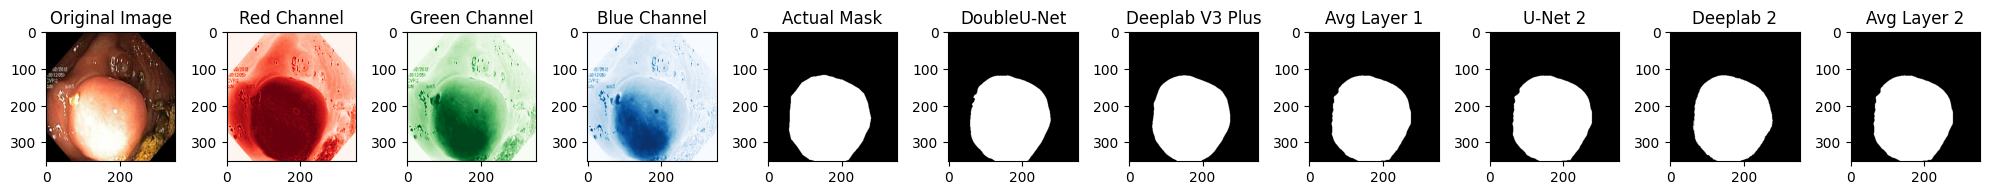

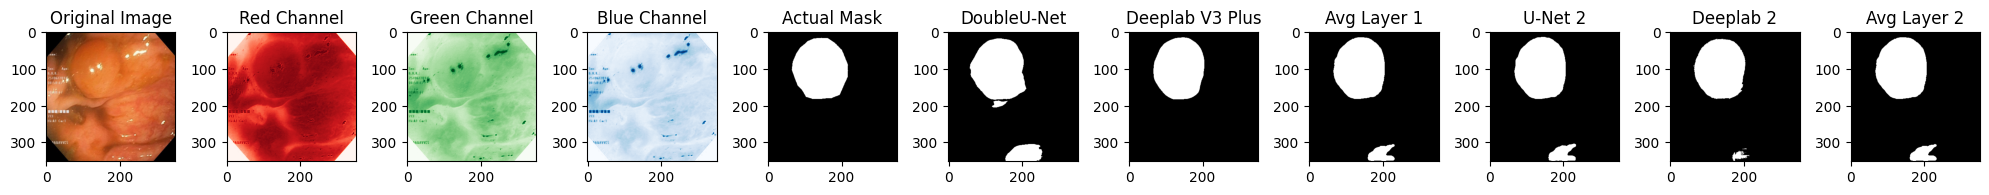

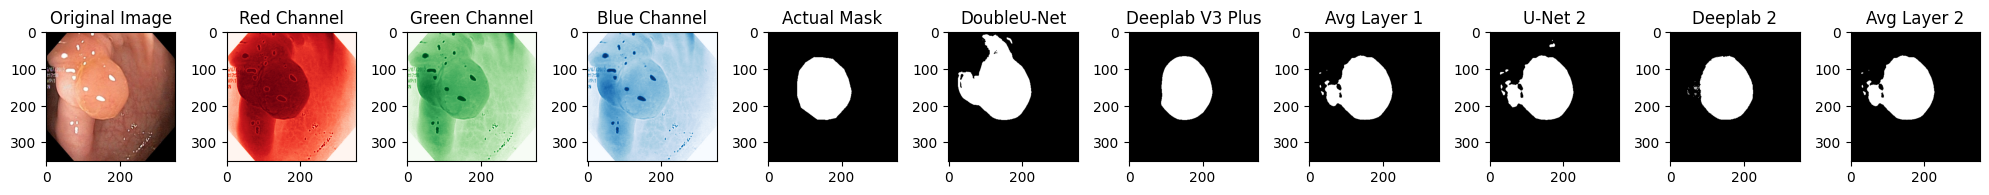

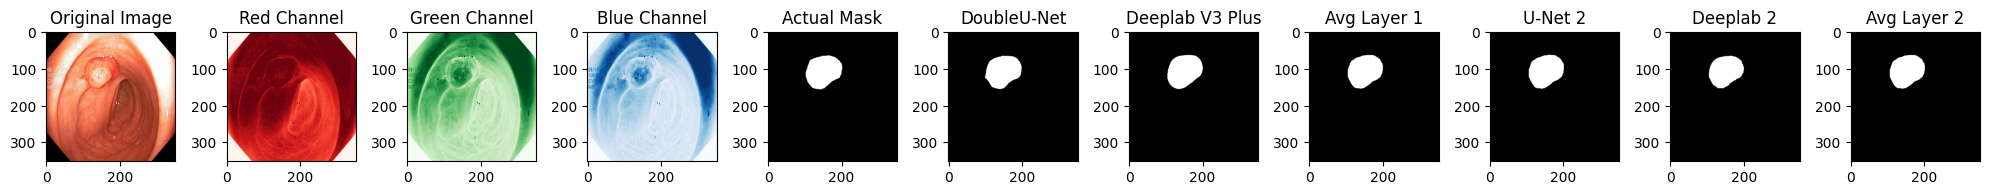

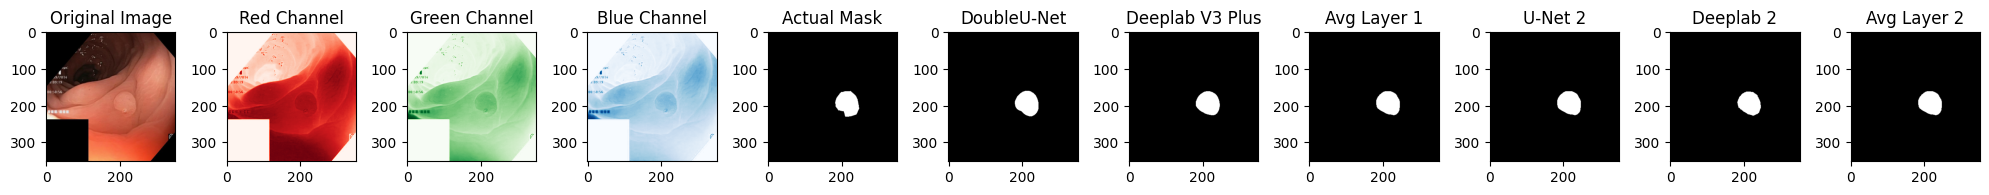

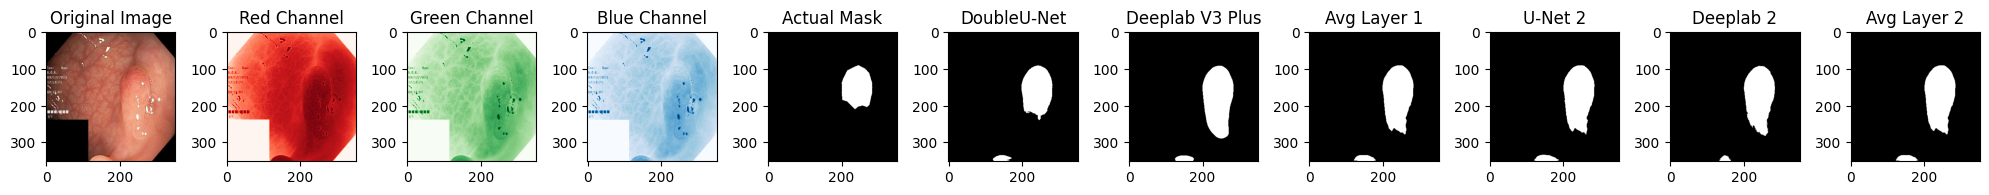

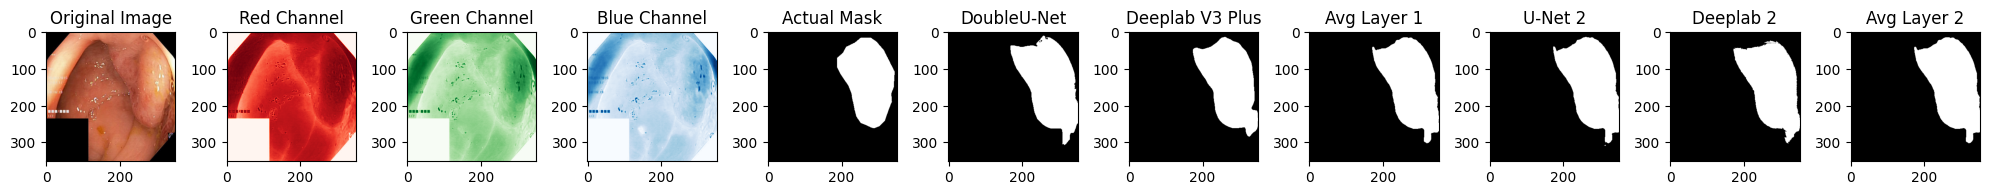

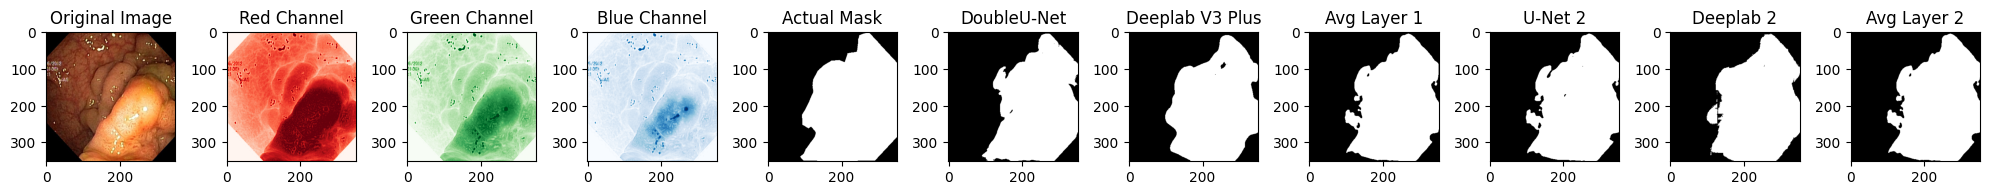

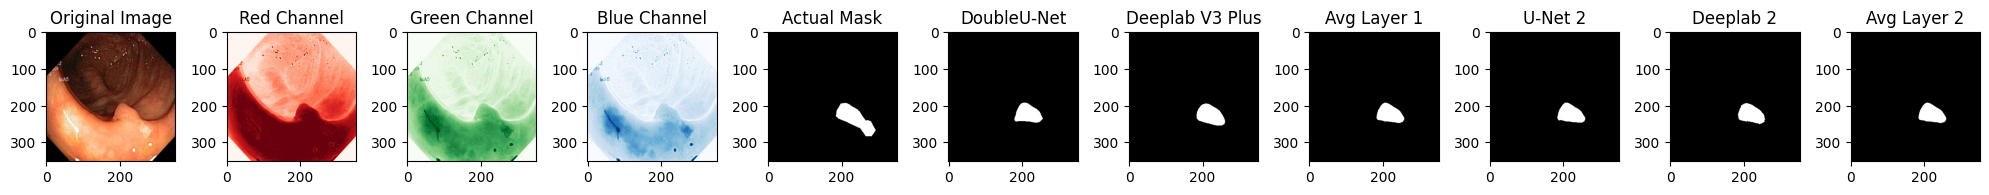

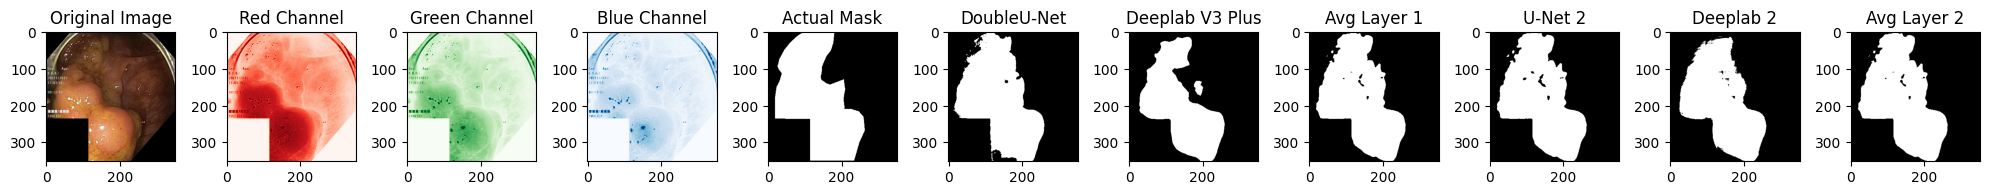

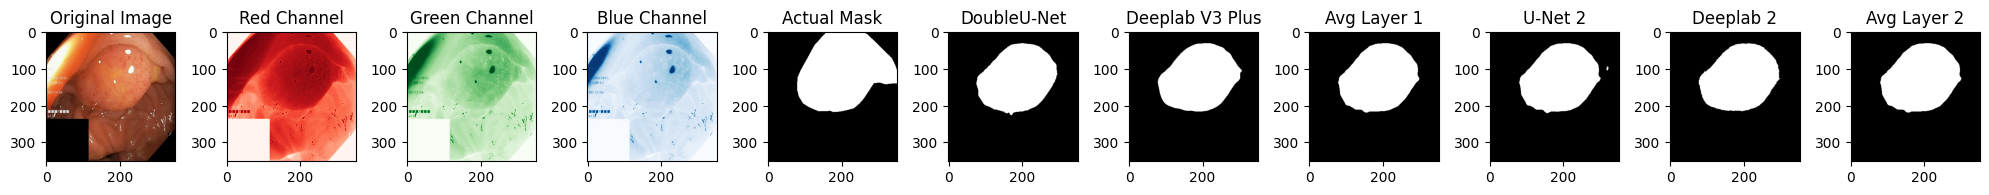

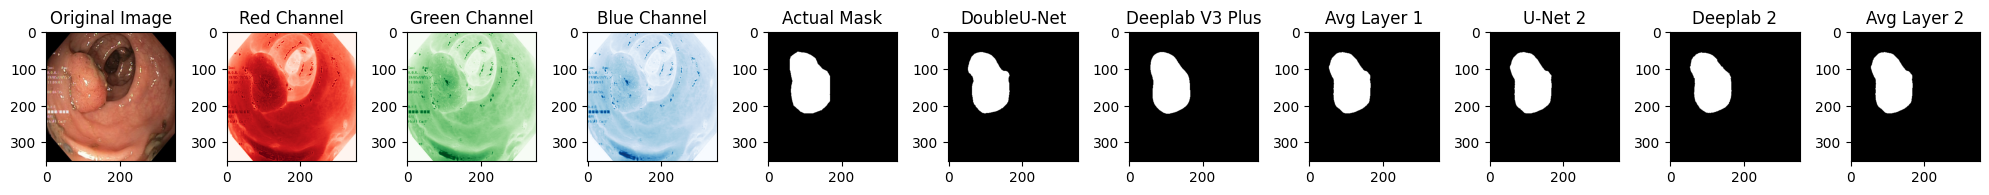

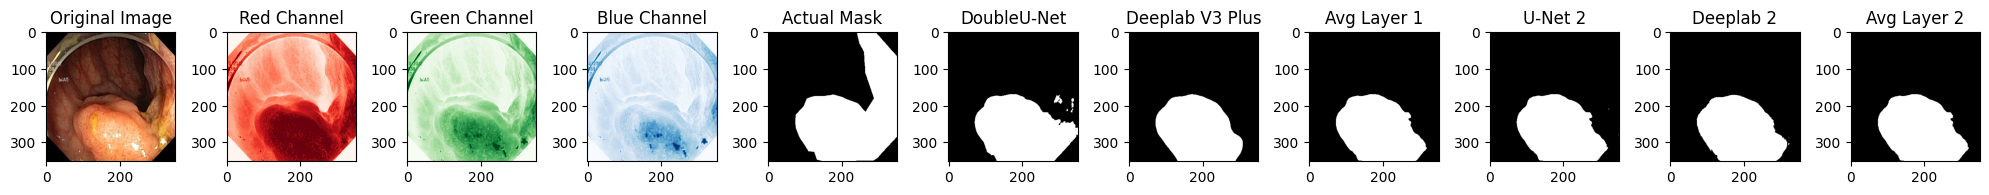

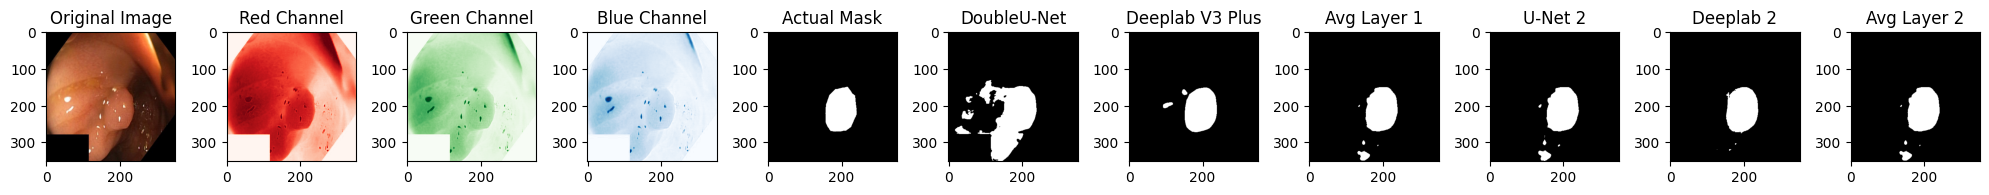

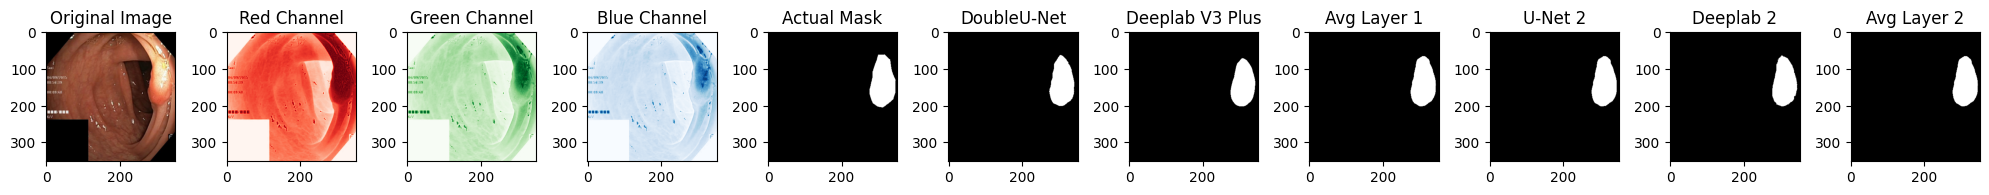

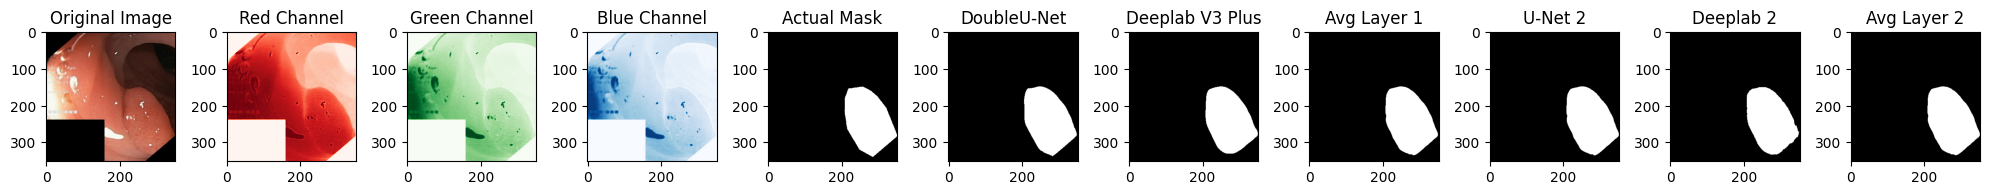

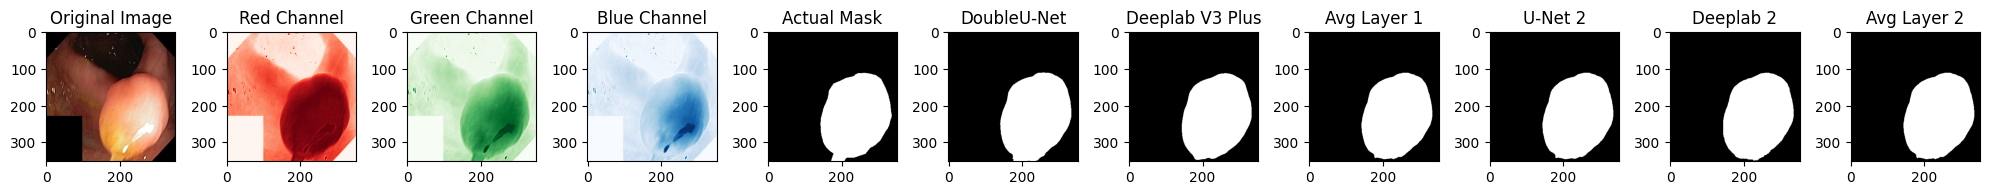

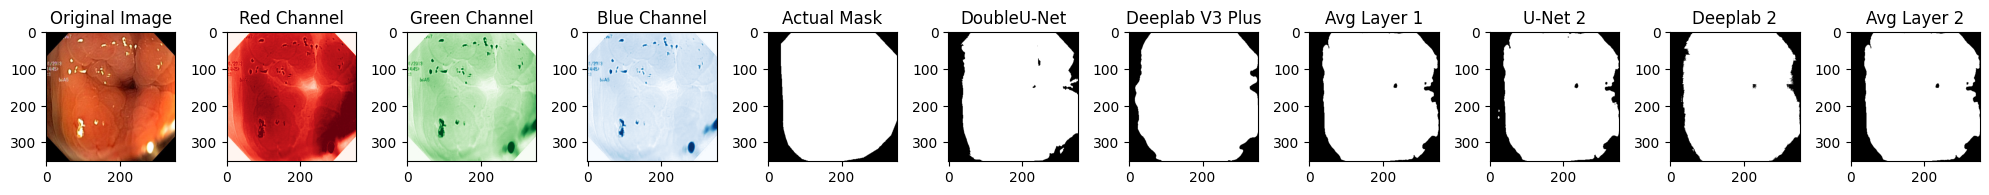

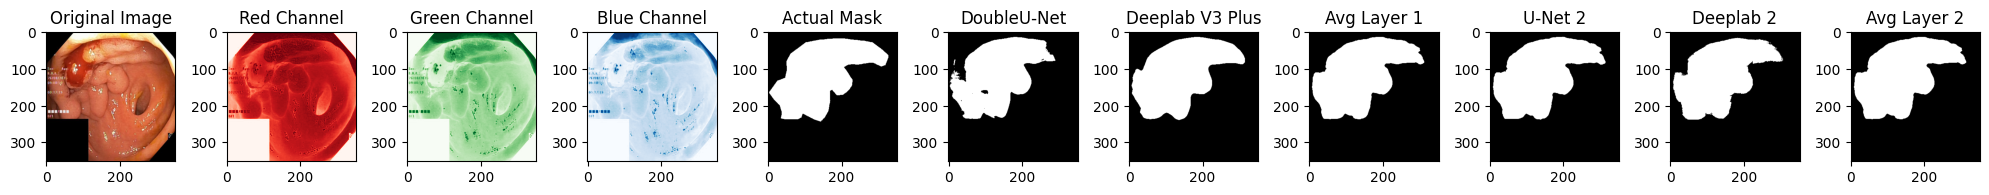

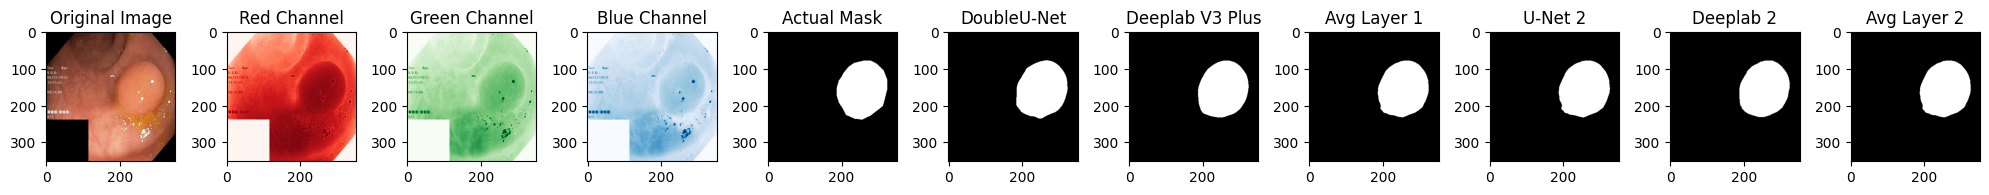

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

num_samples_to_visualize = 20
random_indices = np.random.choice(range(len(X_test)), num_samples_to_visualize, replace=False)

# Visualize each selected sample
for sample_index in random_indices:
    # Load the original image and corresponding mask
    original_image = X_test[sample_index]
    actual_mask = y_test[sample_index]

    # Get predictions for the chosen sample
    doubleunet_prediction = np.round(doubleunet_preds_t[sample_index, ..., 0])
    deeplabv3p_prediction = np.round(deeplabv3p_preds_t[sample_index, ..., 0])
    avg_prediction = np.round(average_preds_test[sample_index])
    unet2_prediction = np.round(unet2_preds_t[sample_index, ..., 0])
    deeplab2_prediction = np.round(deeplab2_preds_t[sample_index, ..., 0])
    avg2_prediction = np.round(average2_preds_test[sample_index])
    # Plot the images and predictions
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 11, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 11, 2)
    plt.imshow(original_image[:, :, 0], cmap='Reds')
    plt.title("Red Channel")

    plt.subplot(1, 11, 3)
    plt.imshow(original_image[:, :, 1], cmap='Greens')
    plt.title("Green Channel")

    plt.subplot(1, 11, 4)
    plt.imshow(original_image[:, :, 2], cmap='Blues')
    plt.title("Blue Channel")

    plt.subplot(1, 11, 5)
    plt.imshow(actual_mask, cmap='gray')
    plt.title("Actual Mask")

    plt.subplot(1, 11, 6)
    plt.imshow(doubleunet_prediction, cmap='gray')
    plt.title("DoubleU-Net")

    plt.subplot(1, 11, 7)
    plt.imshow(deeplabv3p_prediction, cmap='gray')
    plt.title("Deeplab V3 Plus")
    
    plt.subplot(1, 11, 8)
    plt.imshow(avg_prediction, cmap='gray')
    plt.title("Avg Layer 1")
    
    plt.subplot(1, 11, 9)
    plt.imshow(unet2_prediction, cmap='gray')
    plt.title("U-Net 2")

    plt.subplot(1, 11, 10)
    plt.imshow(deeplab2_prediction, cmap='gray')
    plt.title("Deeplab 2")

    plt.subplot(1, 11, 11)
    plt.imshow(avg2_prediction, cmap='gray')
    plt.title("Avg Layer 2")


    plt.tight_layout()
    plt.show()